# Forecasting using Polynomial Regression

In [279]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA, ARMAResults 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [280]:
datapath   = '../input/covid19-global-forecasting-week-2/'
train      = pd.read_csv(datapath+'train.csv',)
test       = pd.read_csv(datapath+'test.csv')

In [281]:
print("Train dataset: ", train.head())
print("Train period: ", train.Date.min(), train.Date.max())
print("Test dataset: ", test.head())
print("Test period: ", test.Date.min(), test.Date.max())

Train dataset:     Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0
Train period:  2020-01-22 2020-03-31
Test dataset:     ForecastId Province_State Country_Region        Date
0           1            NaN    Afghanistan  2020-03-19
1           2            NaN    Afghanistan  2020-03-20
2           3            NaN    Afghanistan  2020-03-21
3           4            NaN    Afghanistan  2020-03-22
4           5            NaN    Afghanistan  2020-03-23
Test period:  2020-03-19 2020-04-30


In [282]:
# check metadata of train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
Id                20580 non-null int64
Province_State    8750 non-null object
Country_Region    20580 non-null object
Date              20580 non-null object
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 964.8+ KB


In [283]:
# check metadata of test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 4 columns):
ForecastId        12642 non-null int64
Province_State    5375 non-null object
Country_Region    12642 non-null object
Date              12642 non-null object
dtypes: int64(1), object(3)
memory usage: 395.2+ KB


In [284]:
train['Date'] = train['Date'].astype('datetime64[ns]')
test['Date'] = test['Date'].astype('datetime64[ns]')

print("Train Date type: ", train['Date'].dtype)
print("Test Date type: ",test['Date'].dtype)

Train Date type:  datetime64[ns]
Test Date type:  datetime64[ns]


In [285]:
train.columns = ['id','state','country','date','ConfirmedCases','Fatalities']
test.columns  = ['ForecastId', 'state','country','date']

In [286]:
train['place'] = train['state'].fillna('') + '_' + train['country']
test['place'] = test['state'].fillna('') + '_' + test['country']

In [287]:
print('How many places?: ', 'Train: ', len(train['place'].unique()), 
      'Test: ', len(test['place'].unique()))
print('Unique place similar as test?: ',(train['place'].unique() == test['place'].unique()).sum())

How many places?:  Train:  294 Test:  294
Unique place similar as test?:  294


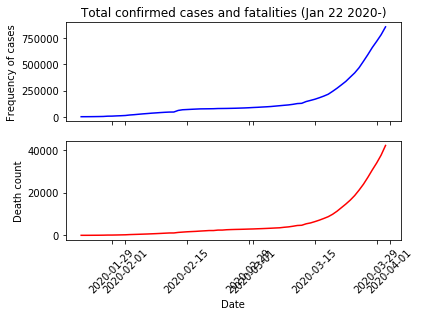

In [288]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(train.groupby('date')['ConfirmedCases'].sum(),color='blue')
ax[1].plot(train.groupby('date')['Fatalities'].agg(sum),color='red')

ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities (Jan 22 2020-)')
plt.show()

In [289]:
china_cases     = train[train['place'].str.contains('China')][['date',
                                                               'ConfirmedCases',
                                                               'Fatalities']].reset_index(drop=True)
restworld_cases = train[-train['place'].str.contains('China')][['date',
                                                                'ConfirmedCases',
                                                                'Fatalities']].reset_index(drop=True)

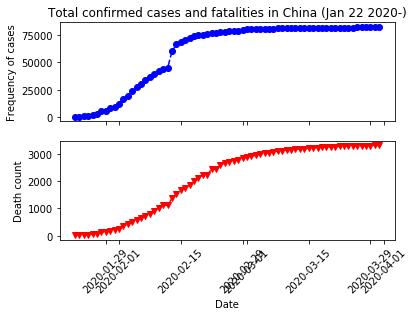

In [290]:
#plot total confirmed cases and fatalities in China

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(china_cases.groupby('date')['ConfirmedCases'].sum(), marker='o',color='b', 
            linestyle='--')
ax[1].plot(china_cases.groupby('date')['Fatalities'].sum(), marker='v',color='r',
            linestyle='--')
ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities in China (Jan 22 2020-)')
plt.show()

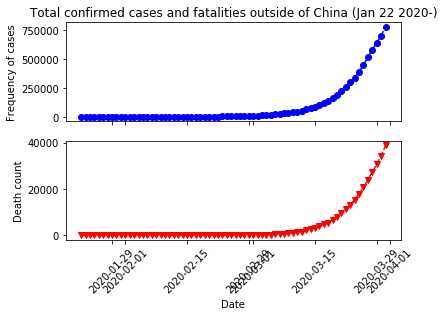

In [291]:
# plot total confirmed cases and fatalities outside of China

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(restworld_cases.groupby('date')['ConfirmedCases'].sum(), marker='o',color='b', 
            linestyle='--')
ax[1].plot(restworld_cases.groupby('date')['Fatalities'].sum(), marker='v',color='r',
            linestyle='--')
ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities outside of China (Jan 22 2020-)')
plt.show()

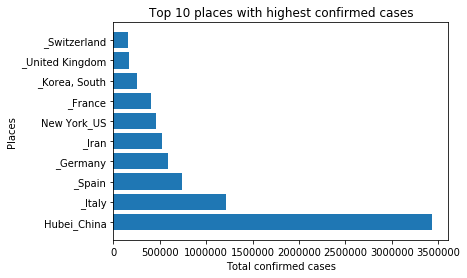

In [292]:
top10cases = train.groupby('place')['ConfirmedCases'].sum().sort_values(ascending=False).head(10)

plt.barh(top10cases.index, top10cases)
plt.ylabel('Places')
plt.xlabel('Total confirmed cases')
plt.title('Top 10 places with highest confirmed cases')
plt.show()

In [293]:
# let's look at US states

us_cases     = train[train['place'].str.contains('US')][['date','place',
                                                         'ConfirmedCases',
                                                               'Fatalities']].reset_index(drop=True)

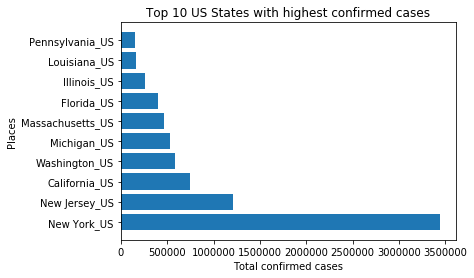

In [294]:
top10uscases = us_cases.groupby('place')['ConfirmedCases'].sum().sort_values(ascending=False).head(10)

plt.barh(top10uscases.index, top10cases)
plt.ylabel('Places')
plt.xlabel('Total confirmed cases')
plt.title('Top 10 US States with highest confirmed cases')
plt.show()

In [295]:
def RMSLE(predicted, actual):
    return np.sqrt(np.mean(np.power((np.log(predicted+1)-np.log(actual+1)),2)))

In [296]:
train_sub = train[['id','place','date','ConfirmedCases','Fatalities']] 
train_sub['logConfirmedCases'] = np.log(train_sub['ConfirmedCases'])
train_sub = train_sub.set_index('date')

In [297]:
list= []
# using rolling window = 3 days

for place in train_sub.place.unique():    
    a = train_sub[train_sub['place']==place]
    a['z_cases'] = (a['logConfirmedCases']- a['logConfirmedCases'].rolling(window=3).mean())/a['logConfirmedCases'].rolling(window=3).std()
    a['zp_cases']= a['z_cases']- a['z_cases'].shift(3)
    a['z_death'] =(a['Fatalities']-a['Fatalities'].rolling(window=3).mean())/a['Fatalities'].rolling(window=3).std()
    a['zp_death']= a['z_death']- a['z_death'].shift(3)
    list.append(a)
    
rolling_df = pd.concat(list)

In [298]:
def plot_rolling(df, variable, z, zp):
    fit, ax= plt.subplots(2, figsize=(10,9), sharex=True)
    ax[0].plot(df.index, df[variable], label='raw data')
    ax[0].plot(df[variable].rolling(window=3).mean(), label="rolling mean");
    ax[0].plot(df[variable].rolling(window=3).std(), label="rolling std (x10)");
    ax[0].legend()
    
    ax[1].plot(df.index, df[z], label="de-trended data")
    ax[1].plot(df[z].rolling(window=3).mean(), label="rolling mean");
    ax[1].plot(df[z].rolling(window=3).std(), label="rolling std (x10)");
    ax[1].legend()
    
    ax[1].set_xlabel('Date')
    plt.xticks(rotation=45)
    ax[0].set_title('{}'.format(place))
    
    plt.show()
    plt.close()

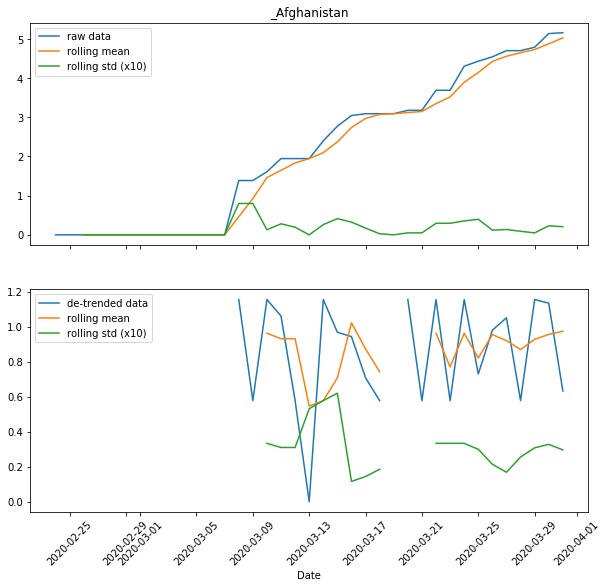

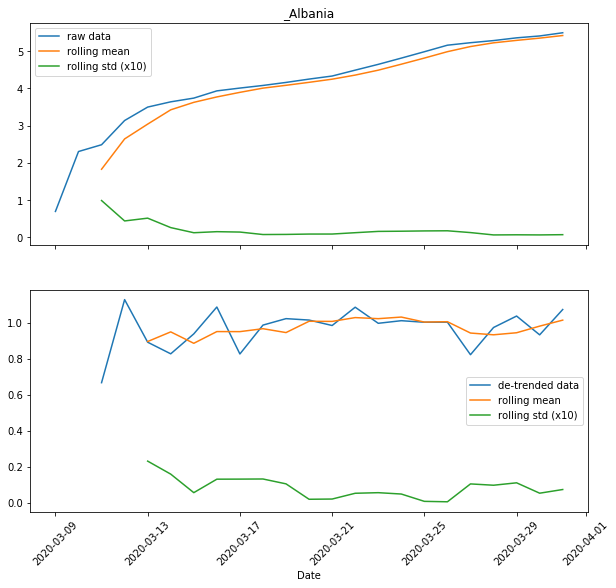

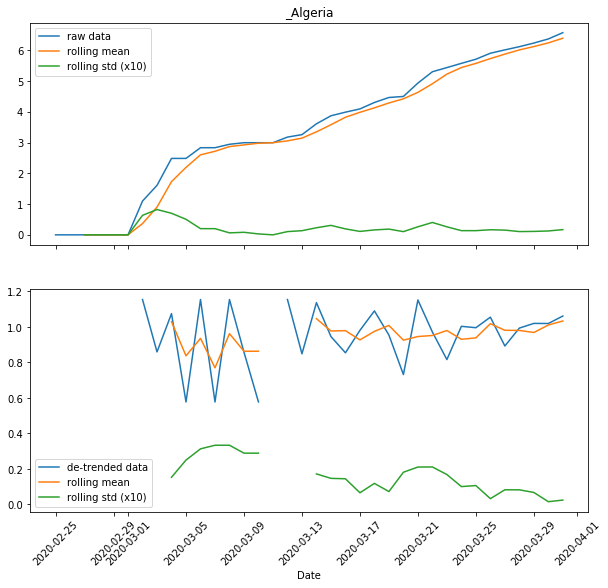

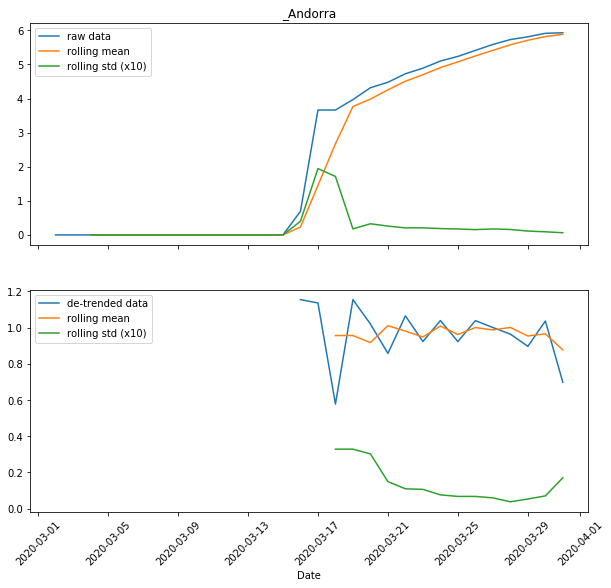

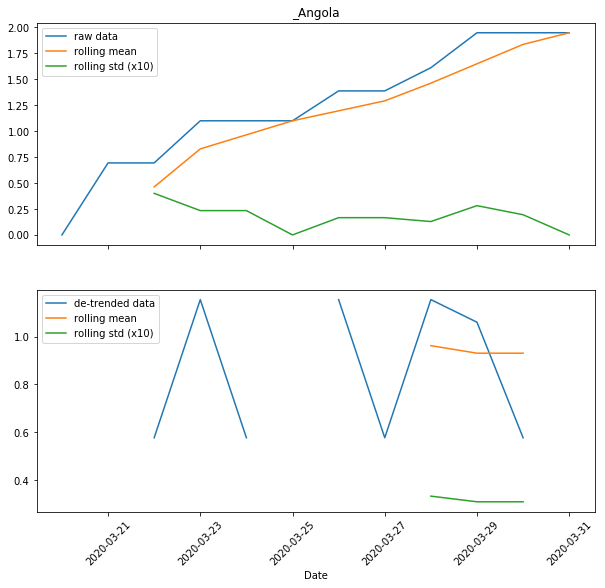

In [299]:
# rolling plots for Confirmed Cases

for place in rolling_df.place.unique()[:5]:
    plot_rolling(df= rolling_df[rolling_df['place']==place], 
                 variable='logConfirmedCases', z= 'z_cases', 
                                 zp= 'zp_cases')

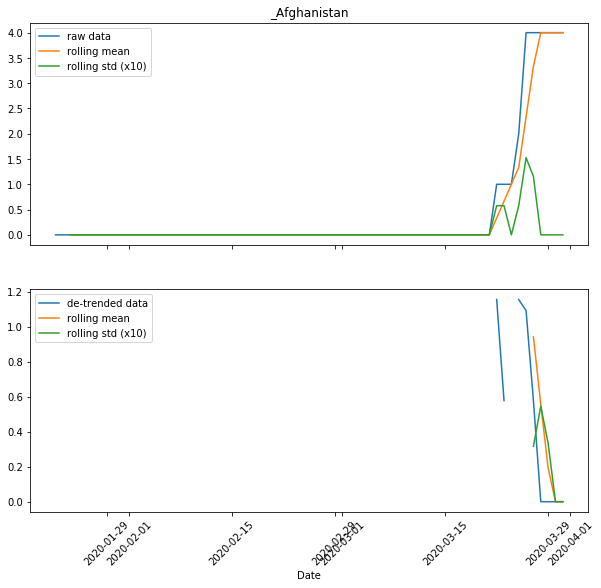

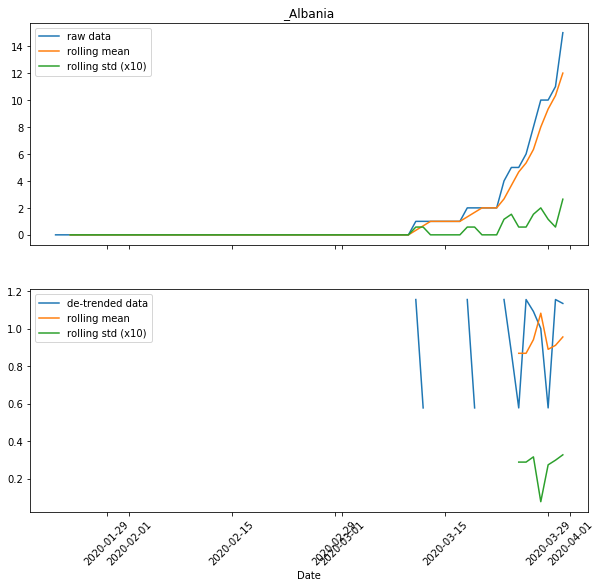

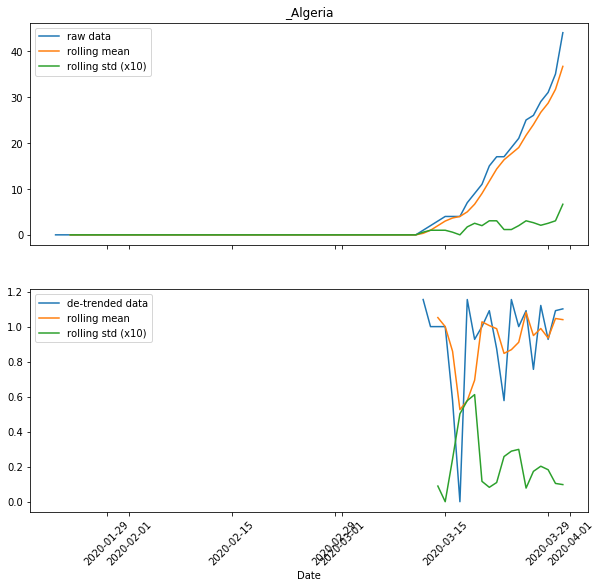

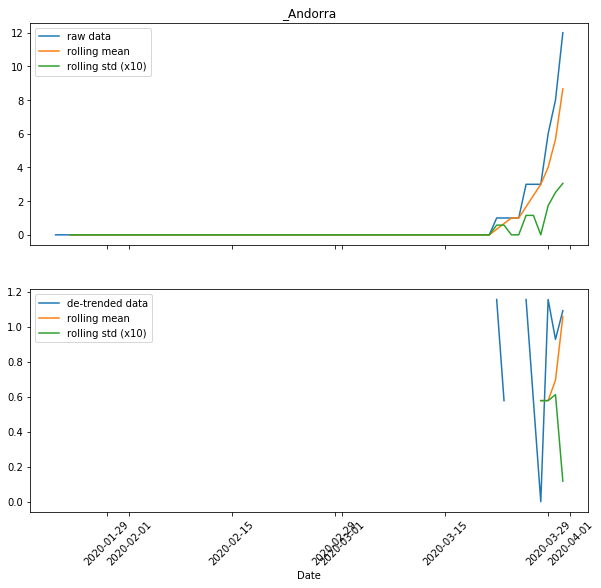

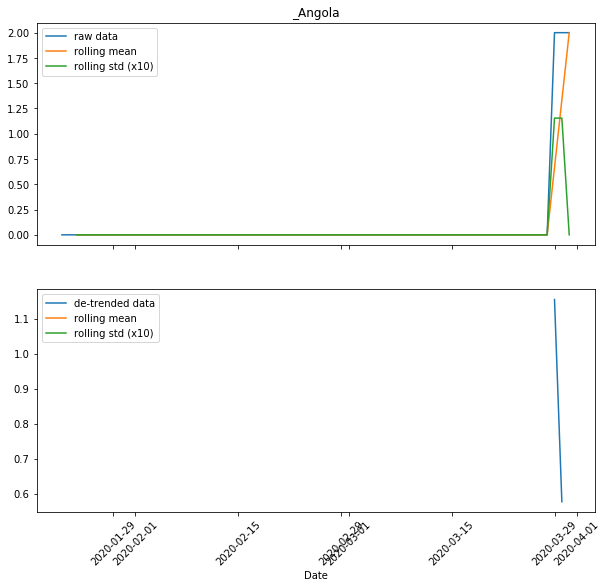

In [300]:
# rolling plots for Fatalities

for place in rolling_df.place.unique()[:5]:
    plot_rolling(df= rolling_df[rolling_df['place']==place], 
                 variable='Fatalities', z= 'z_death', 
                                 zp= 'zp_death')

In [301]:
stationary_data =[]
for place in train_sub.place.unique():
    a= rolling_df[(rolling_df['place']==place) & (rolling_df['logConfirmedCases'] > 0)]['logConfirmedCases'].dropna()
    try:   
        dftest = adfuller(a, autolag='AIC')
        if (dftest[1] < 0.001):
            stationary_data.append(place)
        else: 
            pass
    except:
        pass
    
print(len(stationary_data))

57


In [302]:
station_death_data =[]
for place in train_sub.place.unique():
    dftest = adfuller(rolling_df[rolling_df['place']==place]['Fatalities'], autolag='AIC')
    if (dftest[1] < 0.001):
        station_death_data.append(place)
    else: 
        pass
    
print(len(station_death_data))

33


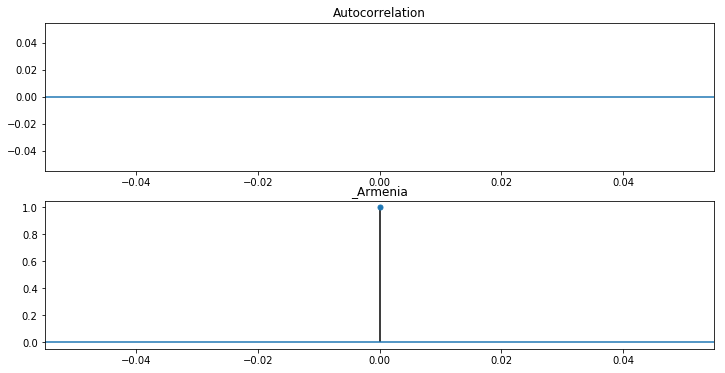

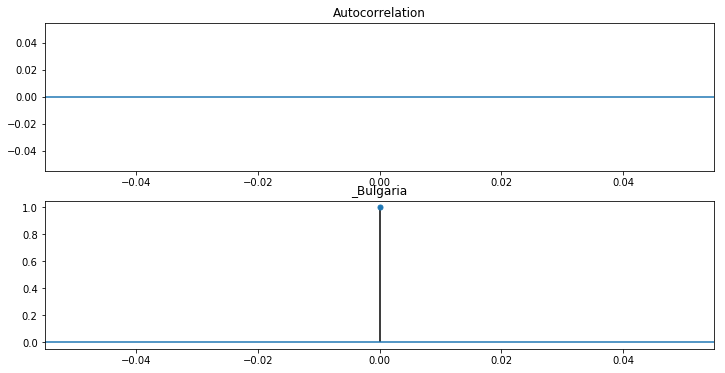

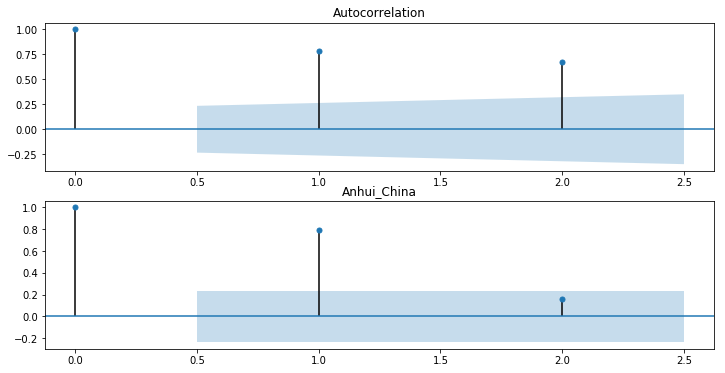

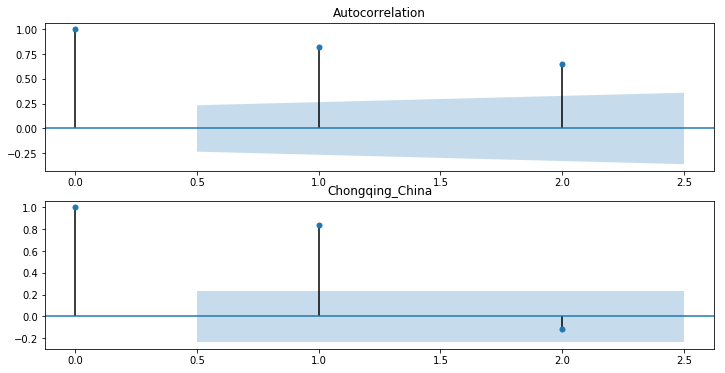

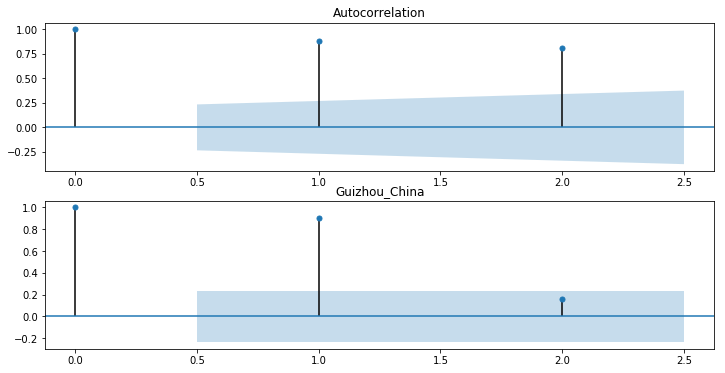

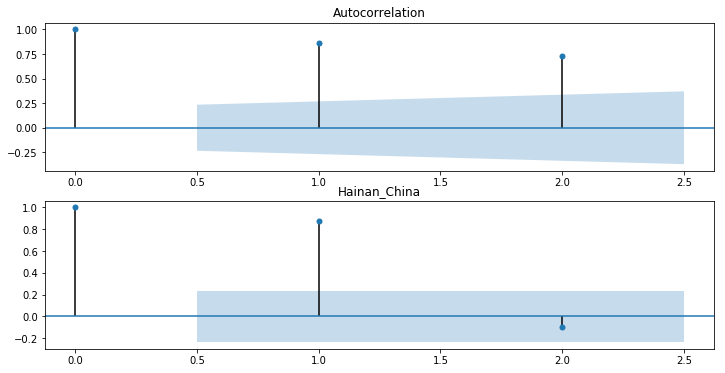

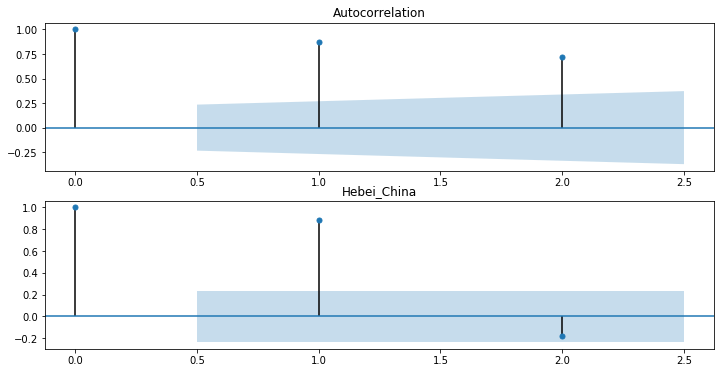

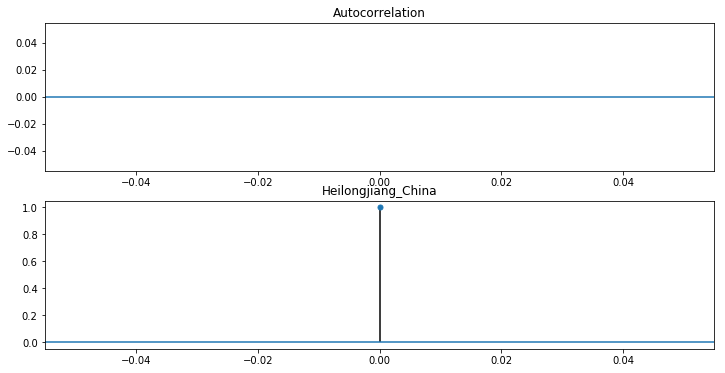

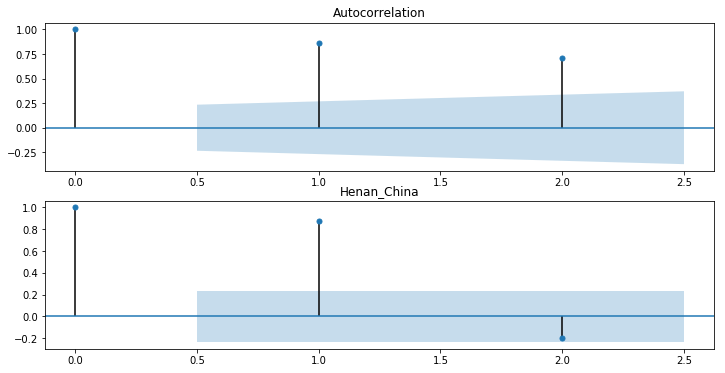

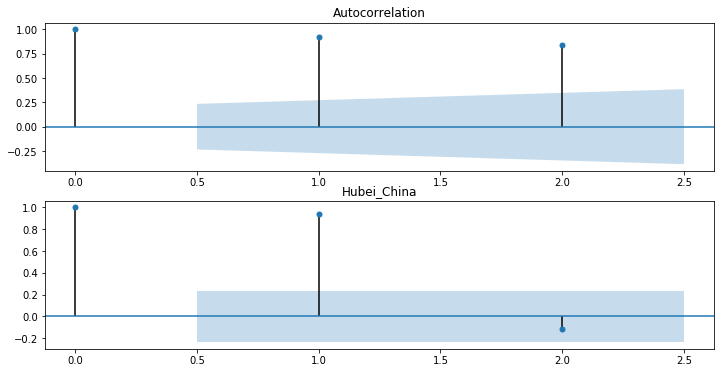

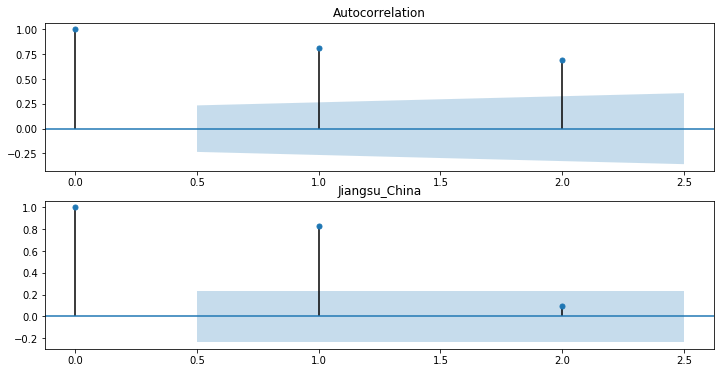

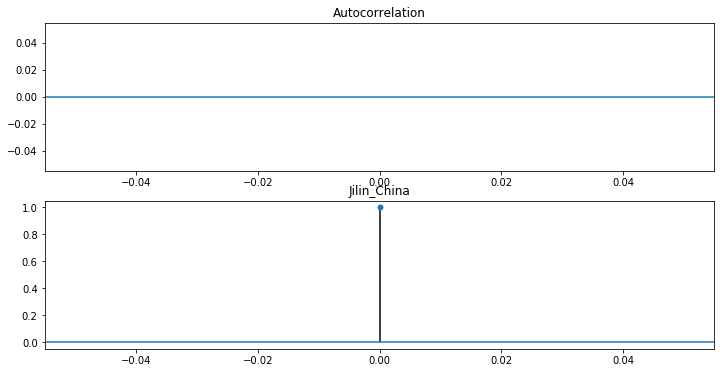

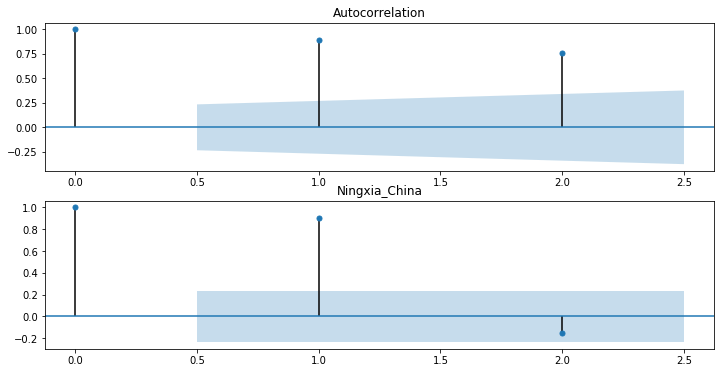

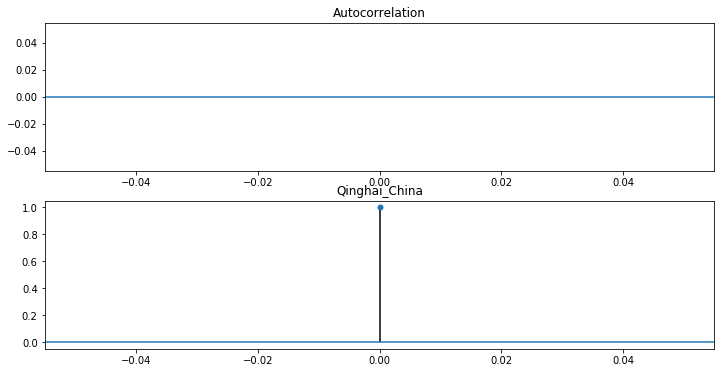

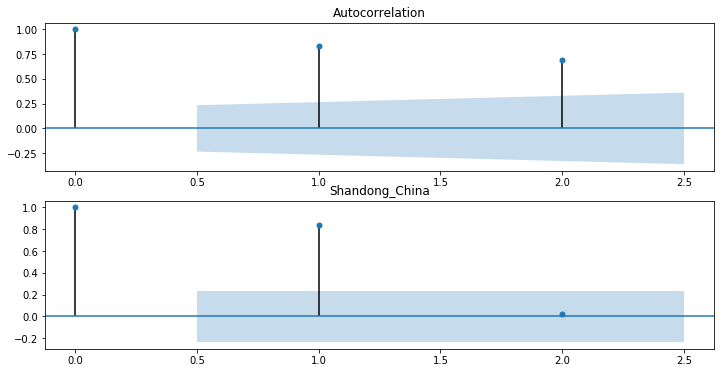

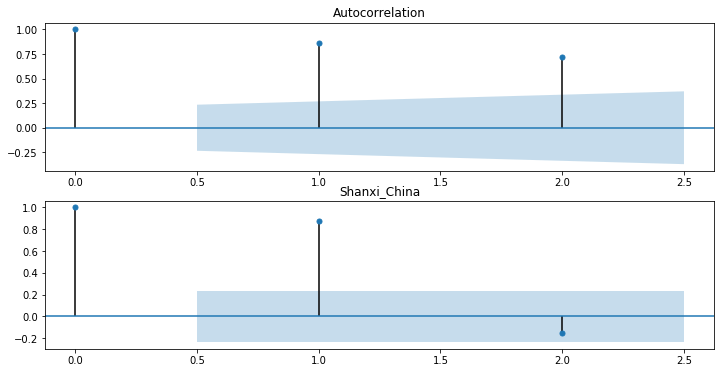

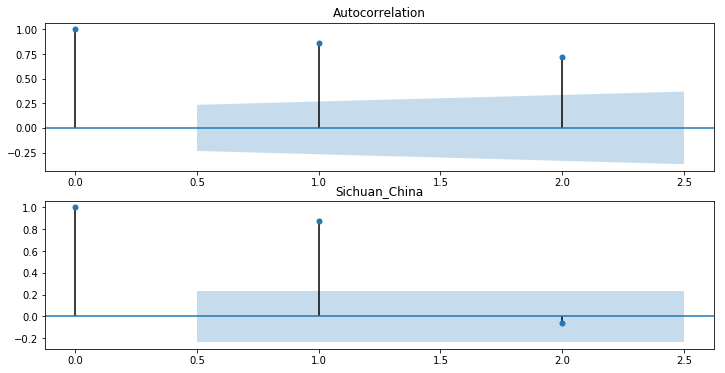

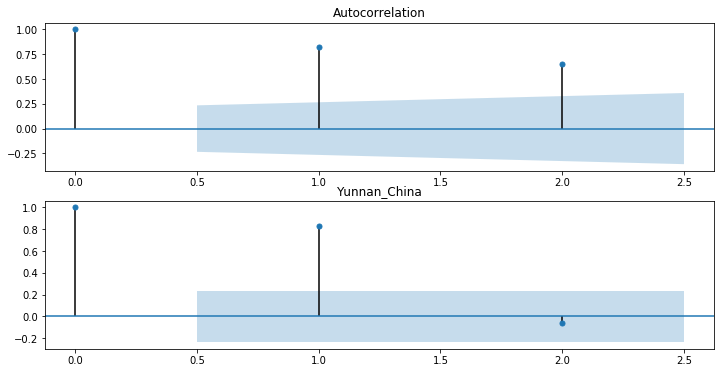

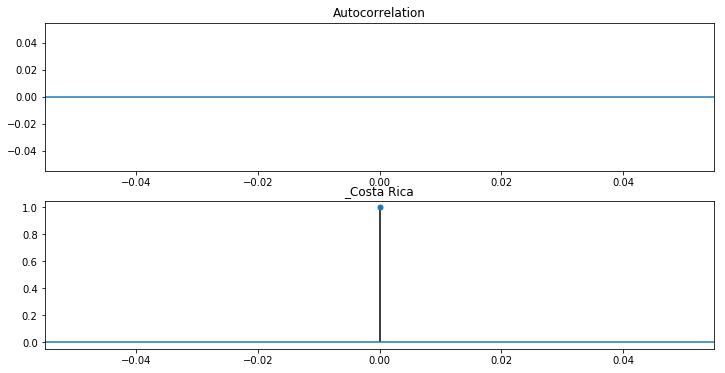

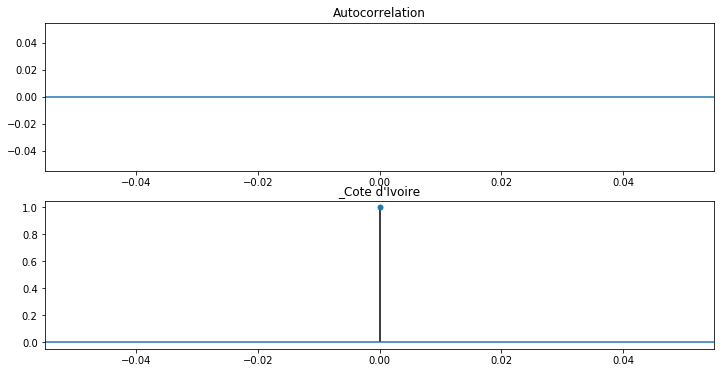

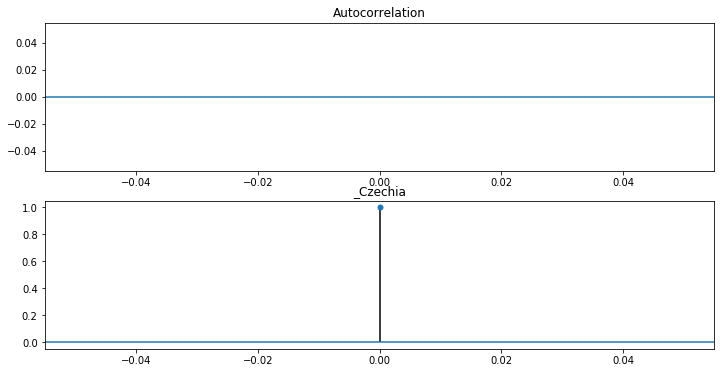

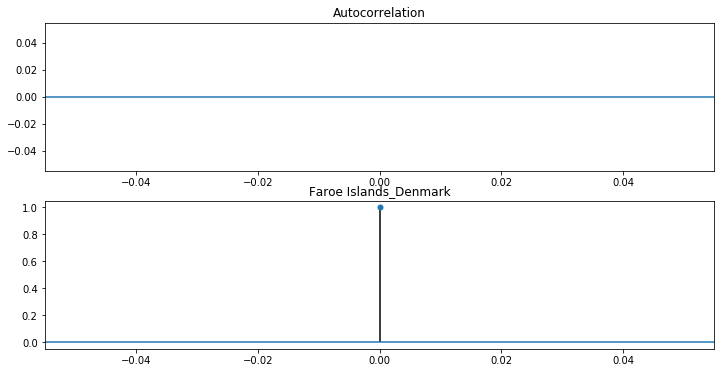

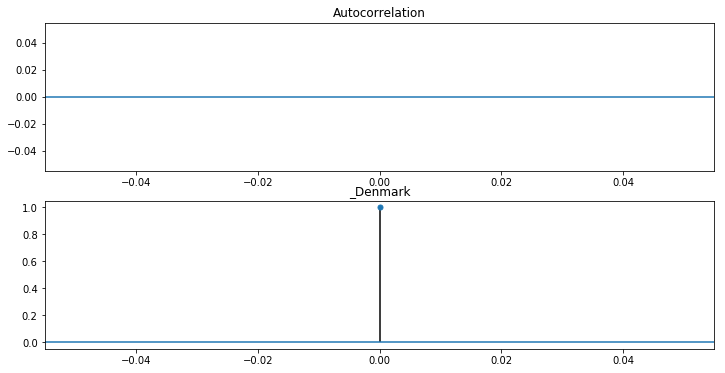

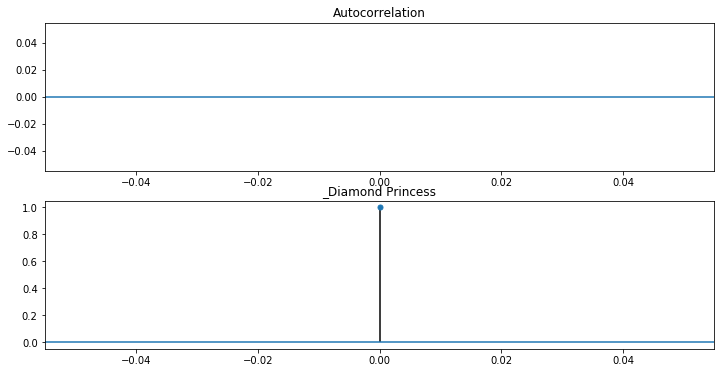

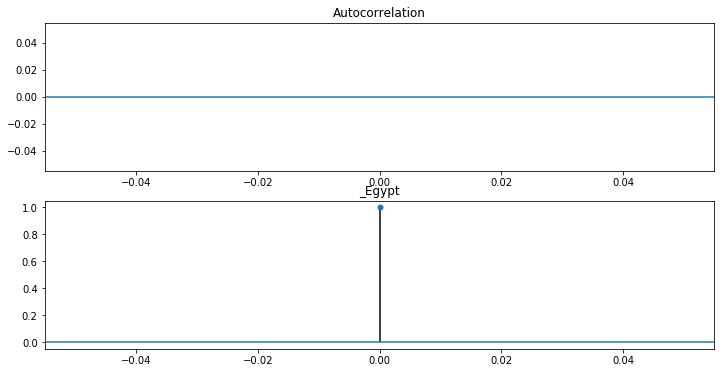

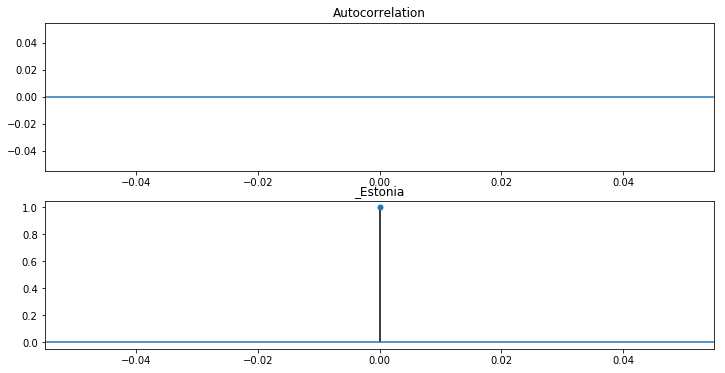

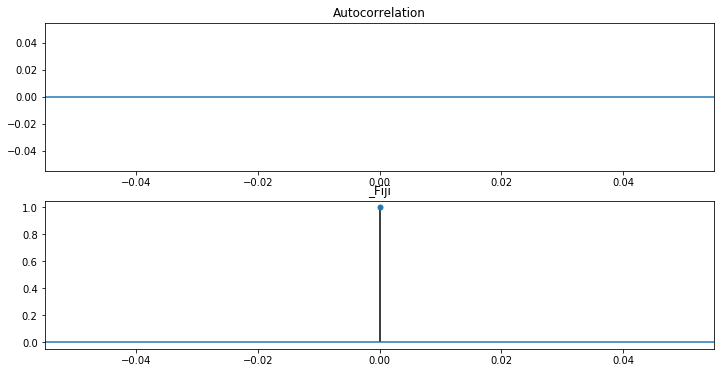

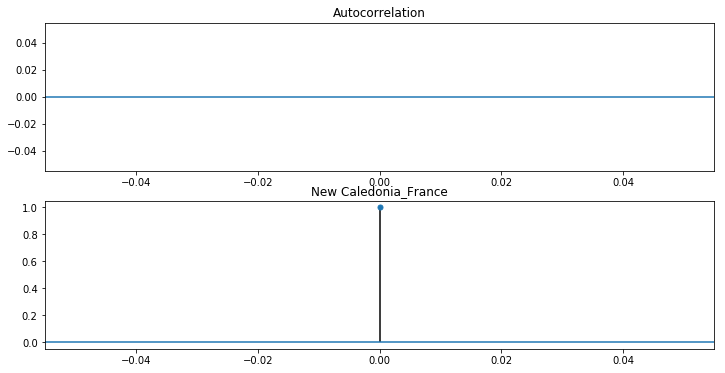

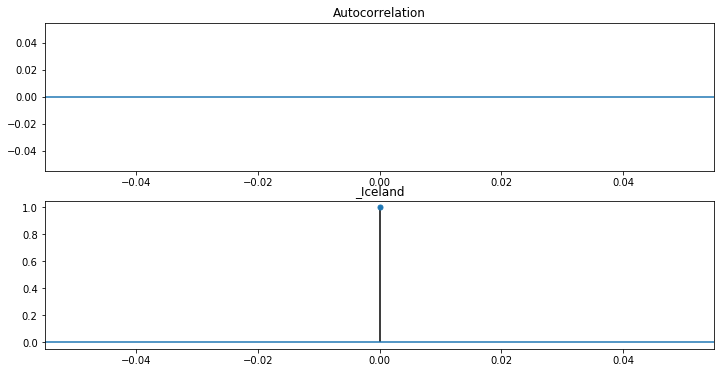

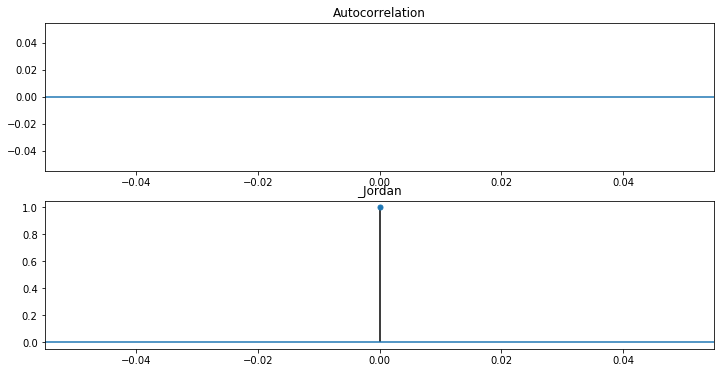

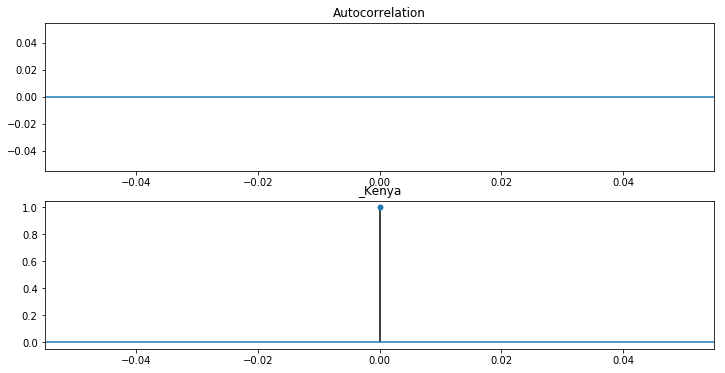

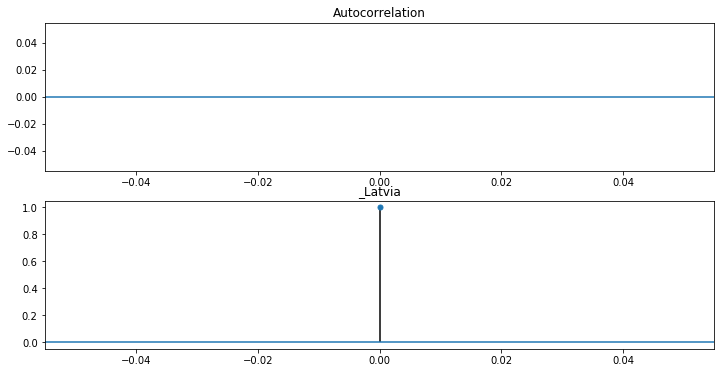

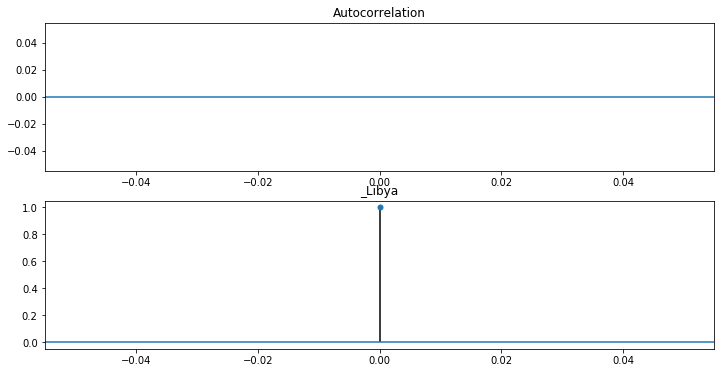

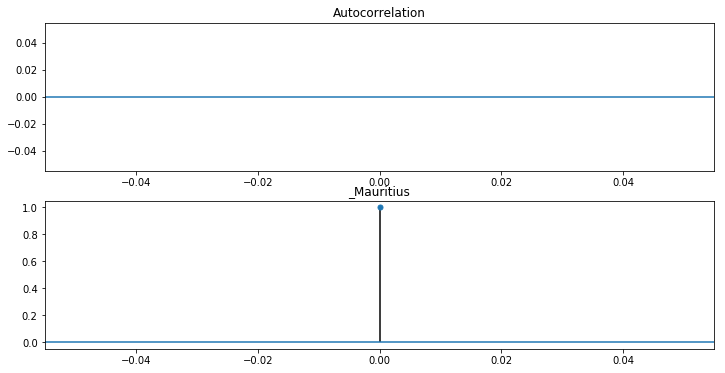

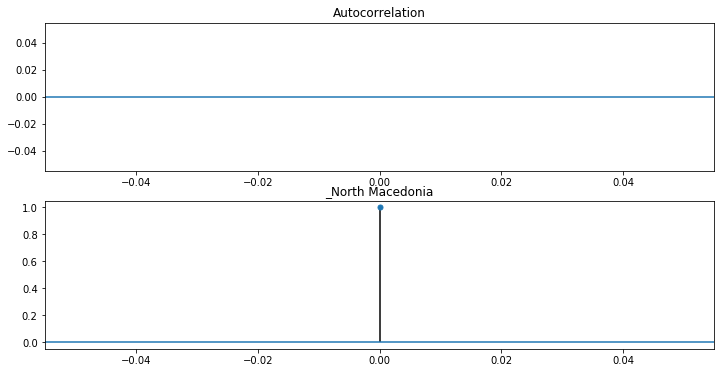

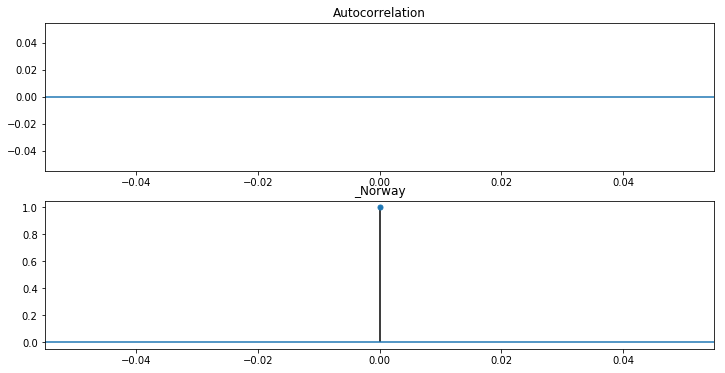

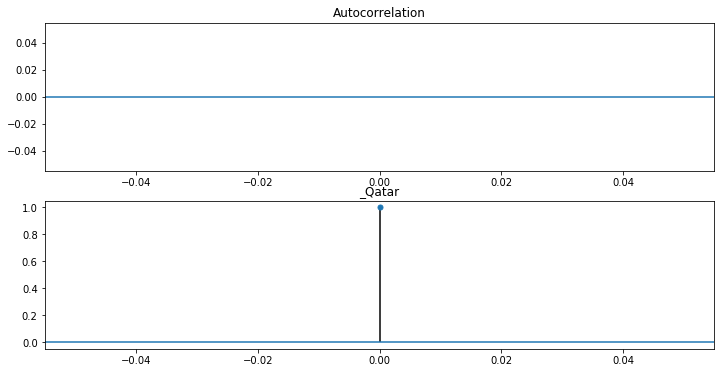

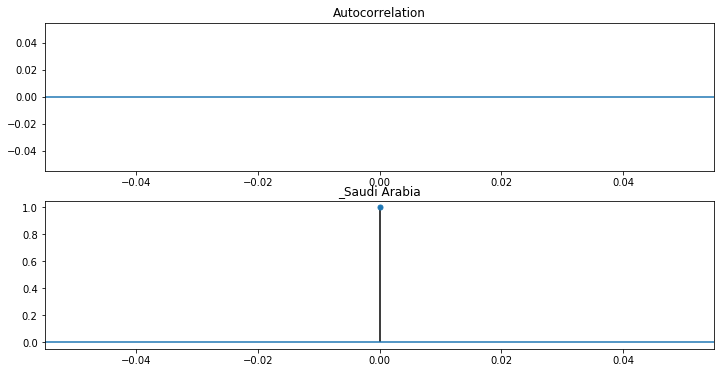

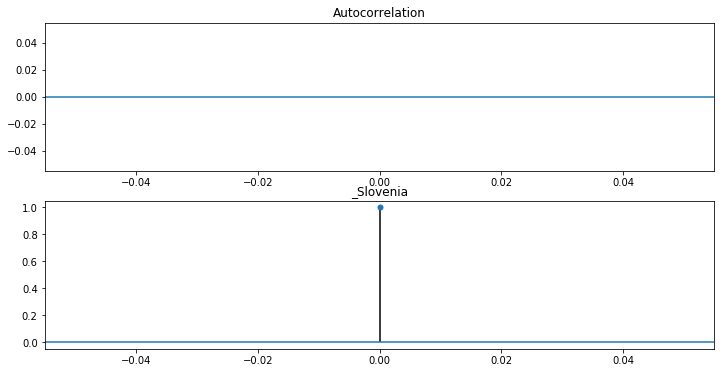

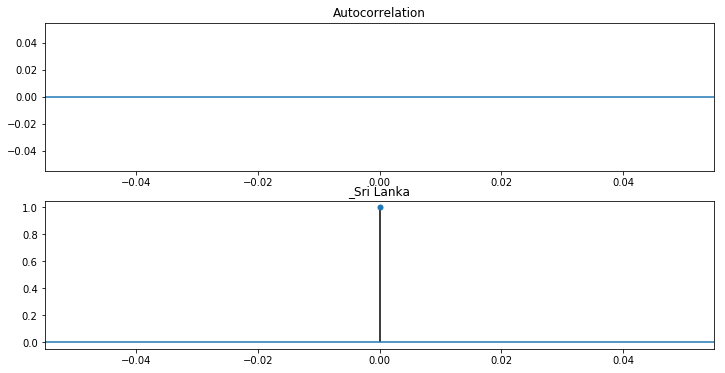

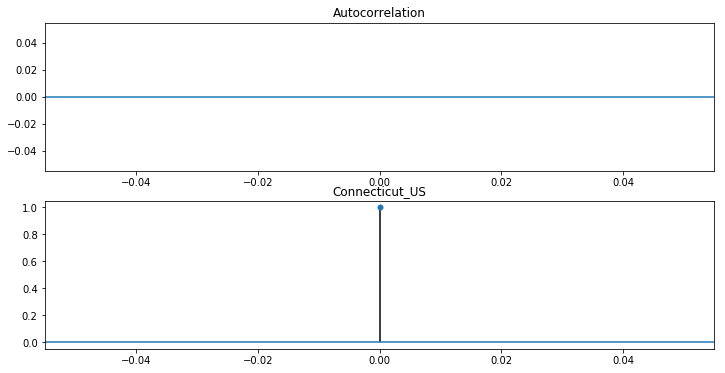

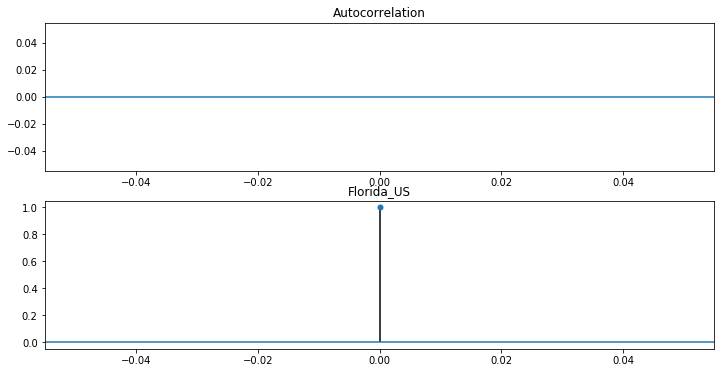

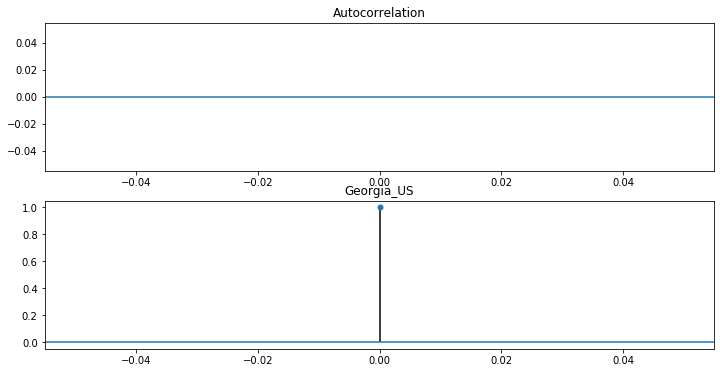

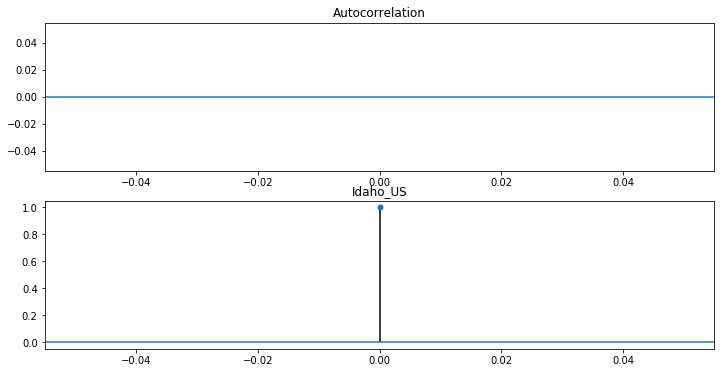

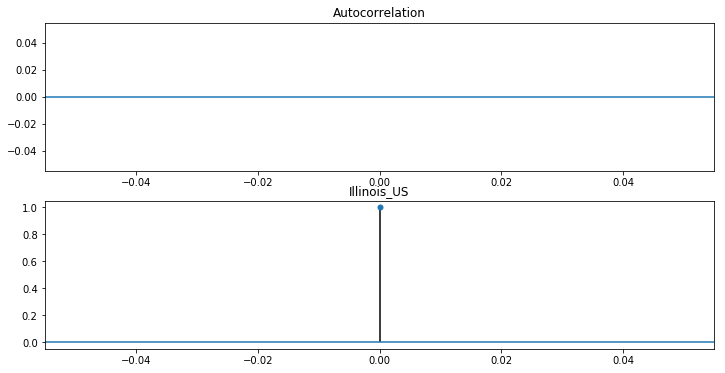

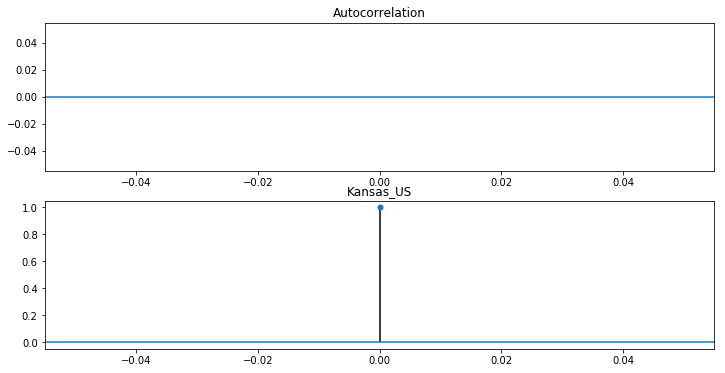

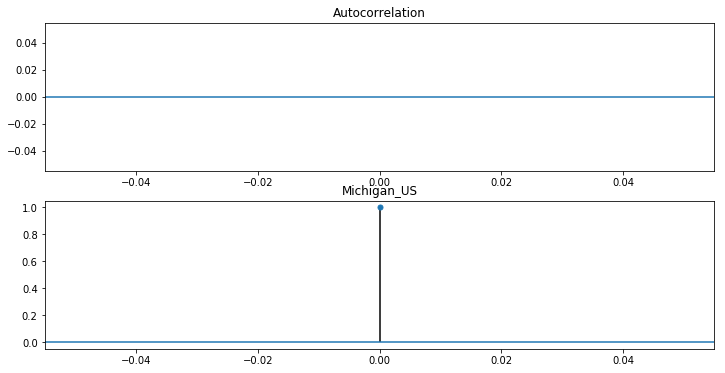

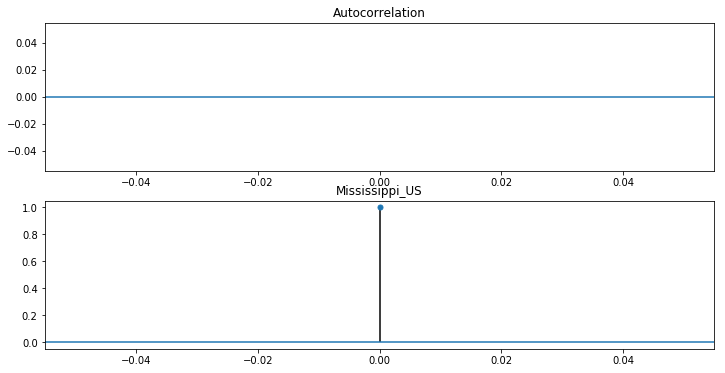

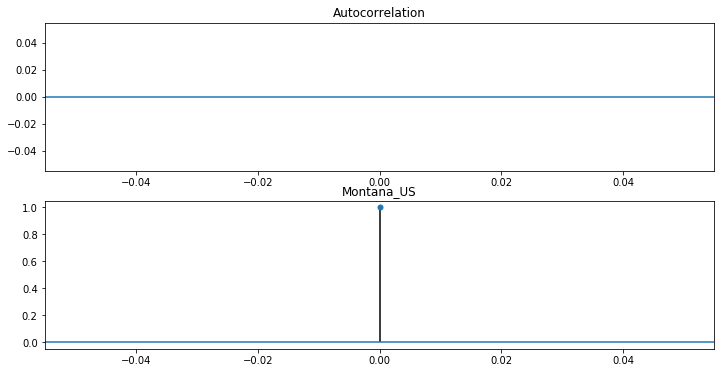

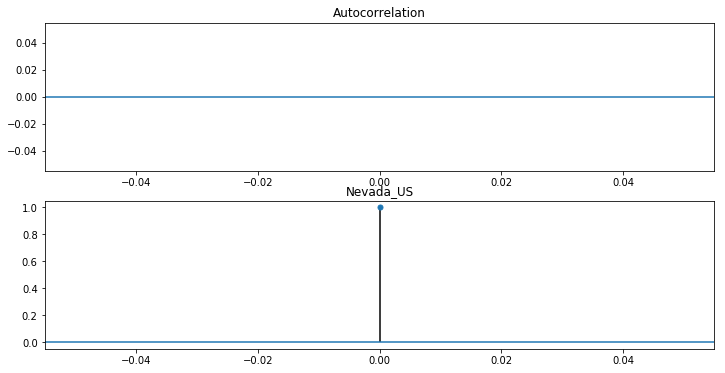

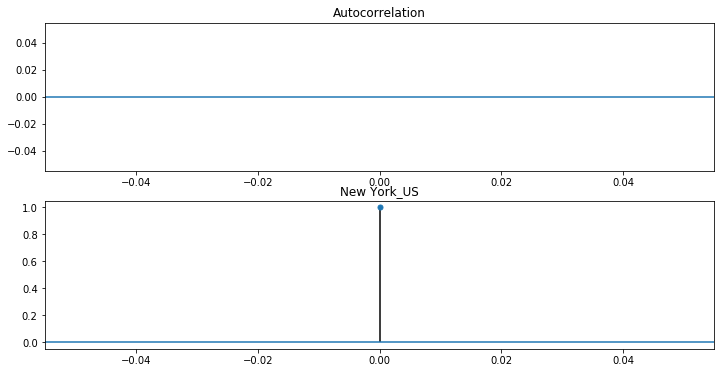

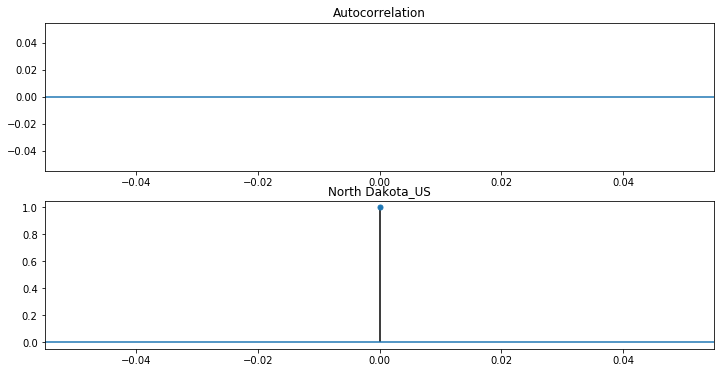

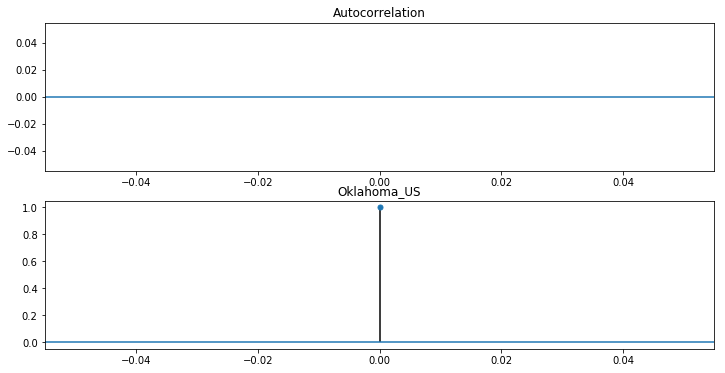

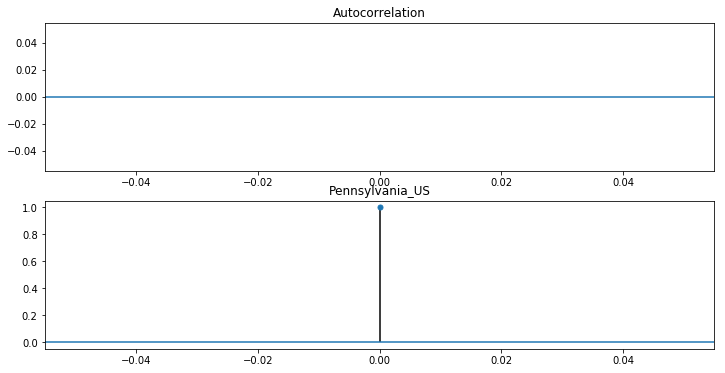

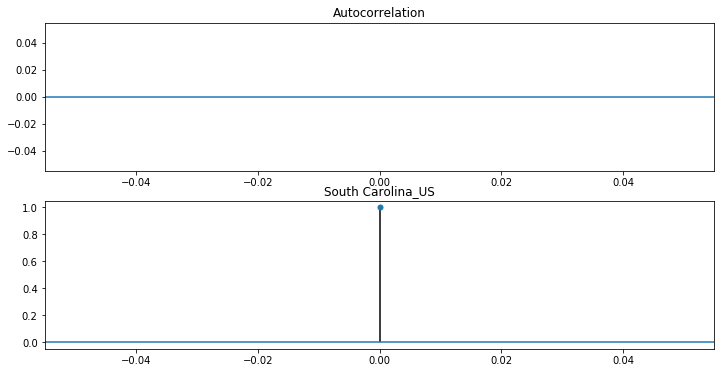

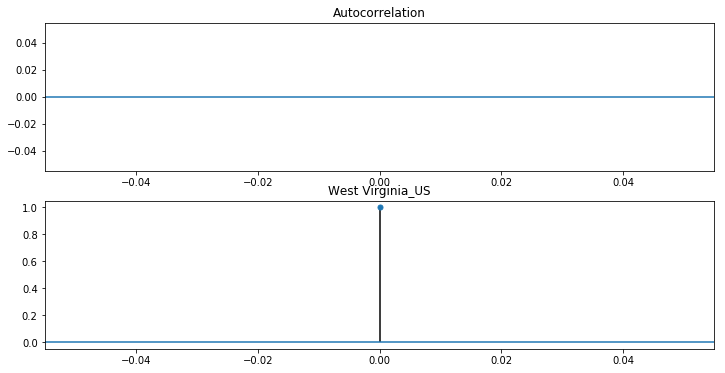

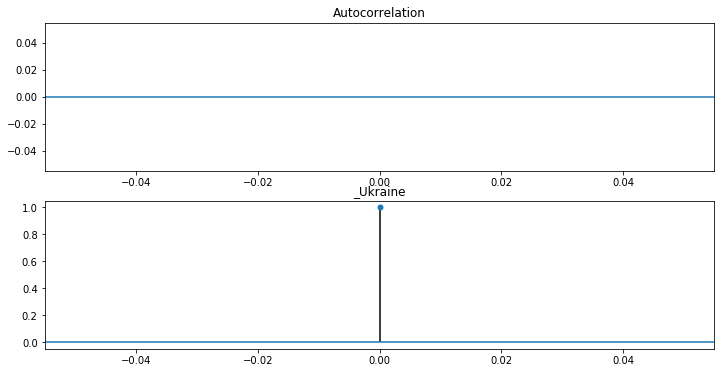

In [303]:
# ACF and PACF plots for Confirmed Cases
for place in stationary_data:
    fig,ax = plt.subplots(2,figsize=(12,6))
    ax[0] = plot_acf(rolling_df[rolling_df['place']==place]['logConfirmedCases'].dropna(), ax=ax[0], lags=2)
    ax[1] = plot_pacf(rolling_df[rolling_df['place']==place]['logConfirmedCases'].dropna(), ax=ax[1], lags=2)
    plt.title('{}'.format(place))

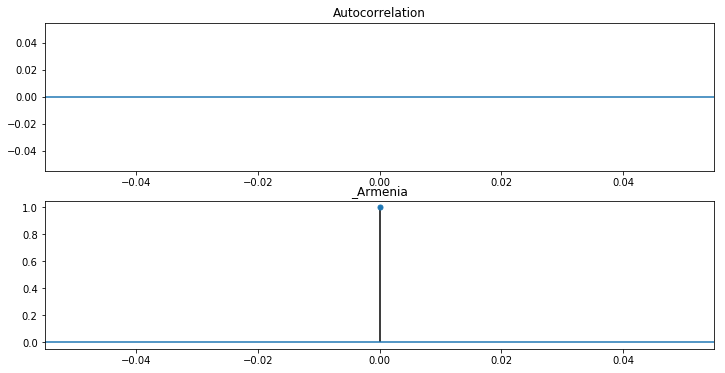

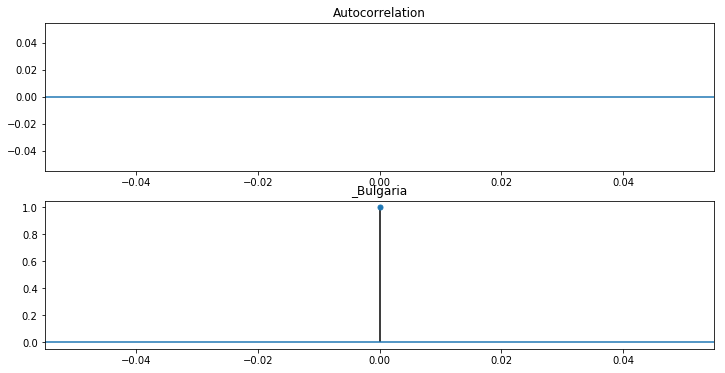

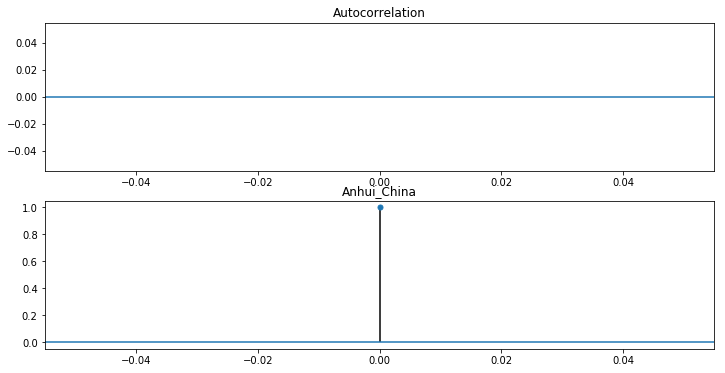

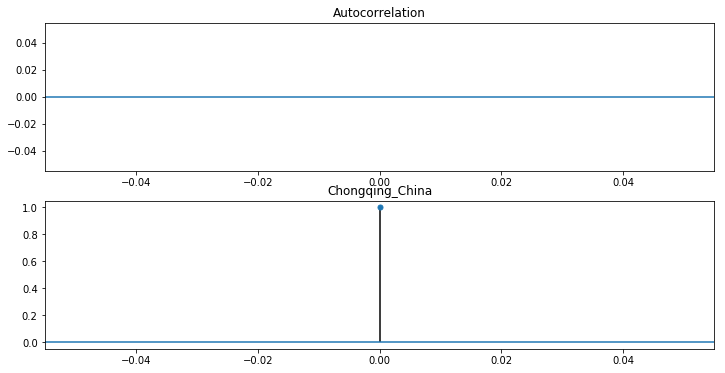

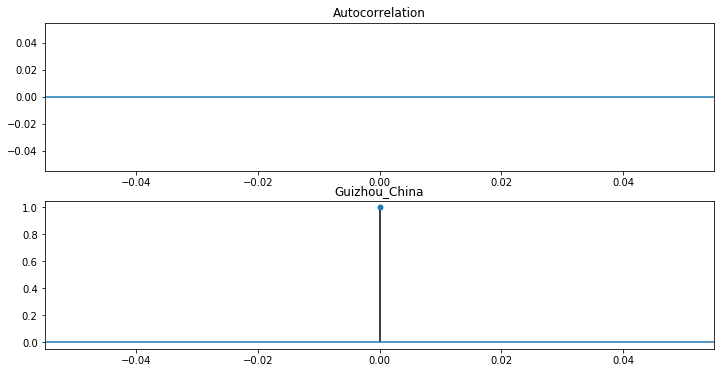

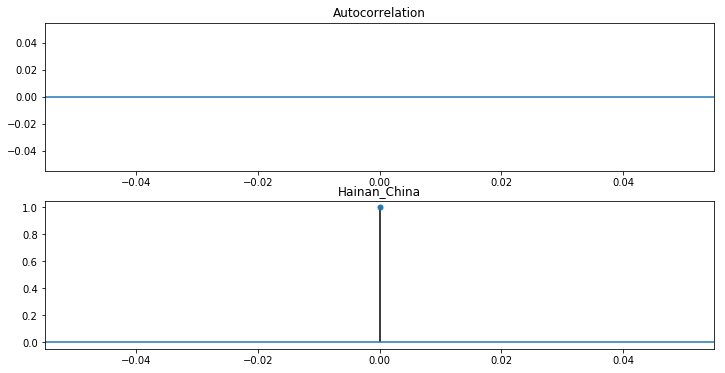

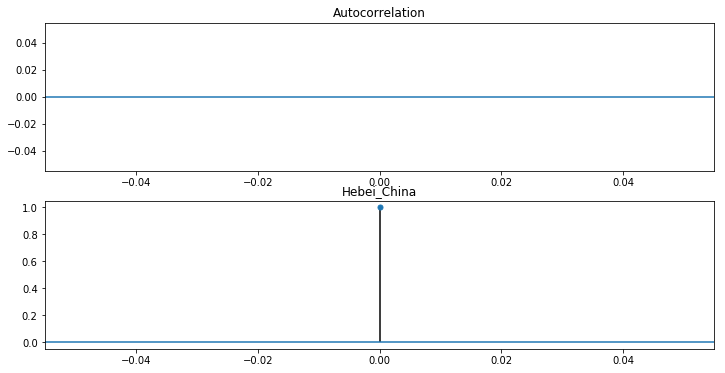

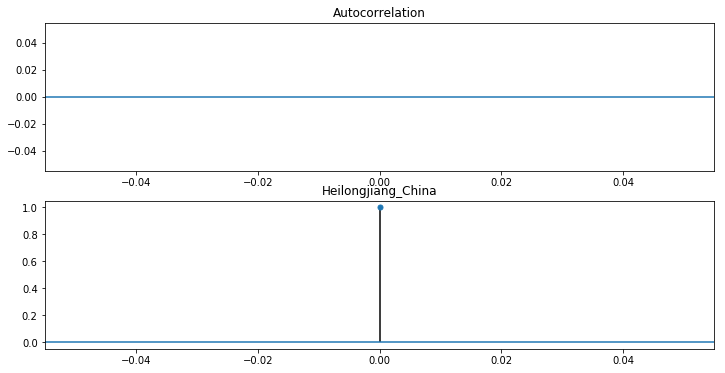

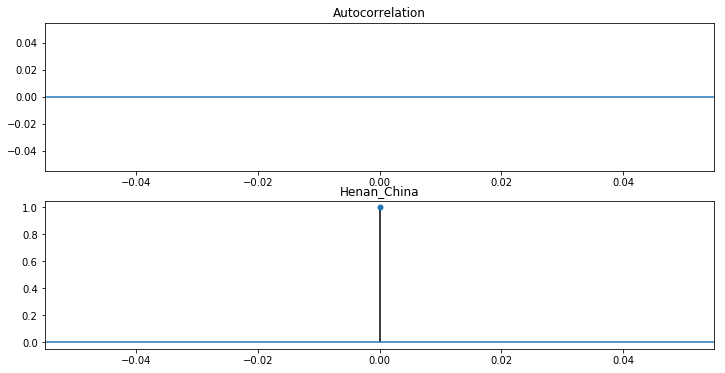

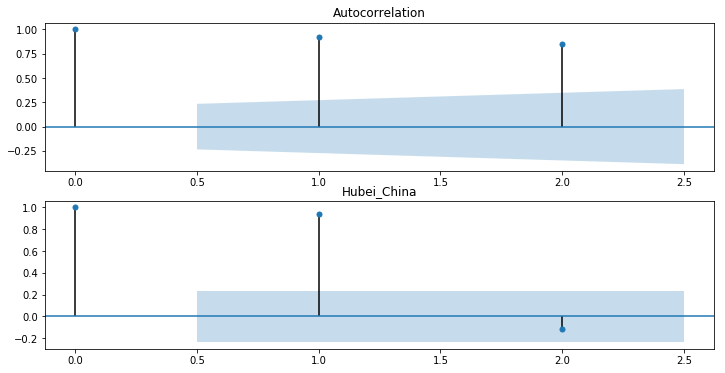

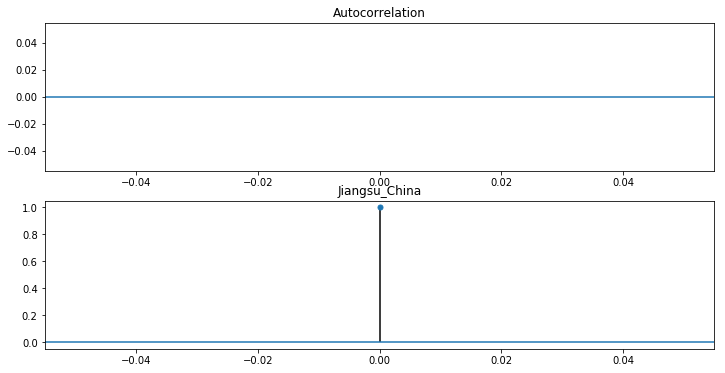

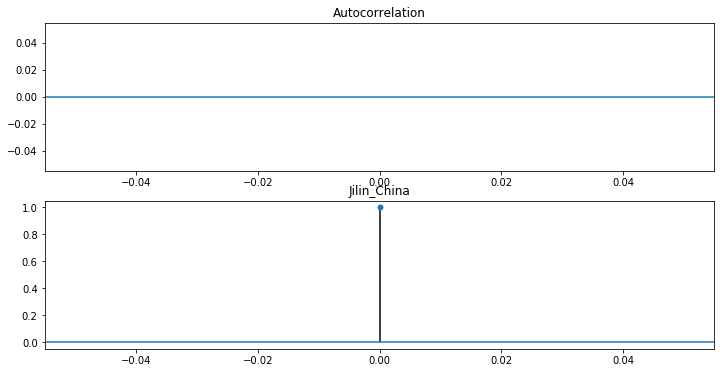

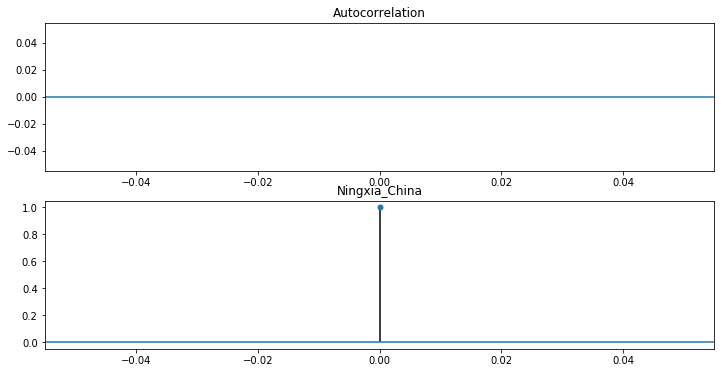

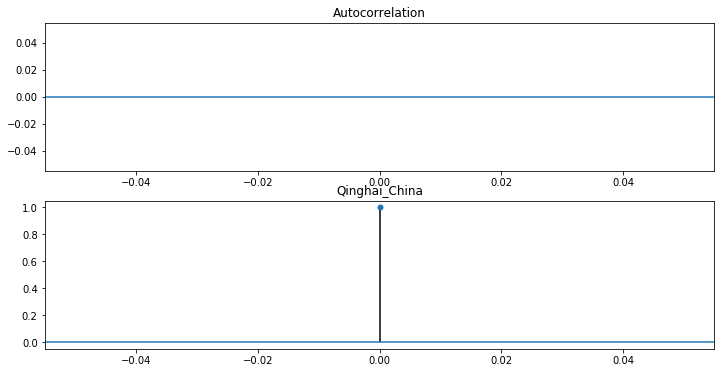

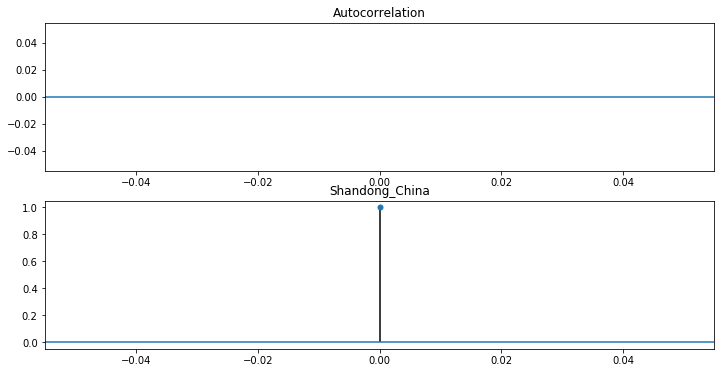

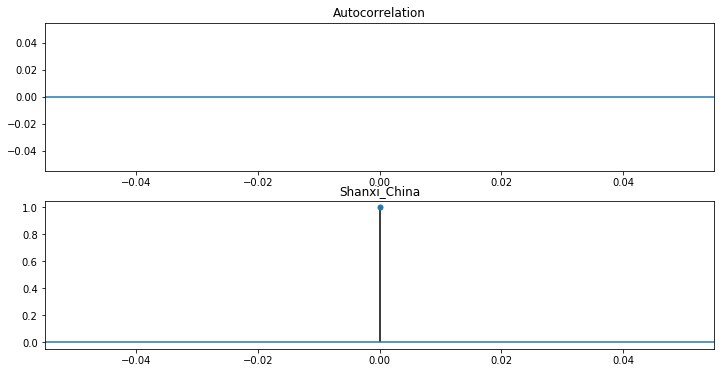

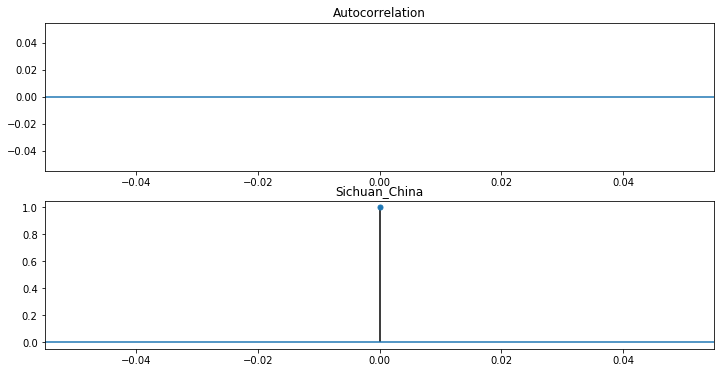

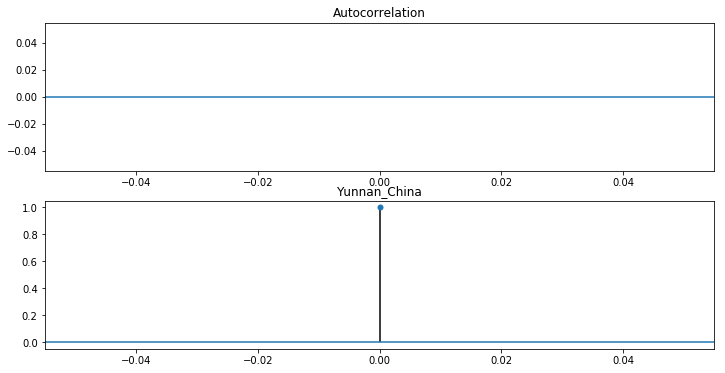

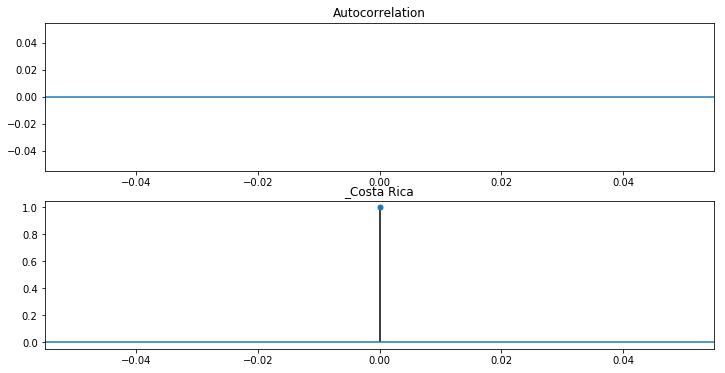

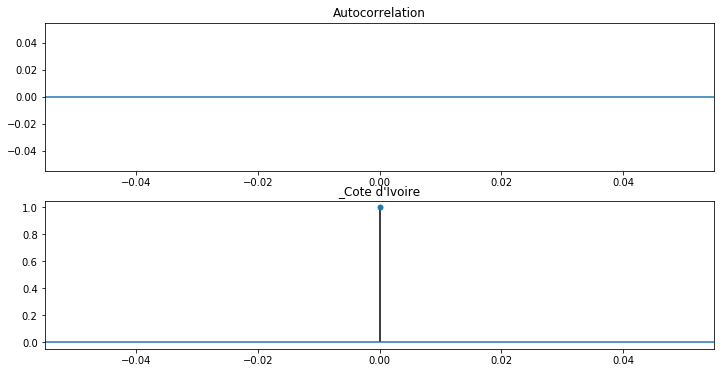

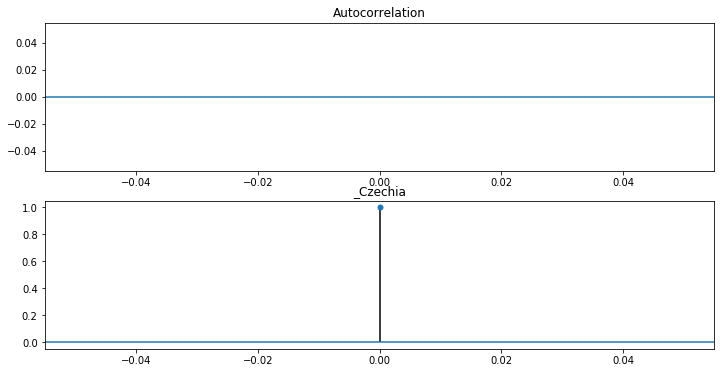

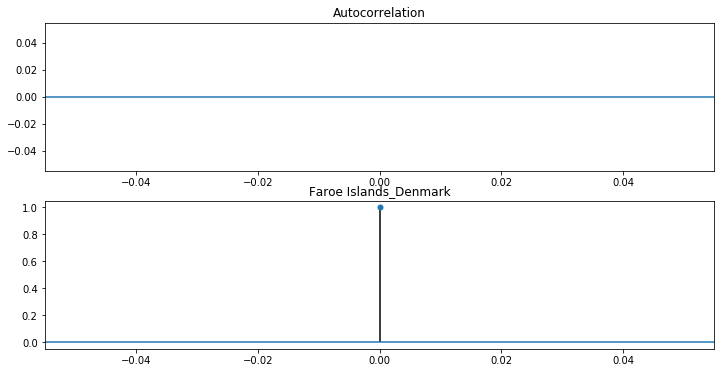

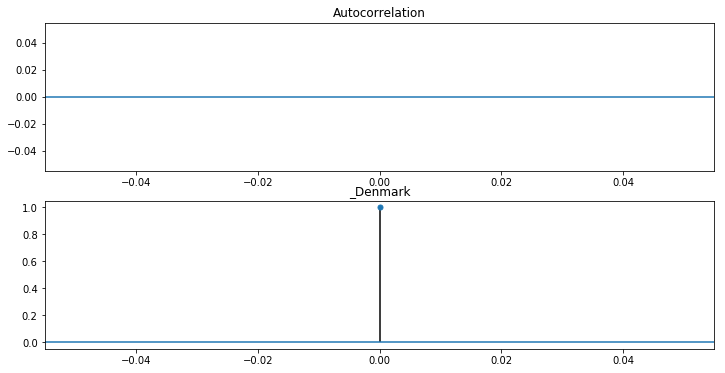

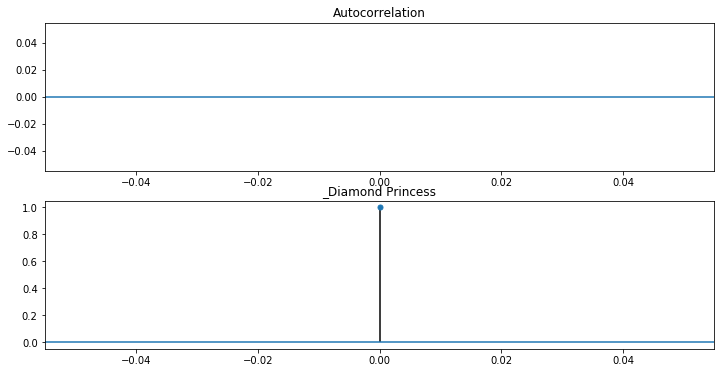

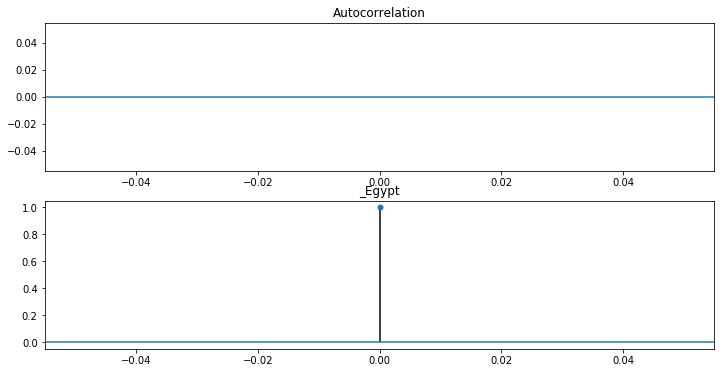

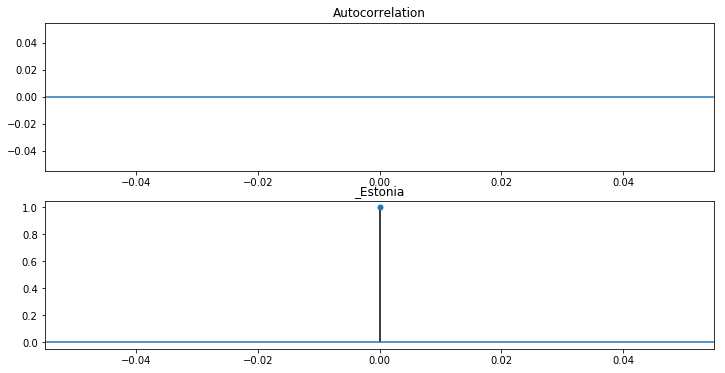

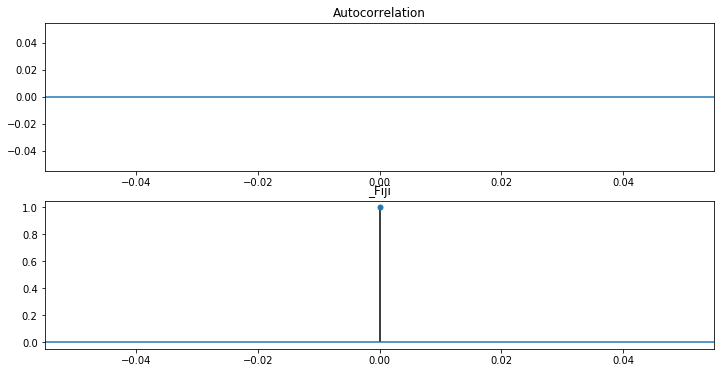

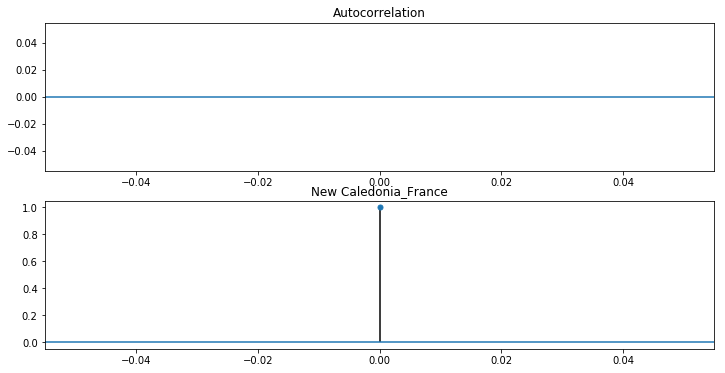

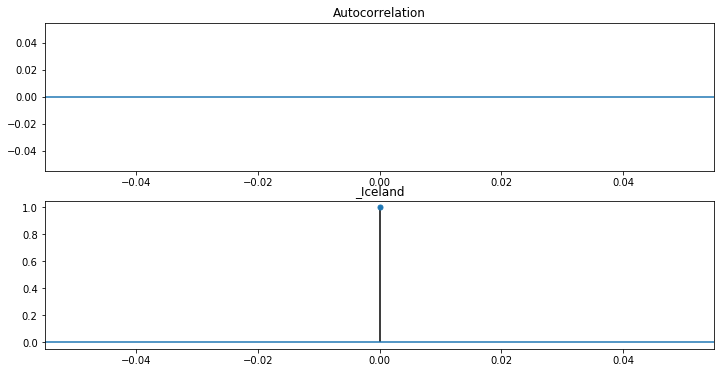

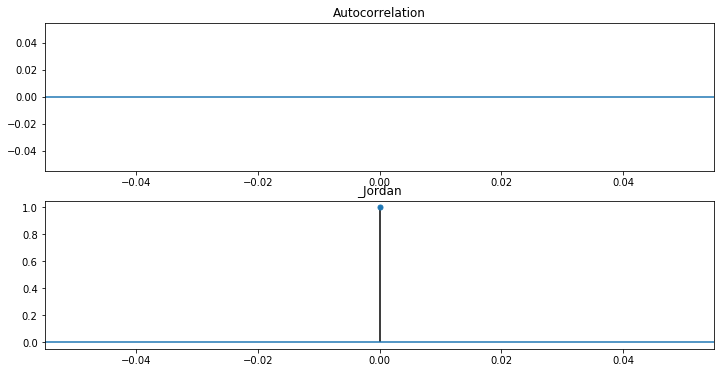

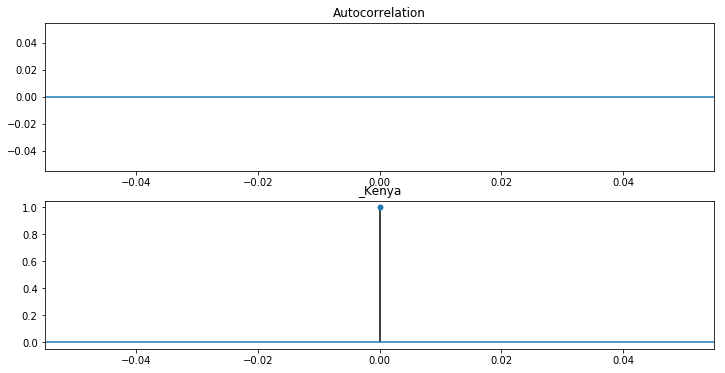

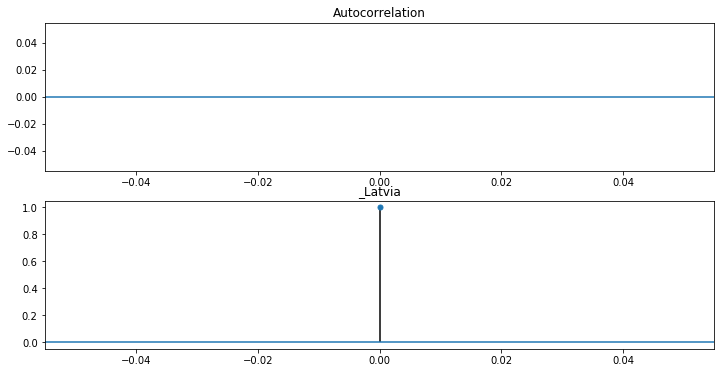

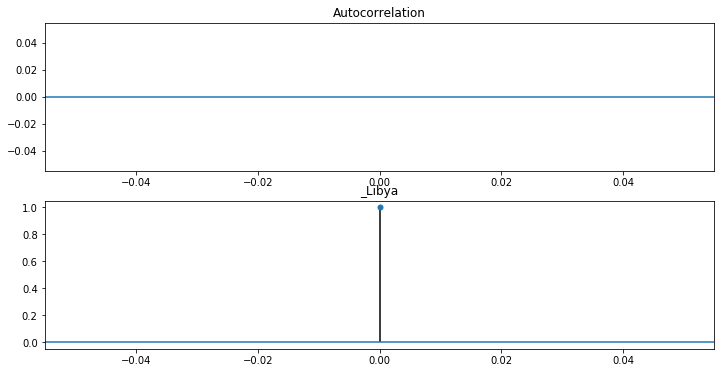

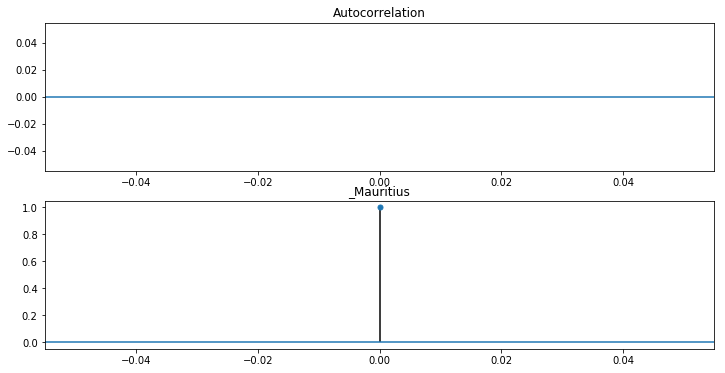

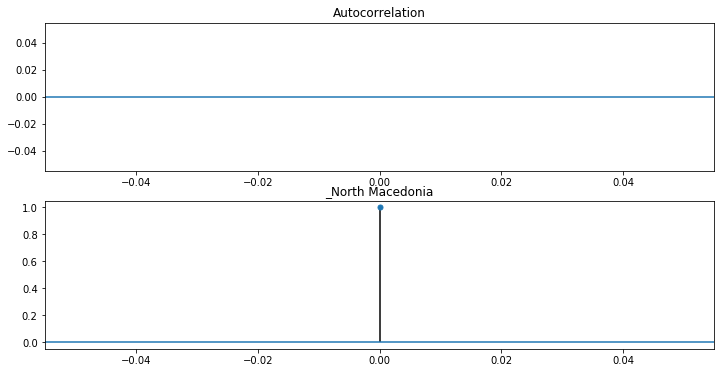

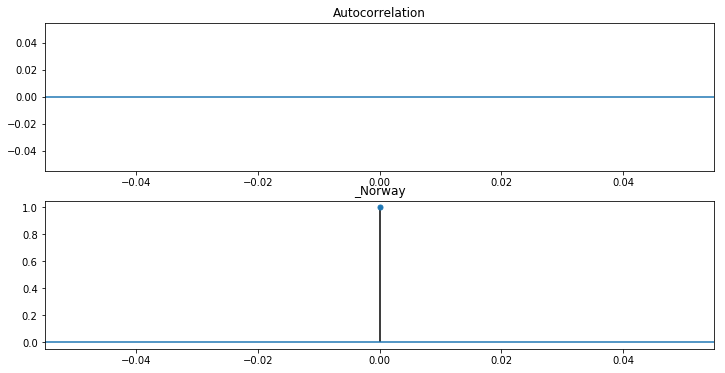

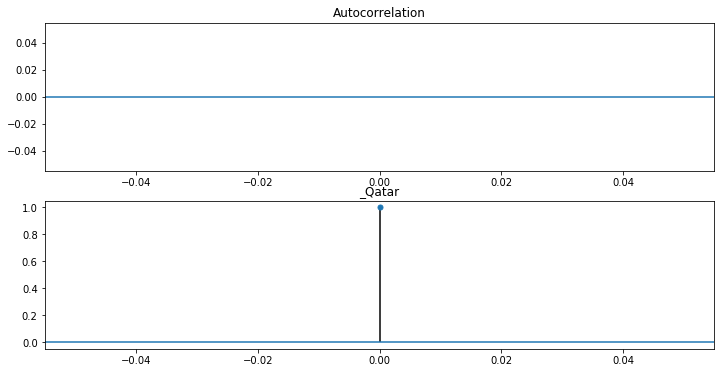

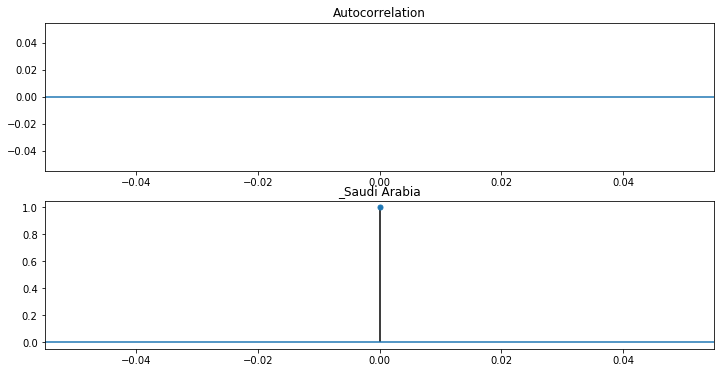

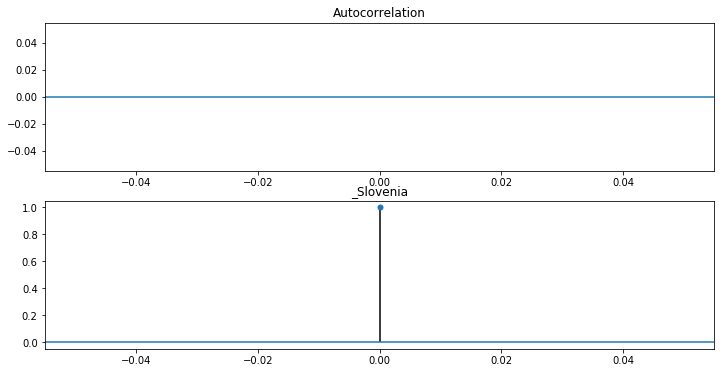

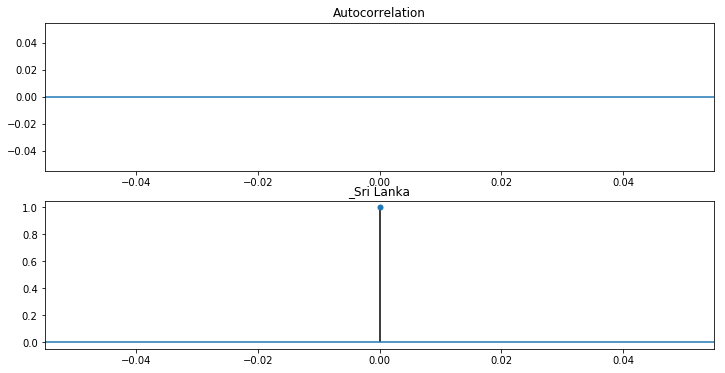

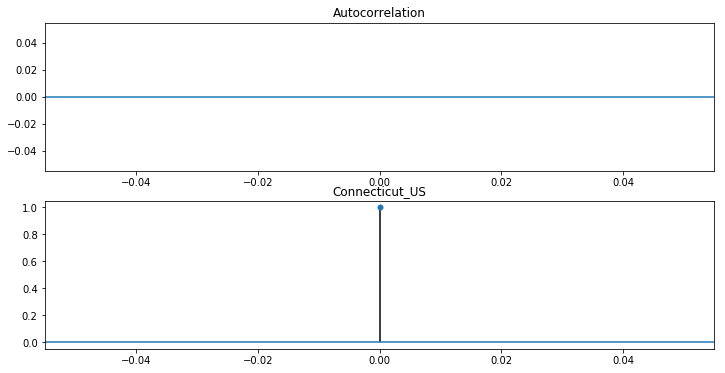

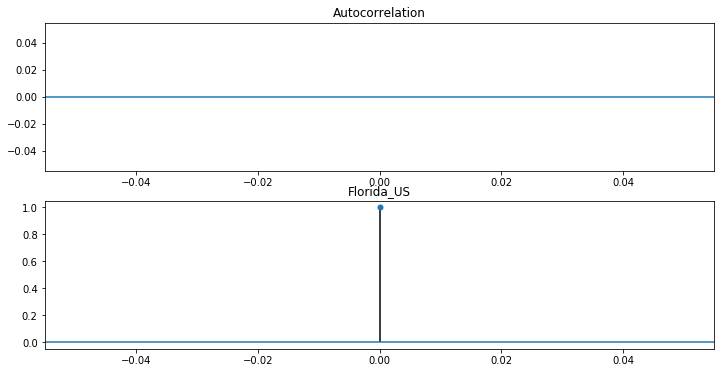

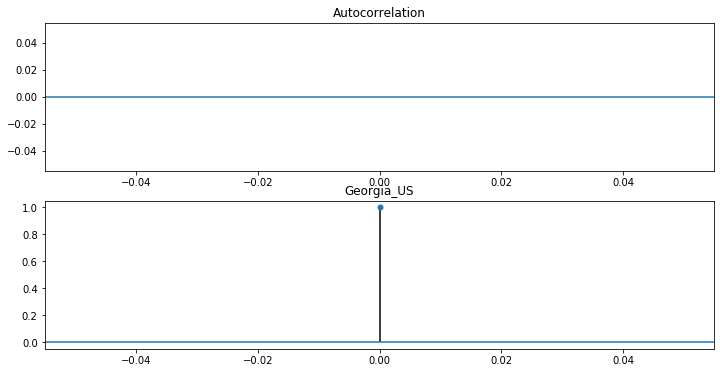

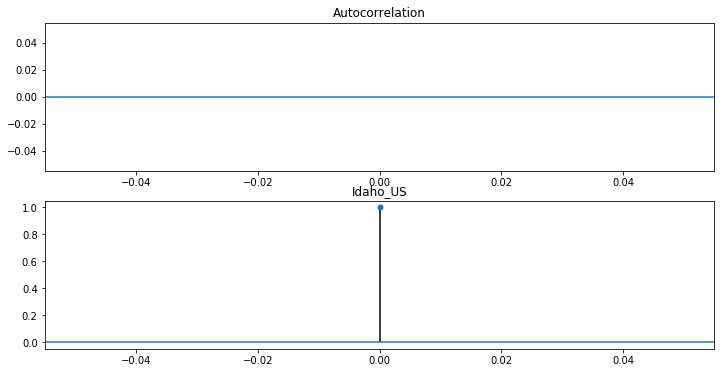

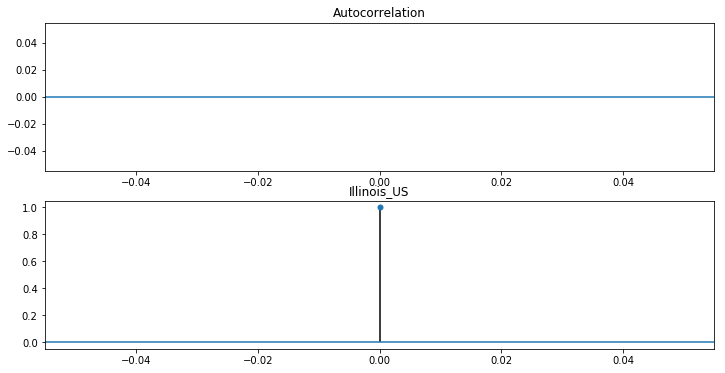

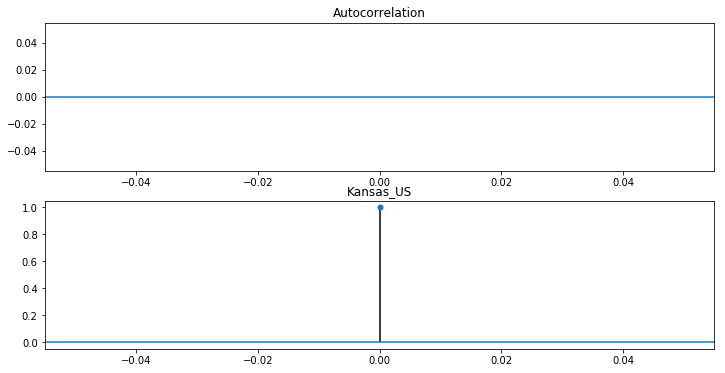

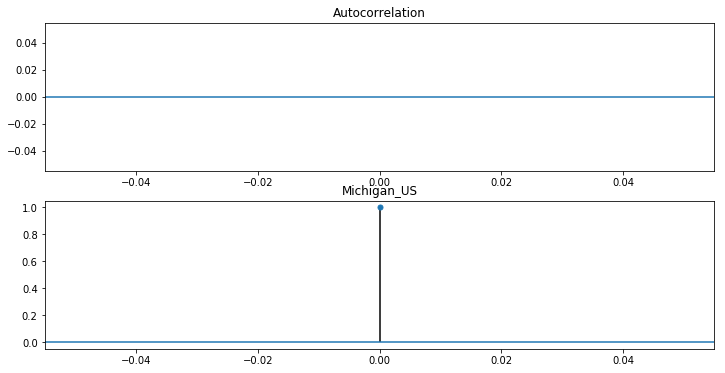

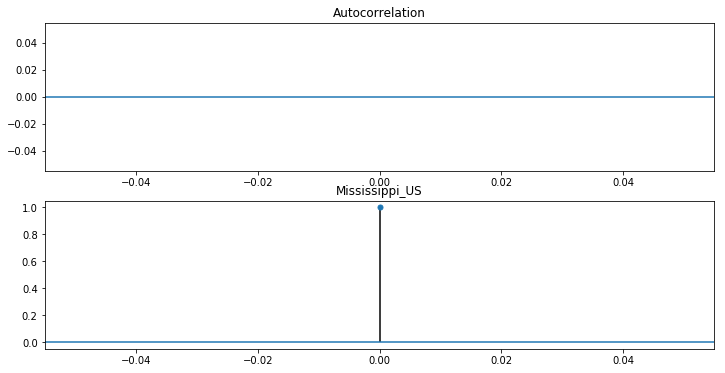

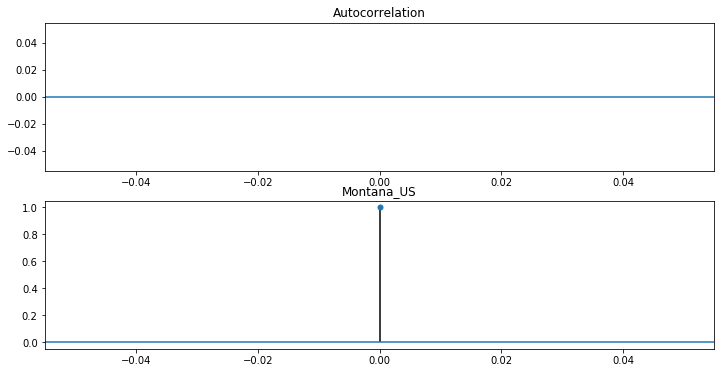

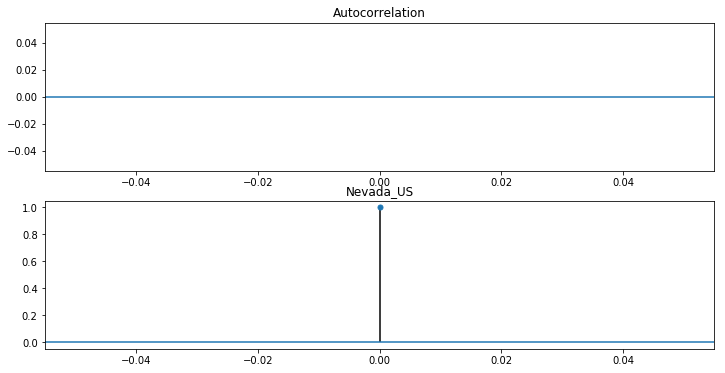

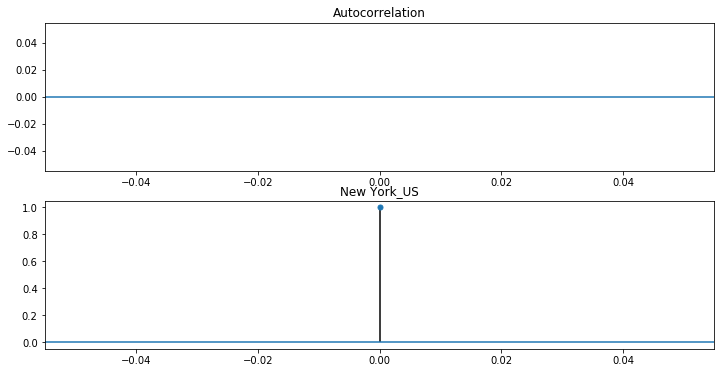

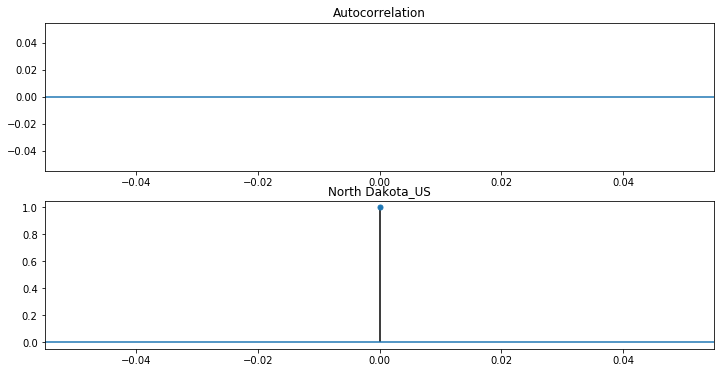

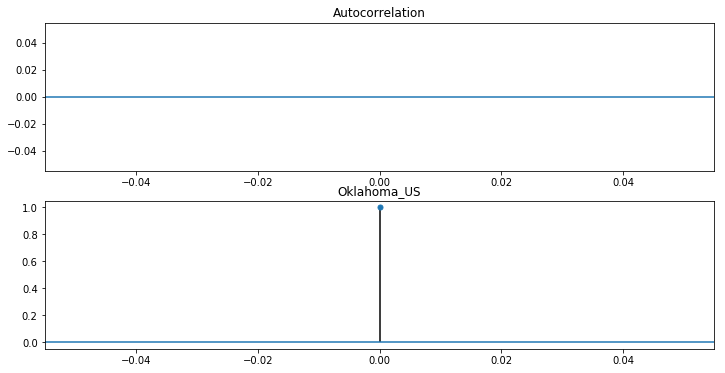

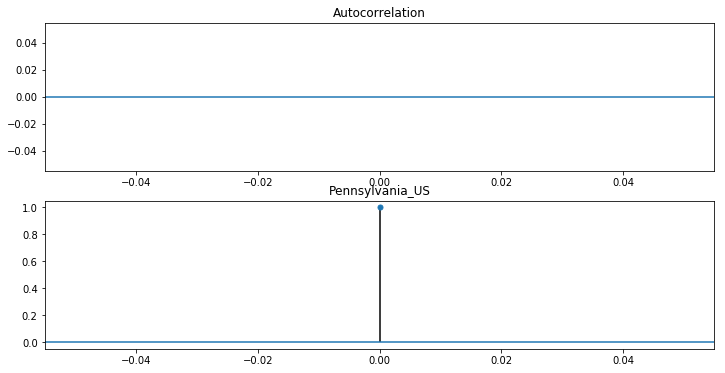

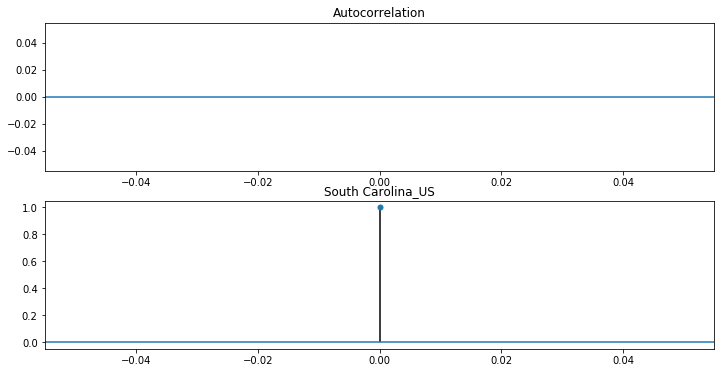

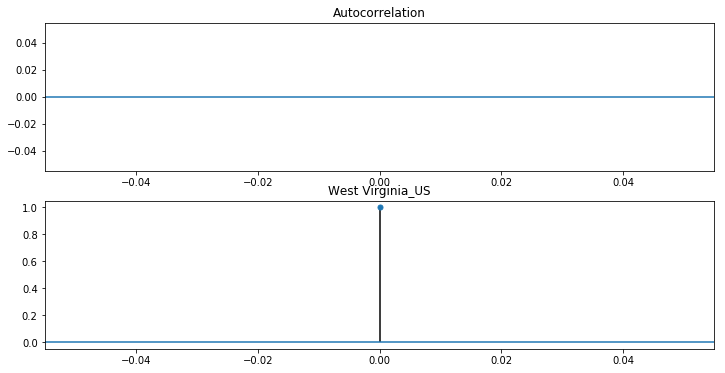

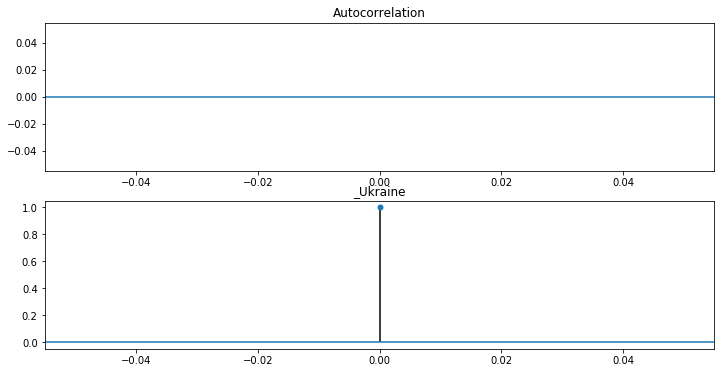

In [304]:
# ACF and PACF plots for Fatalities
for place in stationary_data:
    fig,ax = plt.subplots(2,figsize=(12,6))
    ax[0] = plot_acf(np.log(rolling_df[rolling_df['place']==place]['Fatalities']).dropna(), ax=ax[0], lags=2)
    ax[1] = plot_pacf(np.log(rolling_df[rolling_df['place']==place]['Fatalities']).dropna(), ax=ax[1], lags=2)
    plt.title('{}'.format(place))

In [305]:
# list of places with lags for Confirmed Cases
confirmedc_lag = ['Anhui_China', 'Chongqing_China','Guangdong_China',
                  'Guizhou_China', 'Hainan_China', 'Hebei_China','Hubei_China',
                 'Ningxia_China','Shandong_China','Shanxi_China', 'Sichuan_China']

In [306]:
# list of places with non-stationary confirmed cases data
allplaces = train_sub.place.unique().tolist()
non_stationary_data = [ele for ele in allplaces]

for place in confirmedc_lag:
    if place in allplaces:
        non_stationary_data.remove(place)

print(len(non_stationary_data))

283


In [307]:
# list of places with lags for Fatality
fatalities_lag = ['Hubei_China']

In [308]:
# list of places with non-stationary fatalities data
non_stationary_death_data = [ele for ele in allplaces]

for place in fatalities_lag:
    if place in allplaces:
        non_stationary_death_data.remove(place)

print(len(non_stationary_death_data))

293


In [309]:
from numpy import inf
train_sub['logConfirmedCases']= train_sub['logConfirmedCases'].replace(to_replace=-inf,
                                                                      value=0)

#### TRY POLYNOMIAL REGRESSION

In [310]:
poly_data = train[['date','place',
                  'ConfirmedCases','Fatalities']].merge(test[['date','place']], 
                                                      how='outer', 
                                                        on=['date','place']).sort_values(['place',
                                                                                          'date'])

print(poly_data.date.min(), test.date.min(), train.date.max(), poly_data.date.max())

2020-01-22 00:00:00 2020-03-19 00:00:00 2020-03-31 00:00:00 2020-04-30 00:00:00


In [311]:
# create label for each date by each place
label = []
for place in poly_data.place.unique():
    labelrange = range(1,len(poly_data[poly_data['place']==place])+1)
    label.append([i for i in labelrange])
lab = [item for lab in label for item in lab]
poly_data['label'] = lab
poly_data.head()

date       place  ConfirmedCases  Fatalities  label
15680 2020-01-22  Alabama_US             0.0         0.0      1
15681 2020-01-23  Alabama_US             0.0         0.0      2
15682 2020-01-24  Alabama_US             0.0         0.0      3
15683 2020-01-25  Alabama_US             0.0         0.0      4
15684 2020-01-26  Alabama_US             0.0         0.0      5

In [312]:
XYtrain = poly_data[(poly_data['date']>'2020-01-21')&((poly_data['date']<'2020-04-01'))]
print(XYtrain.date.min(), XYtrain.date.max(), XYtrain.isna().sum())

2020-01-22 00:00:00 2020-03-31 00:00:00 date              0
place             0
ConfirmedCases    0
Fatalities        0
label             0
dtype: int64


In [313]:
XYtest = poly_data[(poly_data['date']>'2020-03-18')&(poly_data['date']<'2020-05-01')]
print(XYtest.date.min(), XYtest.date.max(), XYtest.isna().sum())

2020-03-19 00:00:00 2020-04-30 00:00:00 date                 0
place                0
ConfirmedCases    8820
Fatalities        8820
label                0
dtype: int64


#### FOR CONFIRMED CASES

In [314]:
XYtrain['intercept']= -1

result=pd.DataFrame()
for place in poly_data.place.unique():
    for degree in [2,3,4,5,6]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        result = result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))
    
# if you want to look at the plot
        #plt.plot(features, y_pred, 
        #         label= "degree %d" % degree
        #         +';$RMSLE: %.2f' % RMSLE(y_pred, target))
    #plt.legend(loc='upper left')
    #plt.xlabel('date')
    #plt.ylabel('predictedcase')
    #plt.title("Polynomial model for confirmed cases in {}".format(place) )
    #plt.show()

In [315]:
best_degree = pd.DataFrame()
for place in result.place.unique():
    a = result[result['place']==place]
    best_degree = best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])
print(best_degree.groupby('degree')['place'].nunique())
print('Zero polynomial (no fit): ',best_degree[best_degree['RMSLE']<0.00001]['place'].unique())

degree
3      2
4     44
5     85
6    163
Name: place, dtype: int64
Zero polynomial (no fit):  []


In [316]:
fit_best_degree = best_degree[best_degree['RMSLE']>0.00001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
sdeg_places  = fit_best_degree[fit_best_degree['degree']==6]['place'].unique()
nofit_places1    = best_degree[best_degree['RMSLE']<0.00001]['place'].unique()
print(fit_best_degree.nunique())
print(len(twodeg_places), len(threedeg_places), 
      len(fourdeg_places), len(fivedeg_places), len(sdeg_places), len(nofit_places1))

place     294
degree      4
RMSLE     294
dtype: int64
0 2 44 85 163 0


#### Predict for Confirmed Cases

In [317]:
XYtest = XYtest.reset_index(drop=True)
XYtest['intercept'] = -1

In [318]:
poly_predicted_confirmedcases = pd.DataFrame() 
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(d)
    
for place in sdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(6), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    e = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(e)



#### For fatalities

In [319]:
fatalities_result=pd.DataFrame()
for place in poly_data.place.unique():
    for degree in [2,3,4,5,6]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['Fatalities']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        fatalities_result = fatalities_result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))

In [320]:
fat_best_degree = pd.DataFrame()
for place in fatalities_result.place.unique():
    a = fatalities_result[fatalities_result['place']==place]
    fat_best_degree = fat_best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])
print(fat_best_degree.groupby('degree')['place'].nunique())
print('Zero polynomial (no fit): ',
      fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique())

degree
2     76
3     76
4     89
5    115
6    242
Name: place, dtype: int64
Zero polynomial (no fit):  ['Aruba_Netherlands' 'Bermuda_United Kingdom' 'Faroe Islands_Denmark'
 'French Guiana_France' 'French Polynesia_France'
 'Gibraltar_United Kingdom' 'Greenland_Denmark'
 'Isle of Man_United Kingdom' 'Jiangsu_China' 'Macau_China'
 'Montserrat_United Kingdom' 'New Brunswick_Canada' 'New Caledonia_France'
 'Ningxia_China' 'Northern Territory_Australia' 'Nova Scotia_Canada'
 'Prince Edward Island_Canada' 'Qinghai_China' 'Reunion_France'
 'Saint Barthelemy_France' 'Shanxi_China' 'Sint Maarten_Netherlands'
 'South Australia_Australia' 'Tibet_China' 'Virgin Islands_US'
 'Wyoming_US' '_Antigua and Barbuda' '_Bahamas' '_Barbados' '_Belize'
 '_Benin' '_Bhutan' '_Cambodia' '_Central African Republic' '_Chad'
 '_Congo (Brazzaville)' '_Djibouti' '_Dominica' '_Equatorial Guinea'
 '_Eritrea' '_Eswatini' '_Ethiopia' '_Fiji' '_Georgia' '_Grenada'
 '_Guinea' '_Guinea-Bissau' '_Haiti' '_Holy See' '_Kuw

In [321]:
fit_best_degree = fat_best_degree[fat_best_degree['RMSLE']>0.000001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
sevdeg_places  = fit_best_degree[fit_best_degree['degree']==6]['place'].unique()
nofit_places2    = fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique()
print(fit_best_degree.nunique())
print(len(twodeg_places), len(threedeg_places), 
      len(fourdeg_places), len(fivedeg_places), len(sevdeg_places), len(nofit_places2))

place     218
degree      3
RMSLE     199
dtype: int64
0 0 13 39 166 76


In [322]:
poly_predicted_fatalities = pd.DataFrame() 
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(d)

for place in sevdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(6), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    e = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(e)

In [323]:
# forward fill no fit places for confirmed cases
for place in nofit_places1:
    e = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-18')]
    f = e['ConfirmedCases'].fillna(method = 'ffill')
    g = pd.DataFrame(zip(e['place'], f),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(g)

# forward fill no fit places for fatalities
for place in nofit_places2:
    h = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-18')]
    i = h['Fatalities'].fillna(method = 'ffill')
    j = pd.DataFrame(zip(h['place'], i),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(j)

In [324]:
print(poly_predicted_confirmedcases.shape, poly_predicted_fatalities.shape)

(12642, 2) (12642, 2)


#### Compiling results

In [325]:
poly_predicted_confirmedcases2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_confirmedcases['place'].tolist(),
                                              'ConfirmedCases':poly_predicted_confirmedcases['ConfirmedCases'].tolist()})
poly_predicted_confirmedcases2.head()

date        place  ConfirmedCases
0 2020-03-19  _Bangladesh       18.638930
1 2020-03-20  _Bangladesh       20.947644
2 2020-03-21  _Bangladesh       23.409828
3 2020-03-22  _Bangladesh       26.029908
4 2020-03-23  _Bangladesh       28.812312

In [326]:
poly_predicted_confirmedcases2.shape

(12642, 3)

In [327]:
poly_predicted_fatalities2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_fatalities['place'].tolist(),
                                              'Fatalities':poly_predicted_fatalities['Fatalities'].tolist()})
poly_predicted_fatalities2.head()

date        place  Fatalities
0 2020-03-19  Anhui_China    5.543167
1 2020-03-20  Anhui_China    5.494623
2 2020-03-21  Anhui_China    5.464230
3 2020-03-22  Anhui_China    5.455249
4 2020-03-23  Anhui_China    5.471078

In [328]:
poly_predicted_fatalities2.shape

(12642, 3)

In [329]:
poly_compiled = poly_predicted_confirmedcases2.merge(poly_predicted_fatalities2, how='inner', on=['place','date'])

In [330]:
test_poly_compiled= test.merge(poly_compiled, how='inner', on=['place','date'])
test_poly_compiled= test_poly_compiled.set_index('date')
test_poly_compiled

ForecastId state      country         place  ConfirmedCases  \
date                                                                      
2020-03-19           1   NaN  Afghanistan  _Afghanistan       25.893563   
2020-03-20           2   NaN  Afghanistan  _Afghanistan       31.169347   
2020-03-21           3   NaN  Afghanistan  _Afghanistan       37.344465   
2020-03-22           4   NaN  Afghanistan  _Afghanistan       44.534303   
2020-03-23           5   NaN  Afghanistan  _Afghanistan       52.864511   
...                ...   ...          ...           ...             ...   
2020-04-26       12638   NaN     Zimbabwe     _Zimbabwe      105.121467   
2020-04-27       12639   NaN     Zimbabwe     _Zimbabwe      113.069665   
2020-04-28       12640   NaN     Zimbabwe     _Zimbabwe      121.480310   
2020-04-29       12641   NaN     Zimbabwe     _Zimbabwe      130.372877   
2020-04-30       12642   NaN     Zimbabwe     _Zimbabwe      139.767369   

            Fatalities  
date                    
2020-03-19    0.452035  
2020-03-20    0.618346  
2020-03-21    0.813616  
2020-03-22    1.040808  
2020-03-23    1.303060  
...                ...  
2020-04-26   10.549436  
2020-04-27   11.202878  
2020-04-28   11.885386  
2020-04-29   12.597788  
2020-04-30   13.340926  

[12642 rows x 6 columns]

In [331]:
df_compiled = pd.DataFrame()
for place in test_poly_compiled.place.unique():
        a = test_poly_compiled[test_poly_compiled['place']==place]
        ind_max_confirmedcases = np.argmax(a['ConfirmedCases'])
        a = a.replace(to_replace=a.loc[(a.index>ind_max_confirmedcases),'ConfirmedCases'].tolist(),
                      value=a.loc[ind_max_confirmedcases,'ConfirmedCases'])
        
        ind_max_fatatities     = np.argmax(a['Fatalities'])
        a = a.replace(to_replace=a.loc[(a.index>ind_max_fatatities),'Fatalities'].tolist(),
                      value=a.loc[ind_max_fatatities,'Fatalities'])
        df_compiled = df_compiled.append(a)

df_compiled[df_compiled['place']=='_Zimbabwe'].tail()

ForecastId state   country      place  ConfirmedCases  Fatalities
date                                                                         
2020-04-26       12638   NaN  Zimbabwe  _Zimbabwe      105.121467   10.549436
2020-04-27       12639   NaN  Zimbabwe  _Zimbabwe      113.069665   11.202878
2020-04-28       12640   NaN  Zimbabwe  _Zimbabwe      121.480310   11.885386
2020-04-29       12641   NaN  Zimbabwe  _Zimbabwe      130.372877   12.597788
2020-04-30       12642   NaN  Zimbabwe  _Zimbabwe      139.767369   13.340926

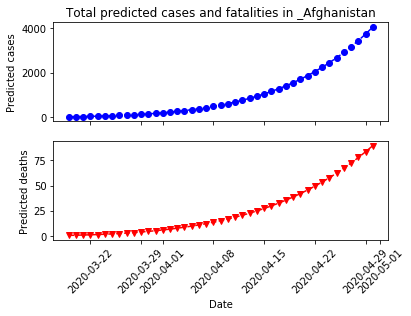

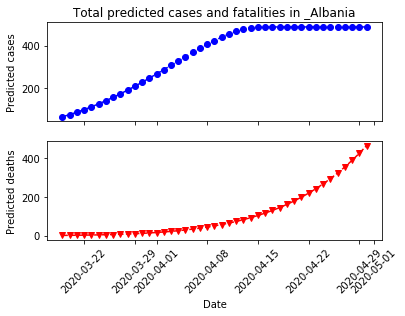

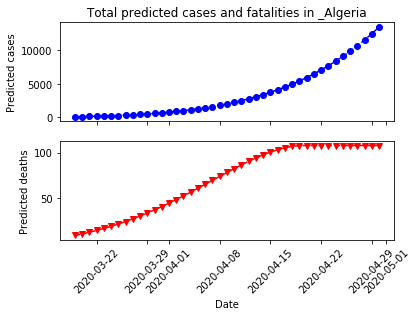

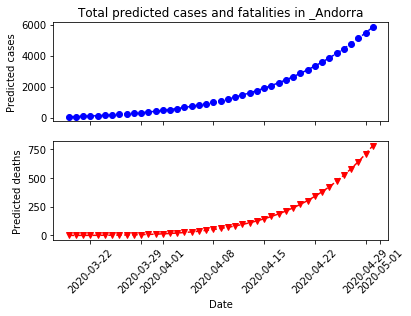

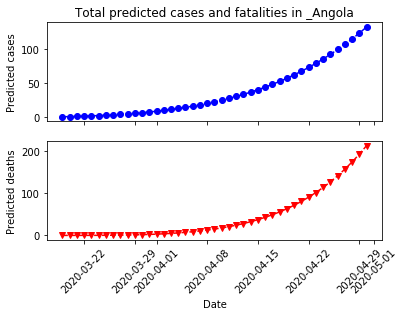

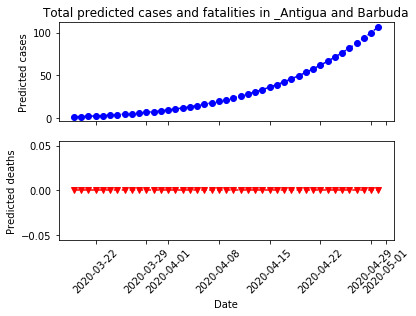

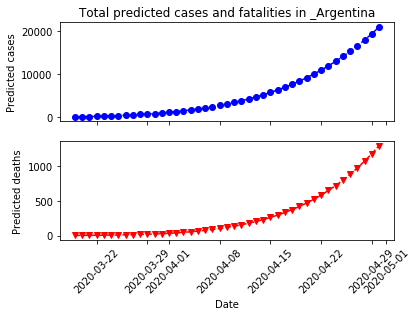

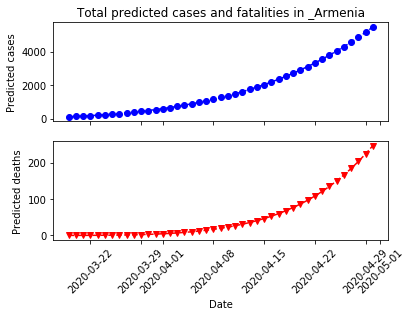

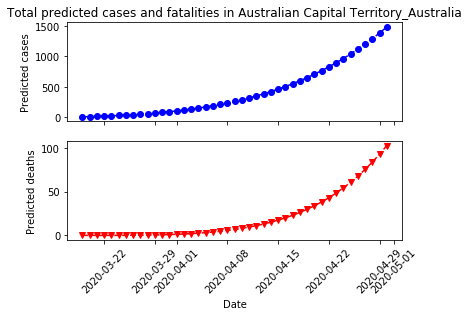

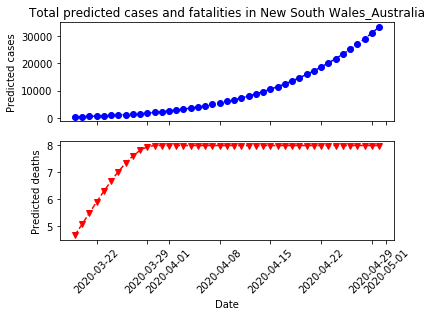

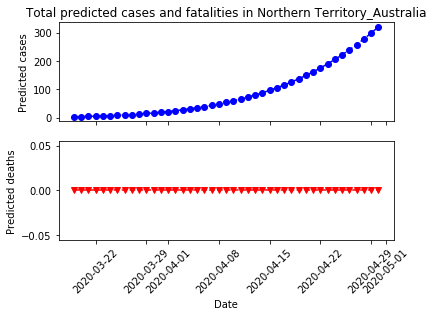

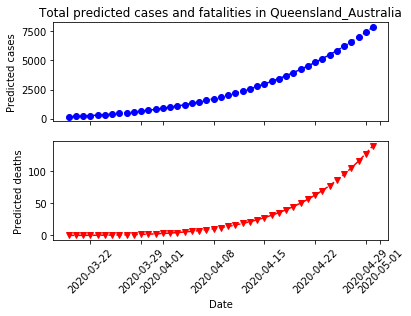

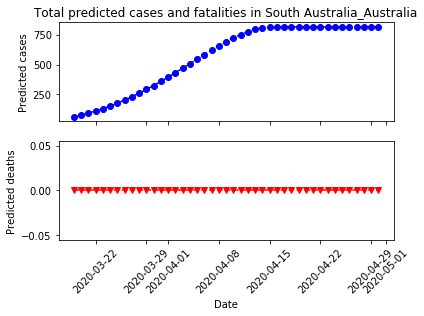

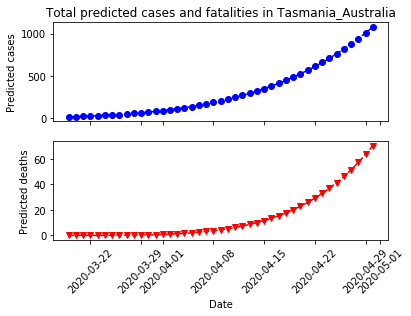

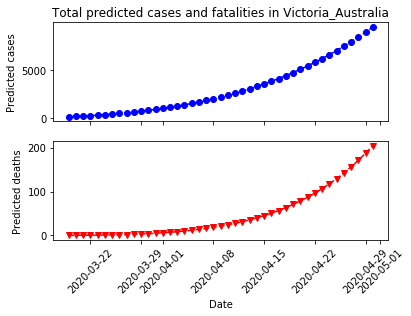

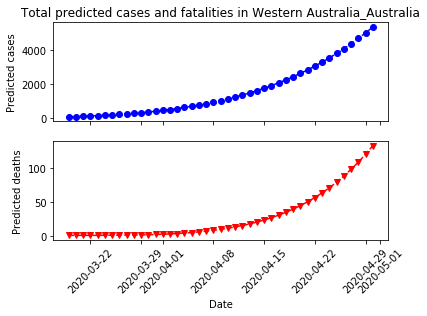

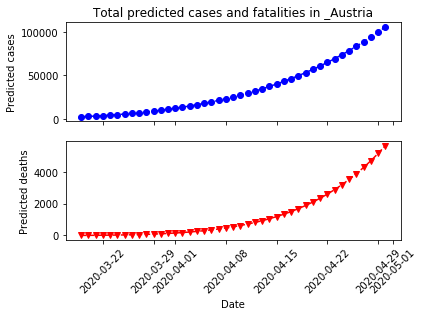

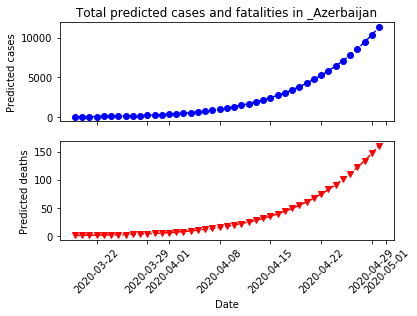

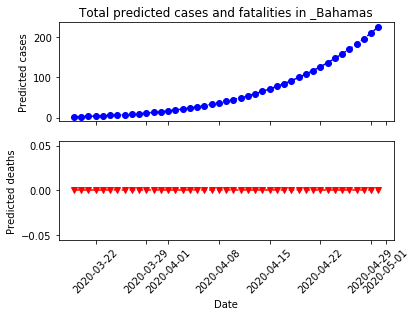

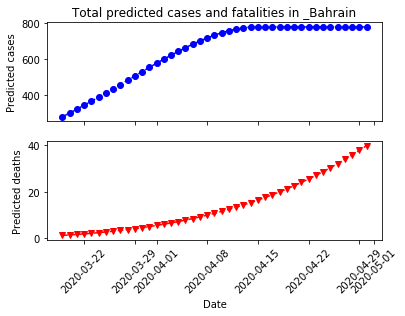

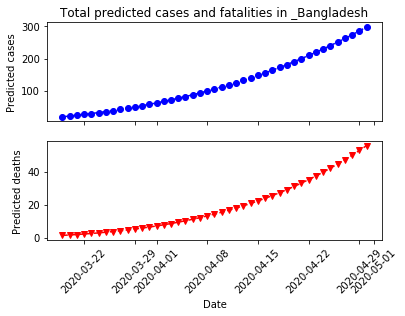

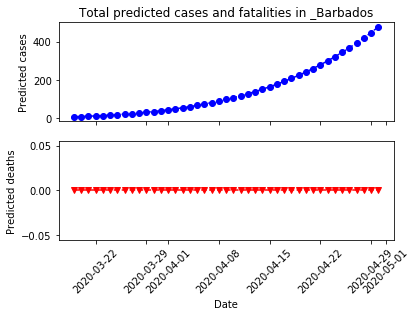

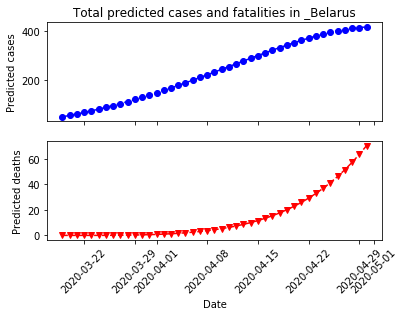

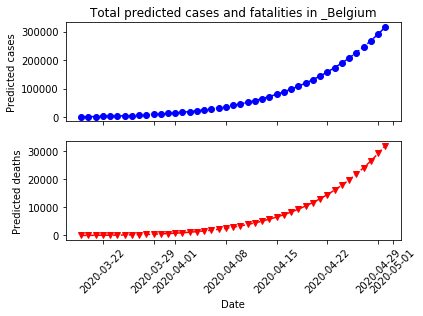

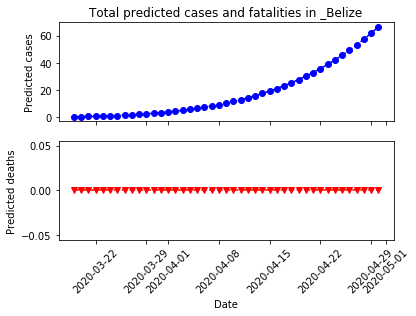

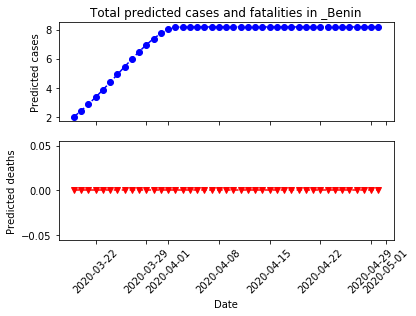

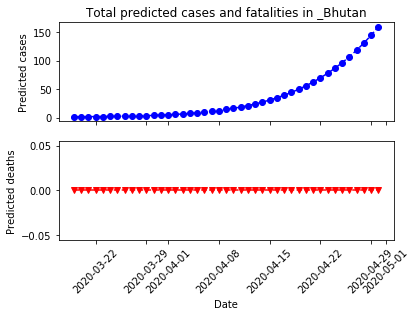

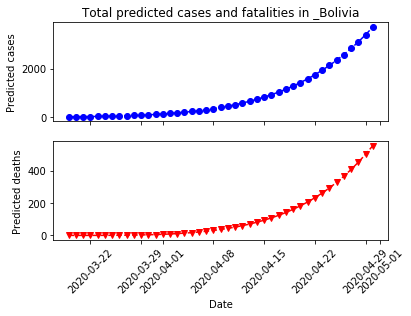

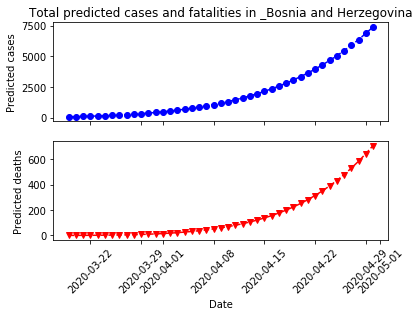

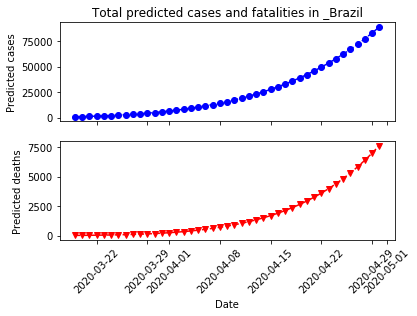

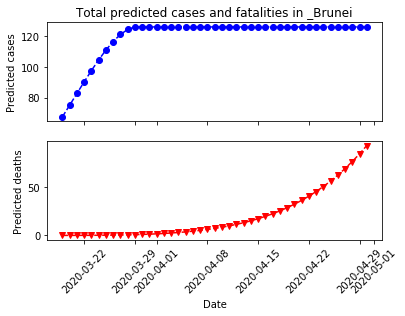

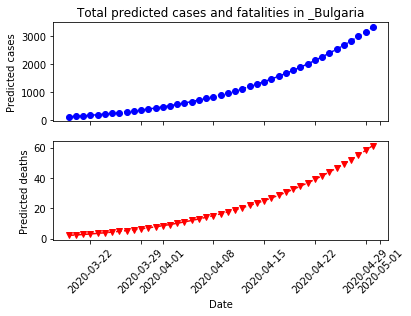

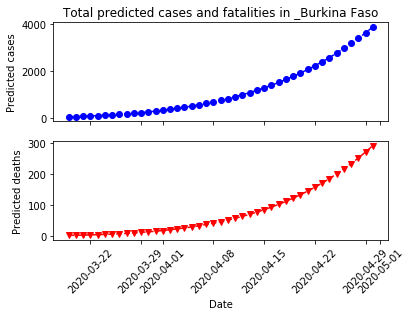

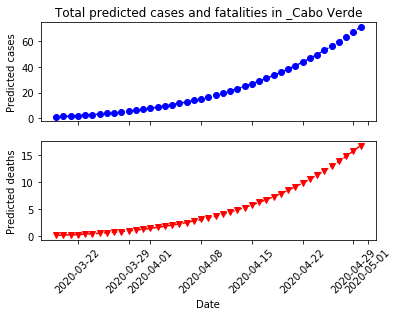

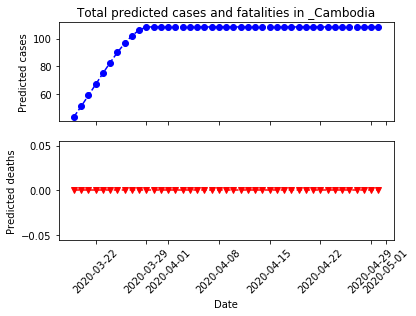

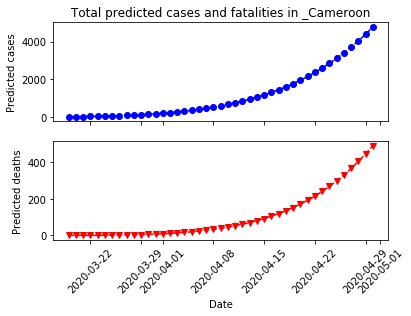

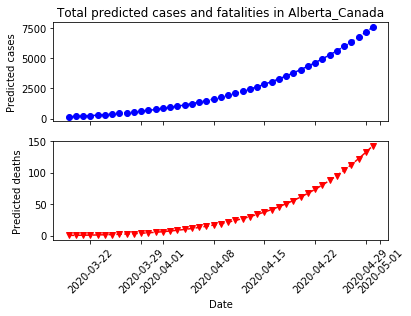

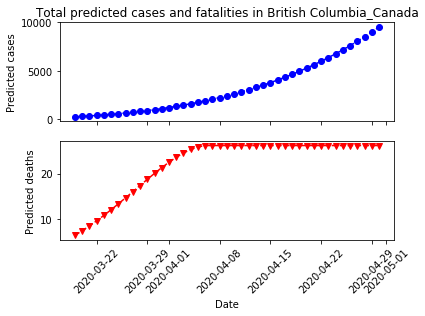

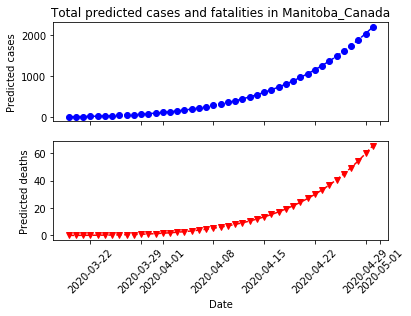

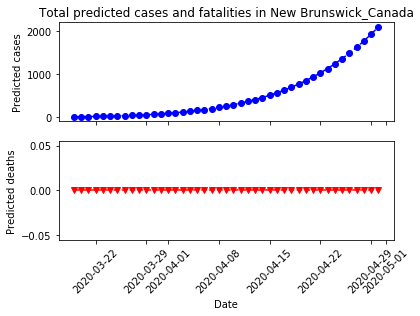

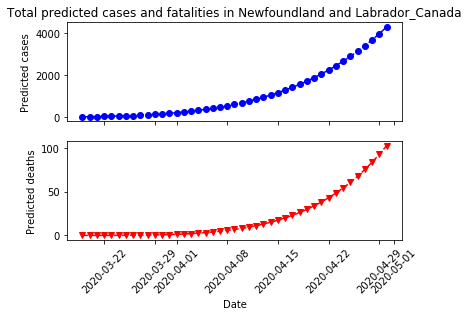

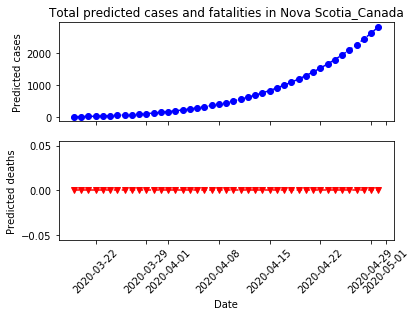

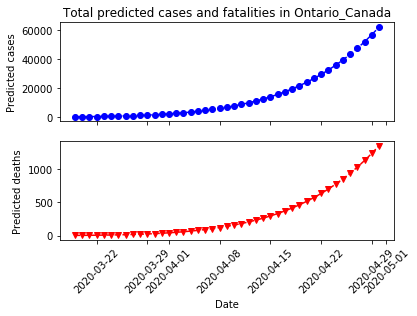

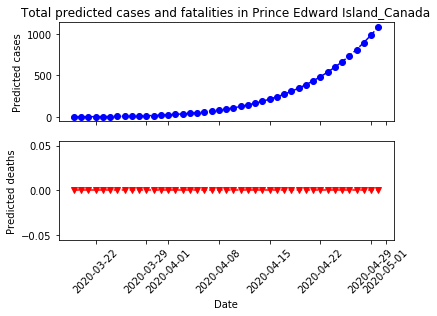

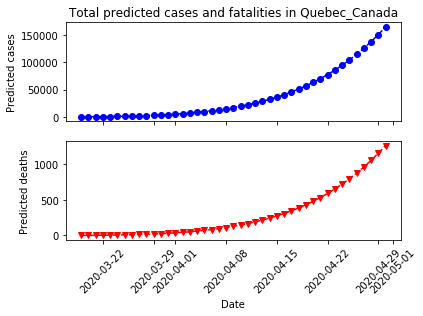

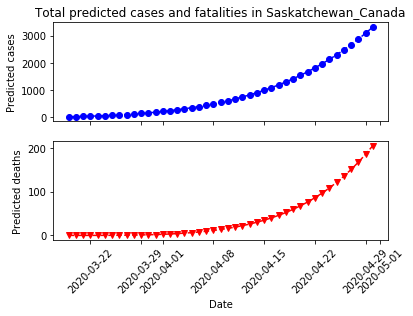

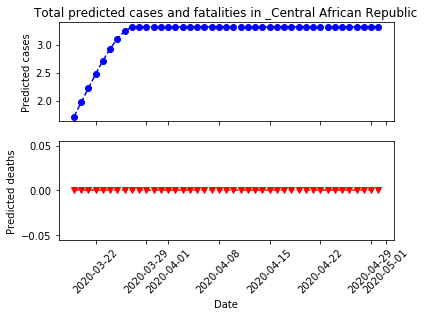

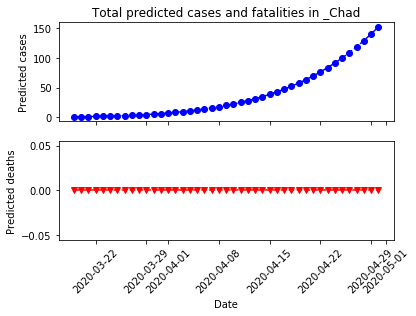

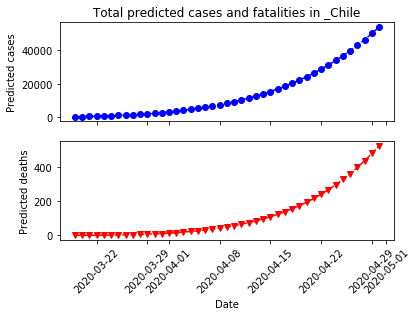

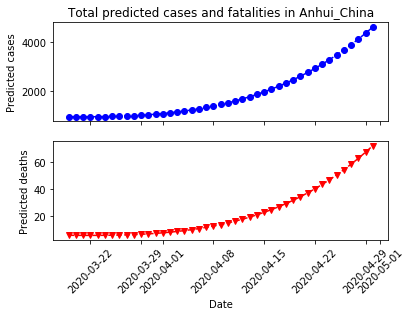

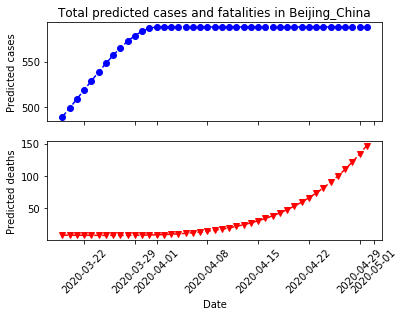

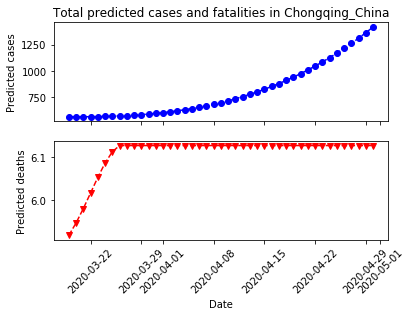

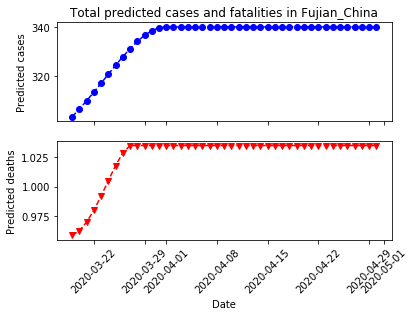

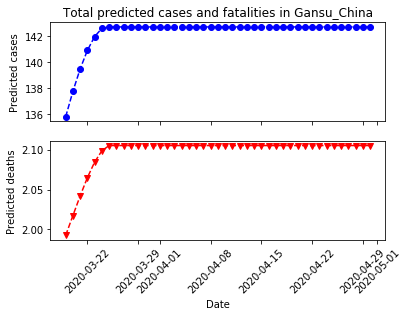

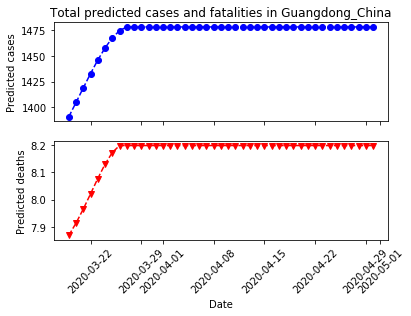

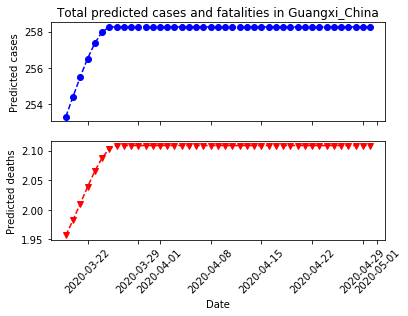

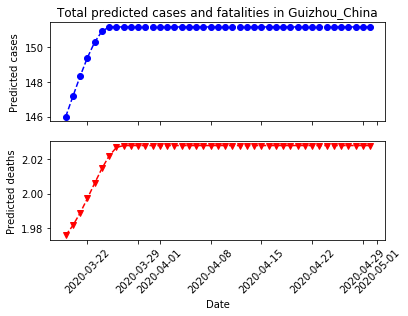

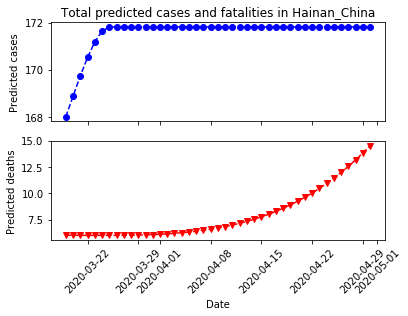

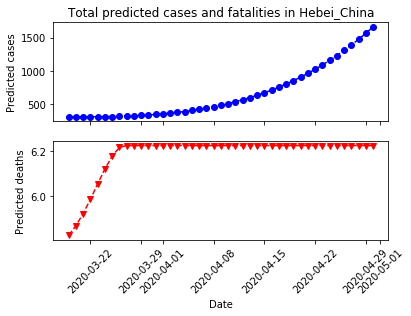

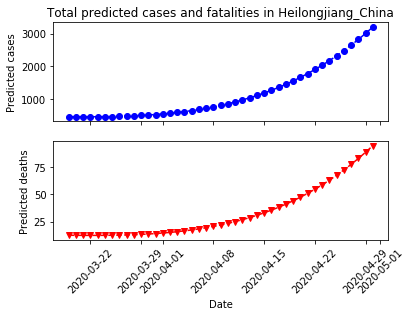

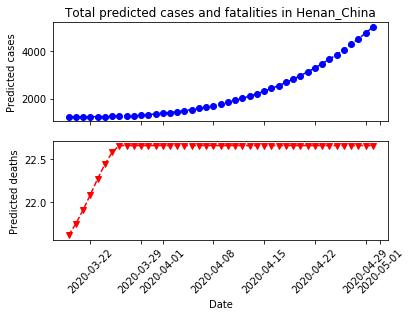

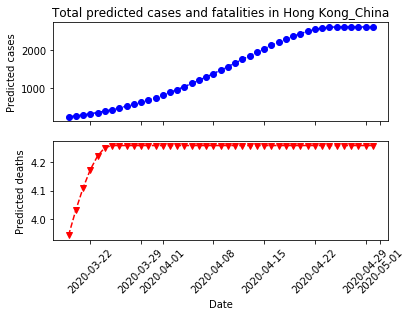

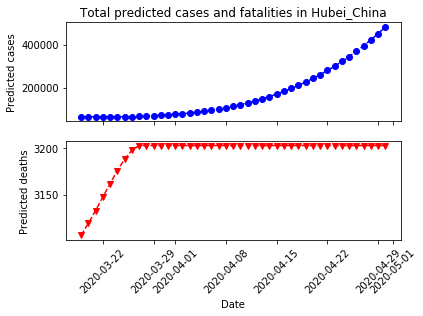

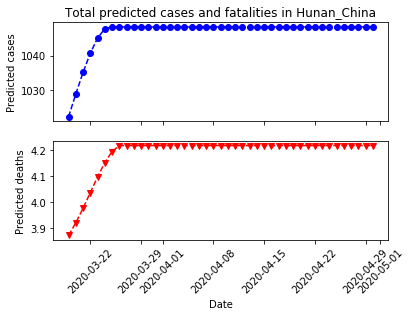

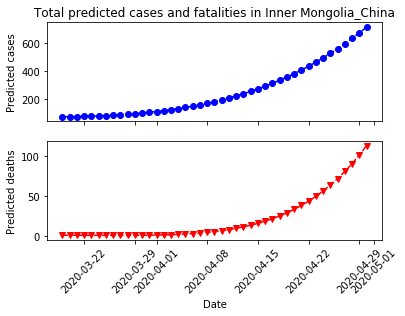

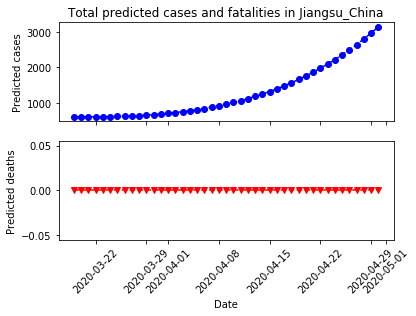

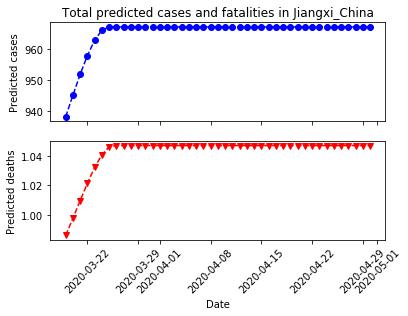

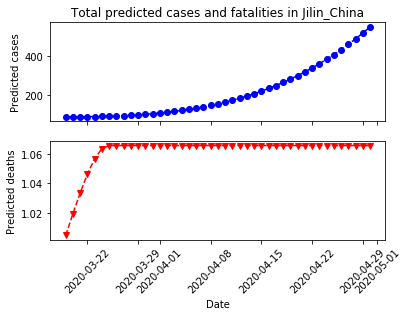

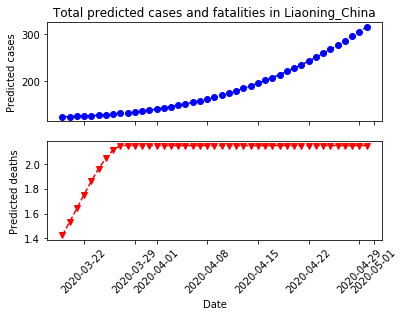

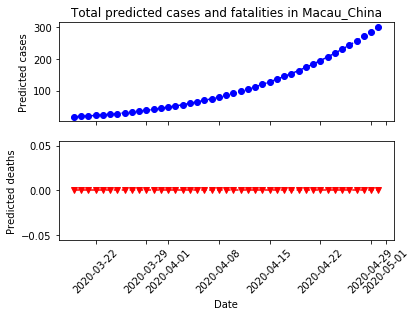

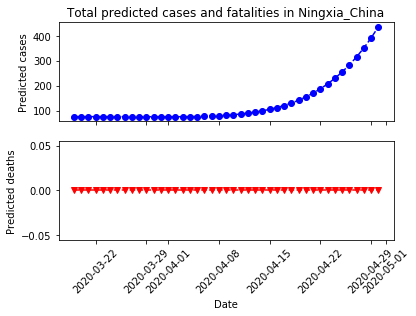

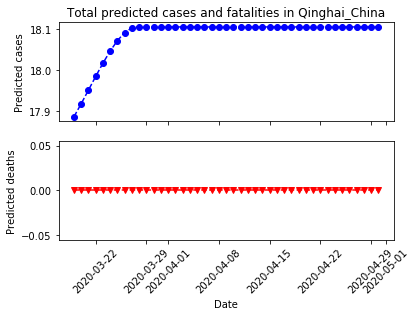

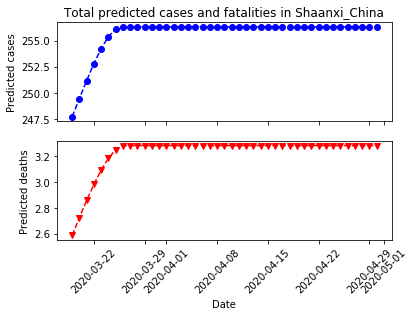

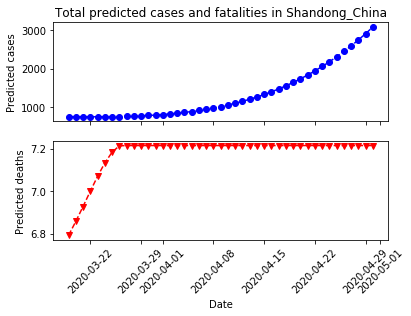

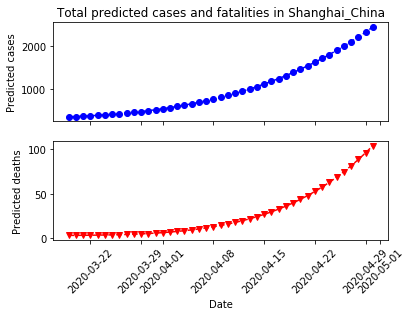

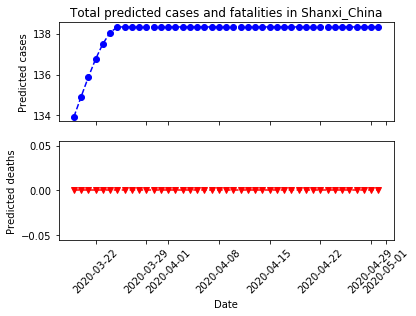

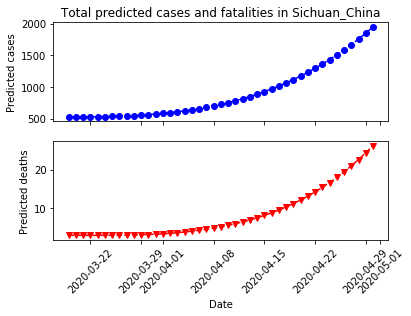

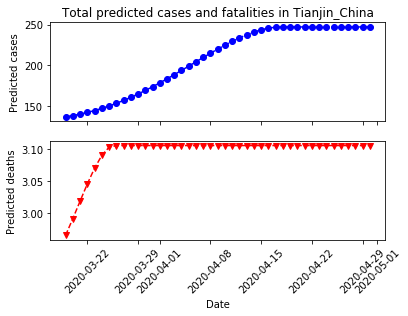

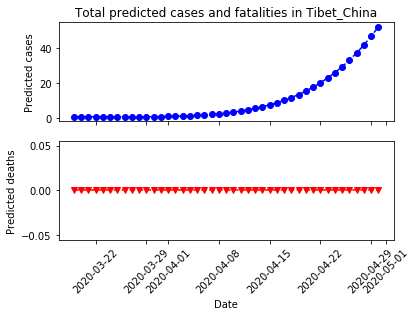

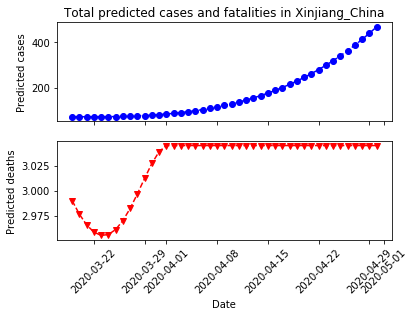

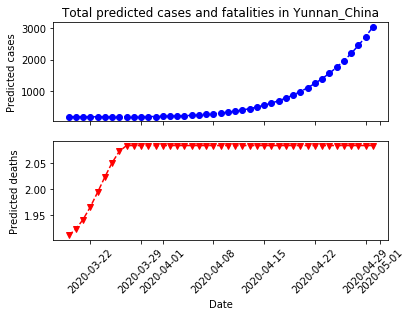

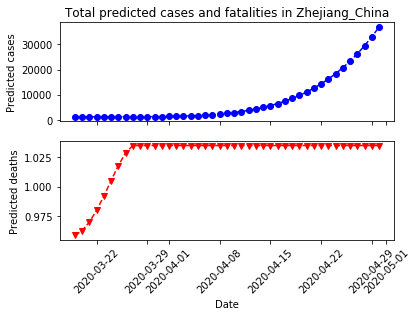

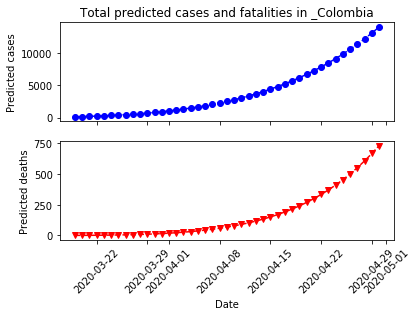

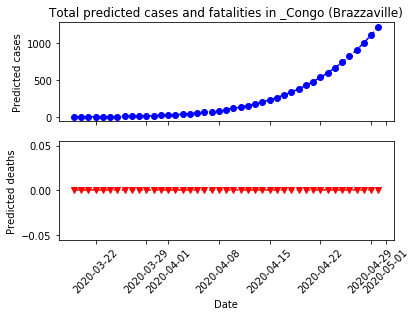

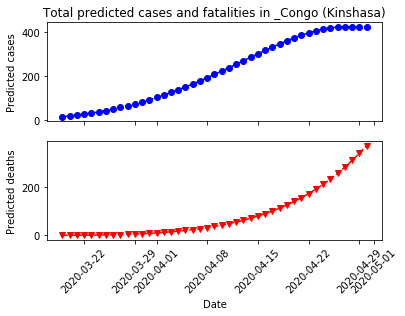

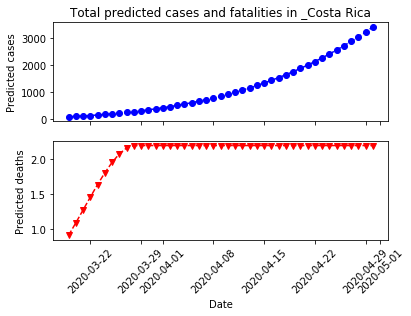

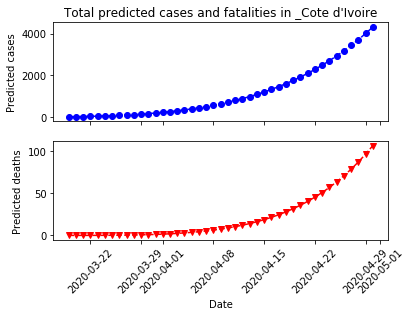

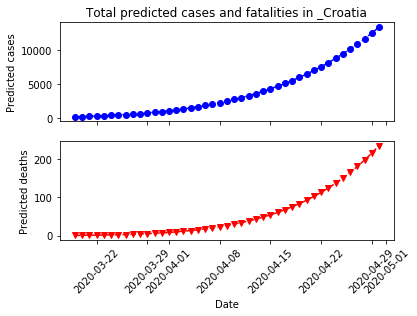

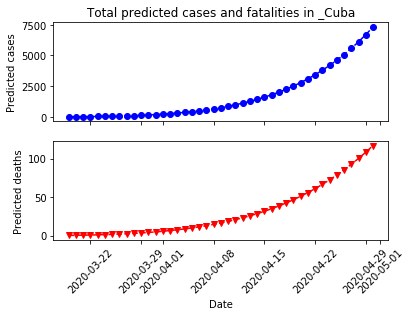

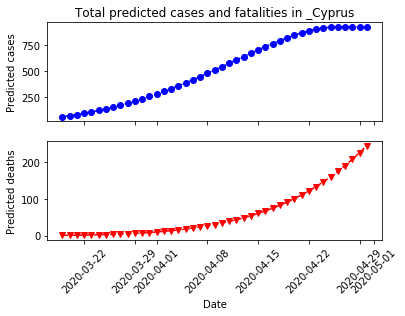

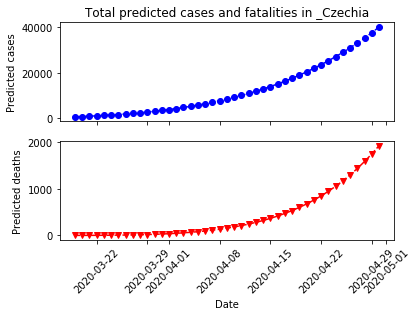

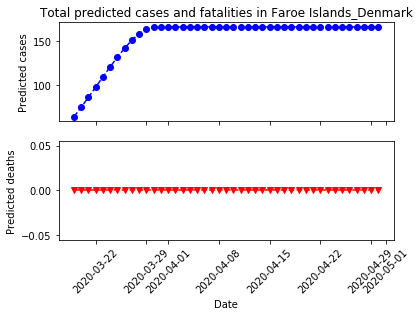

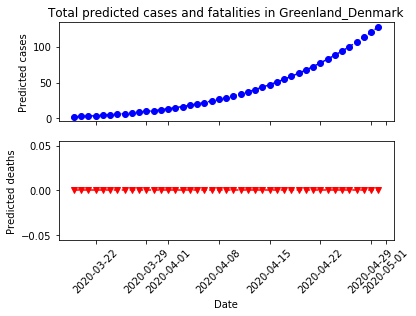

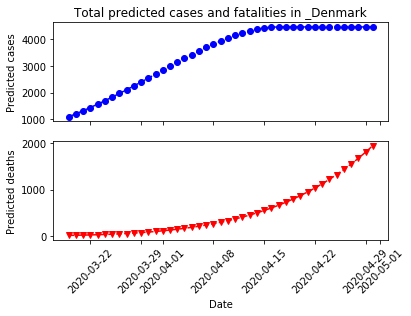

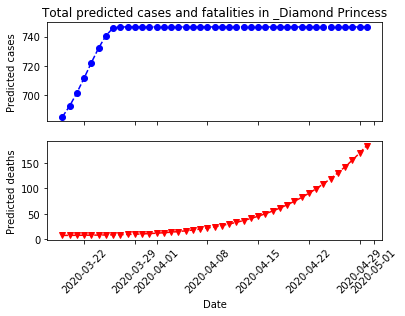

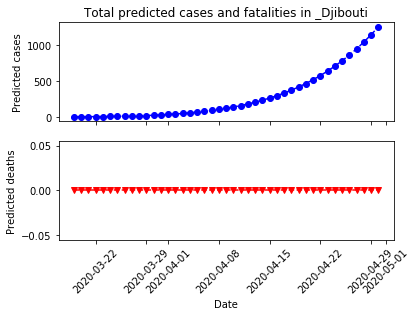

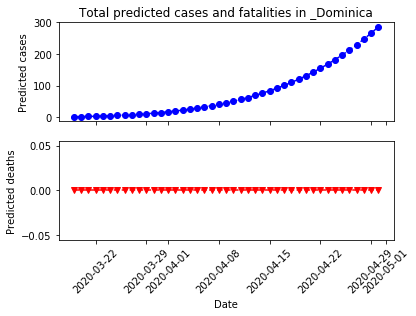

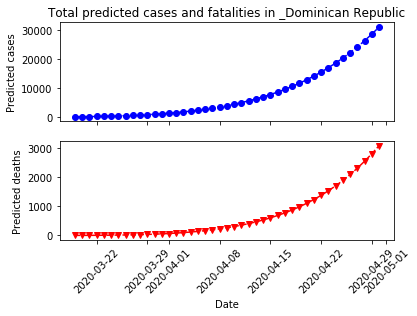

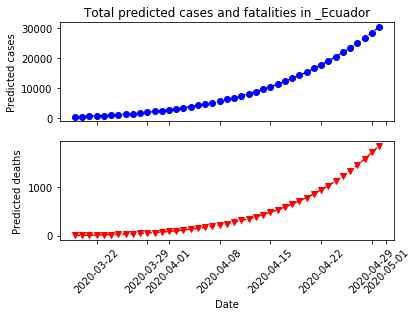

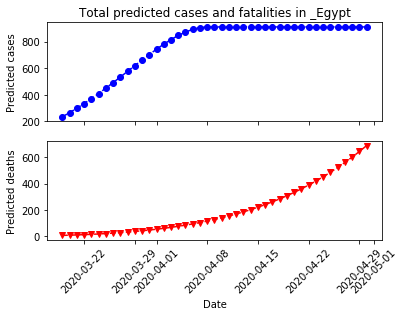

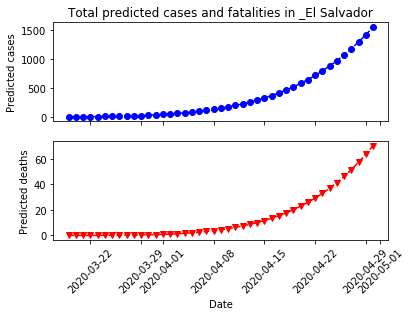

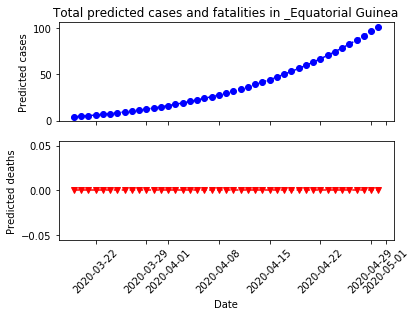

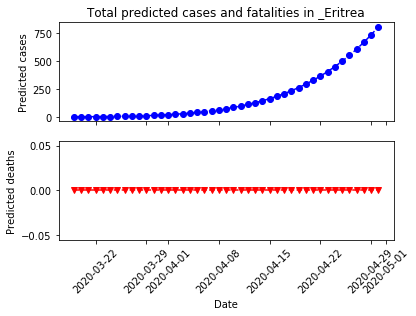

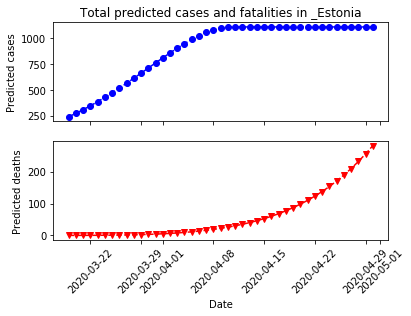

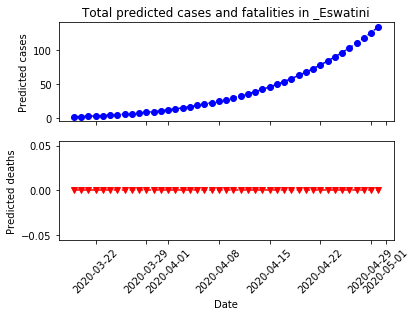

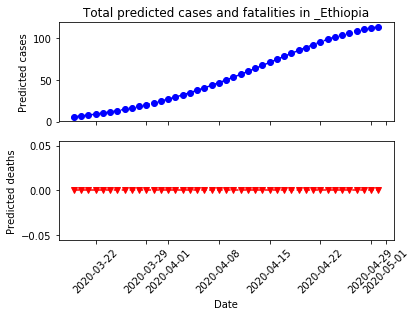

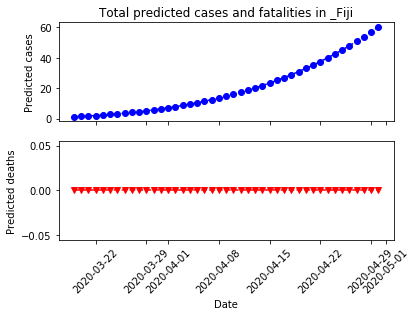

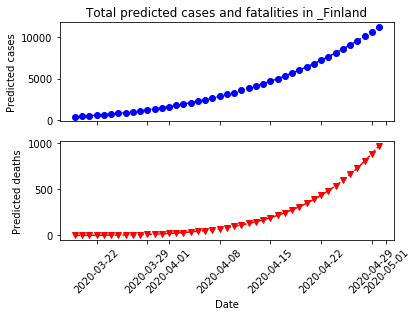

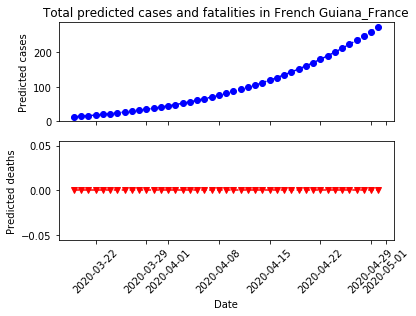

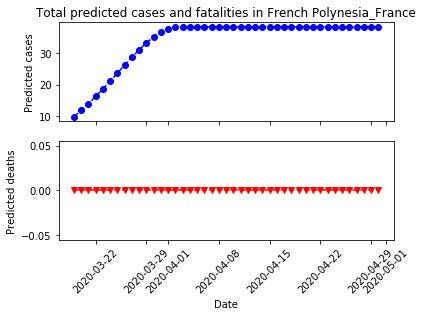

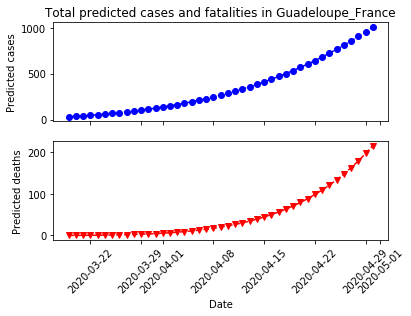

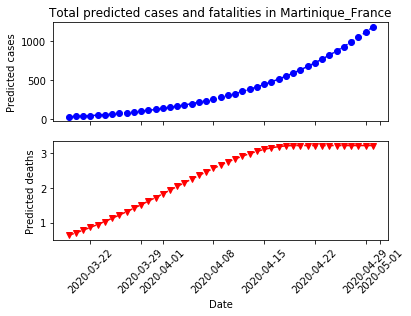

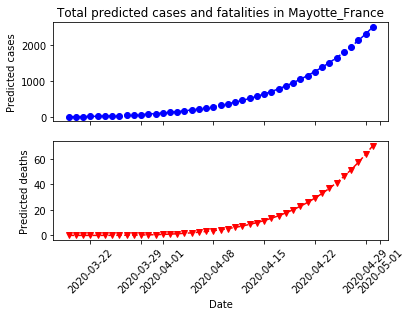

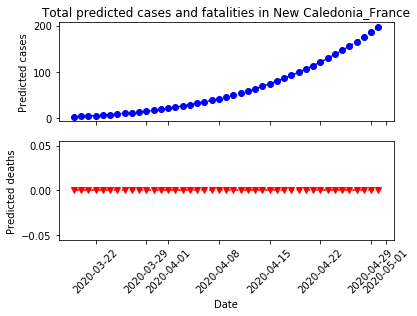

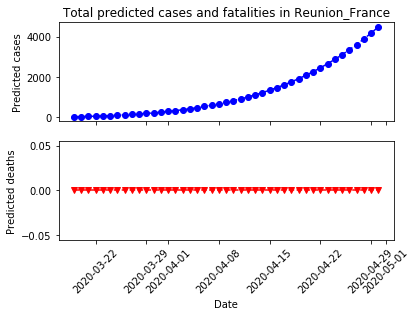

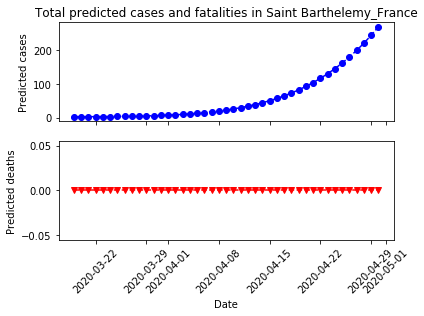

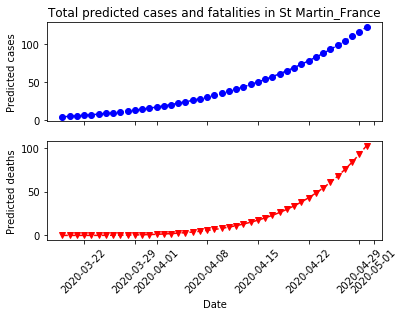

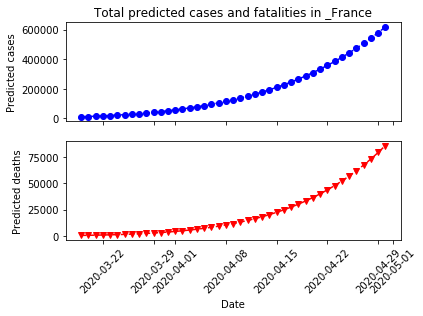

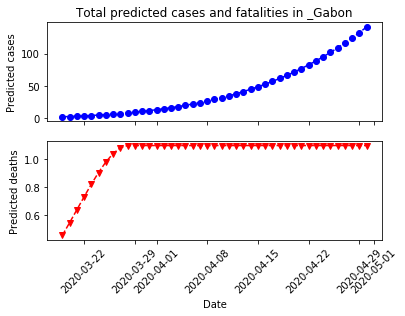

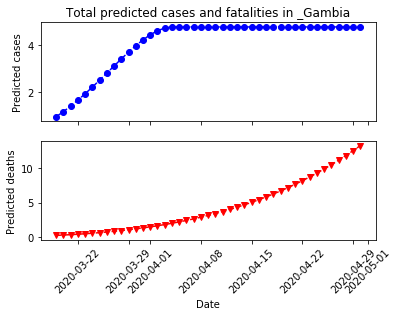

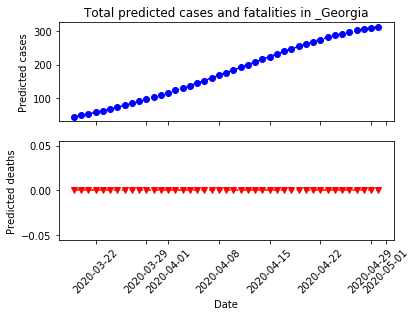

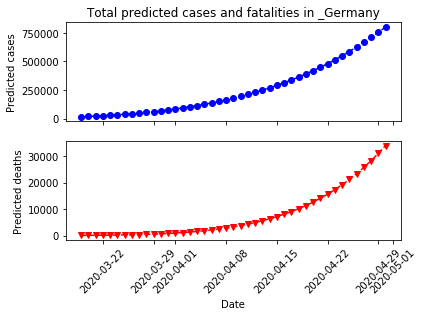

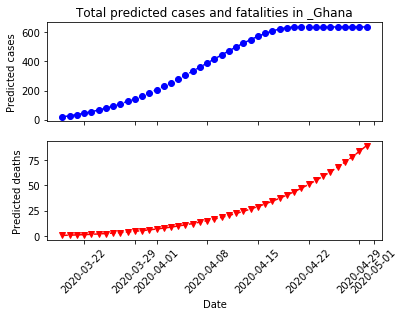

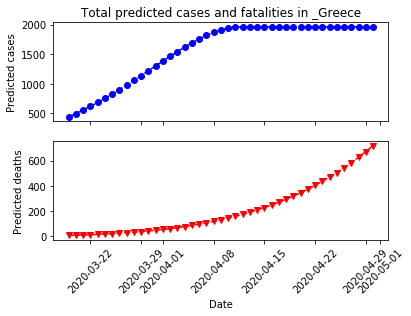

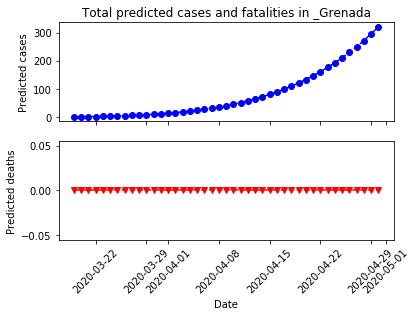

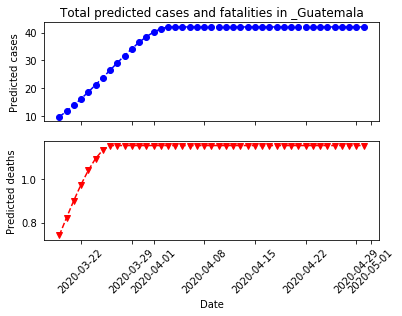

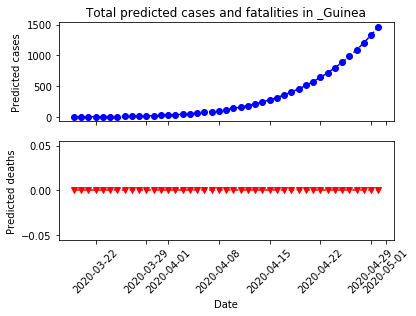

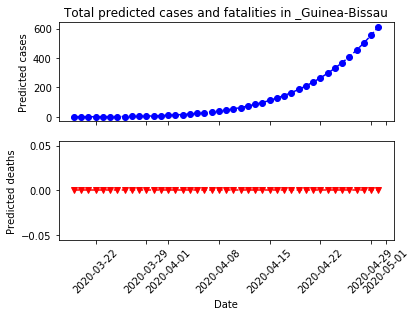

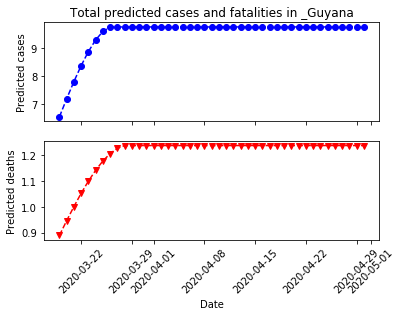

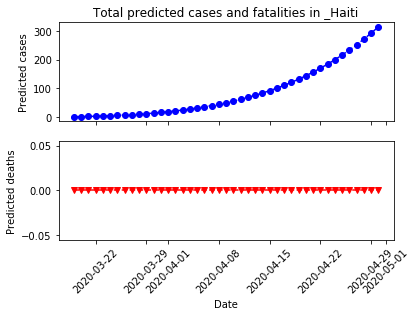

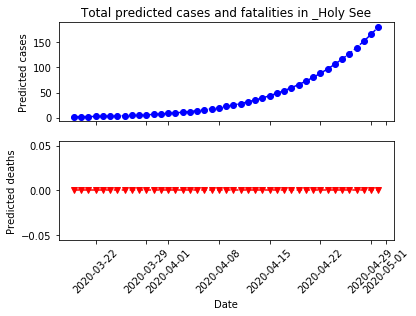

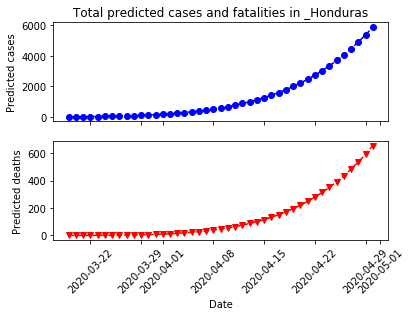

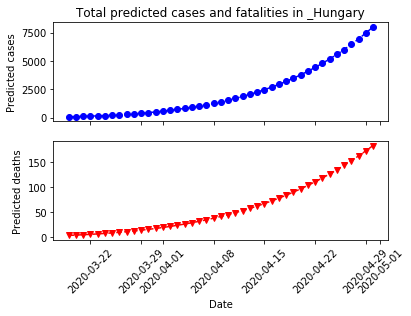

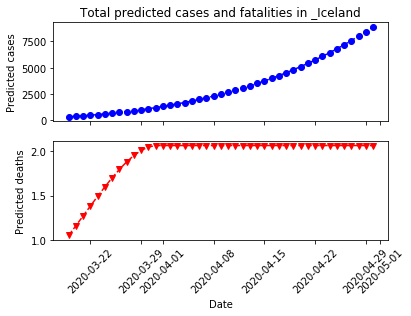

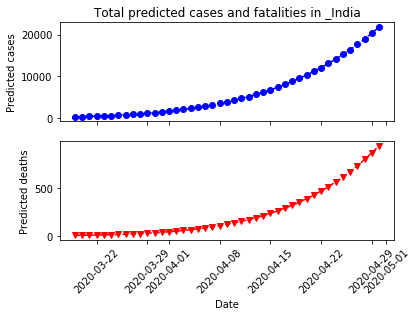

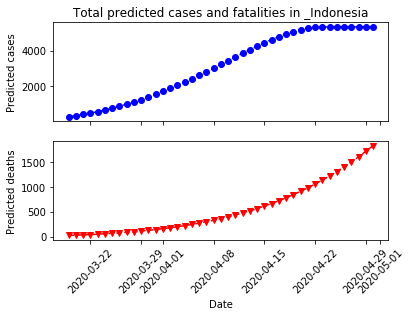

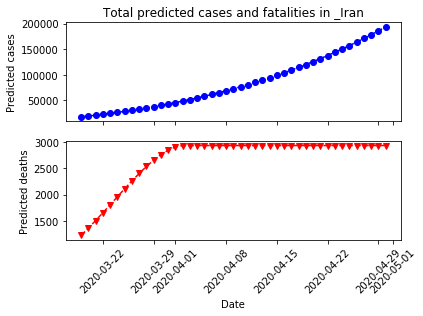

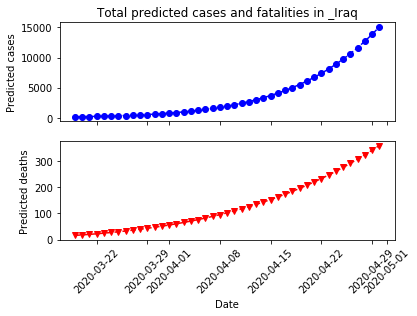

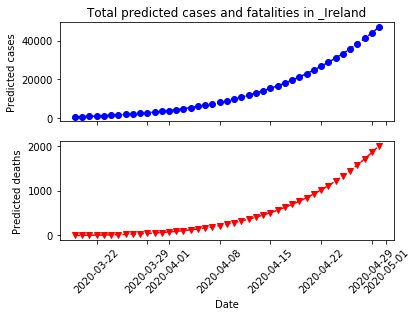

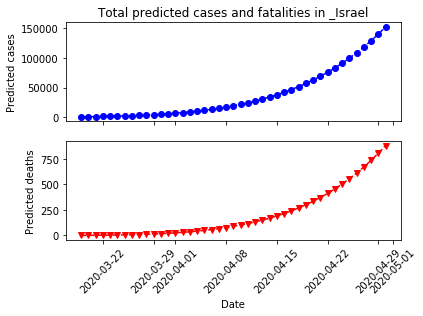

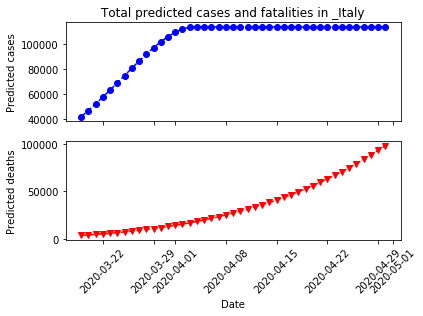

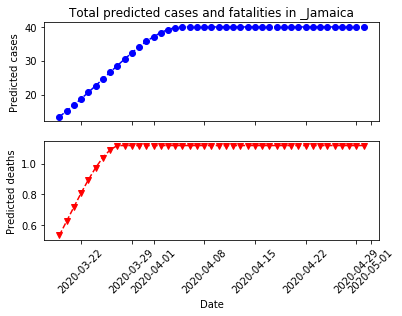

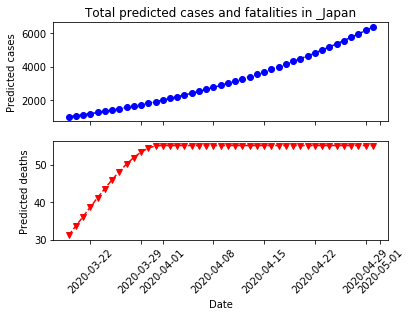

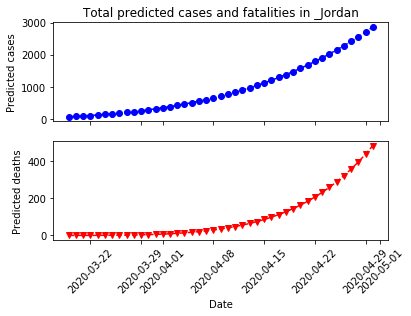

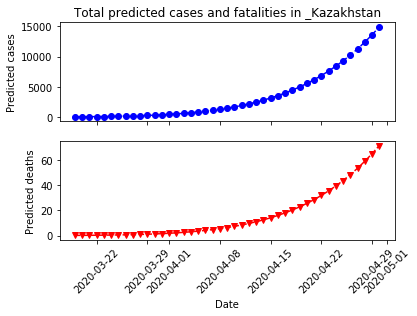

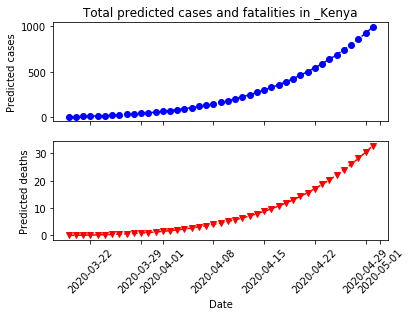

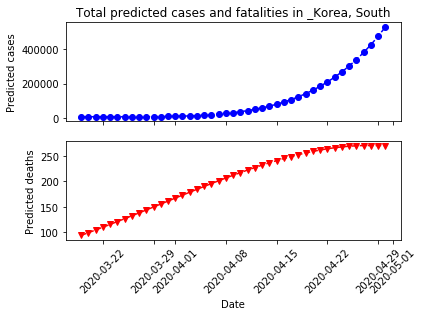

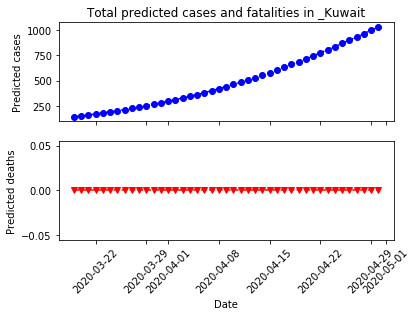

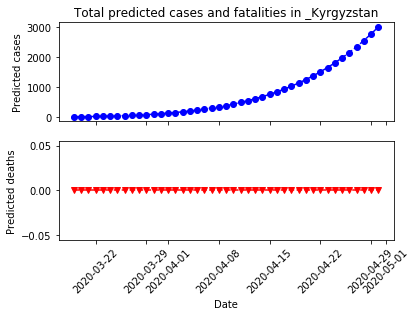

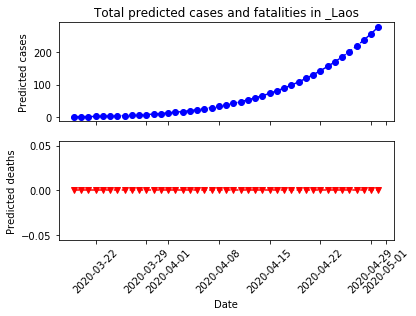

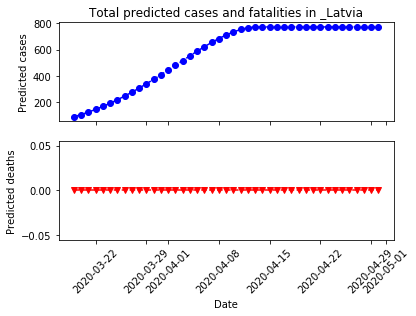

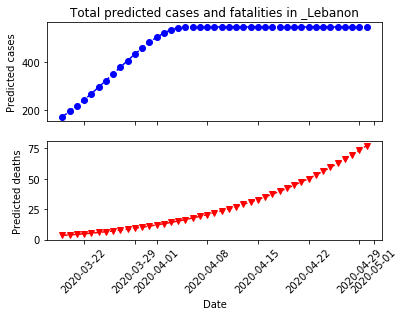

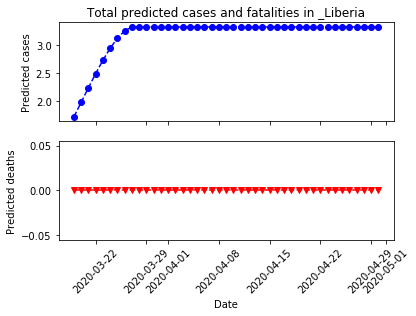

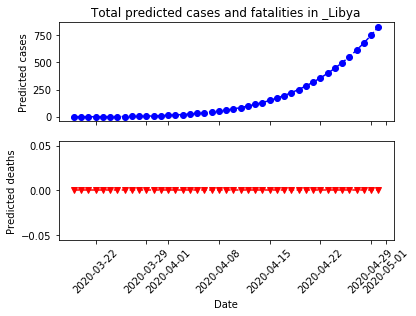

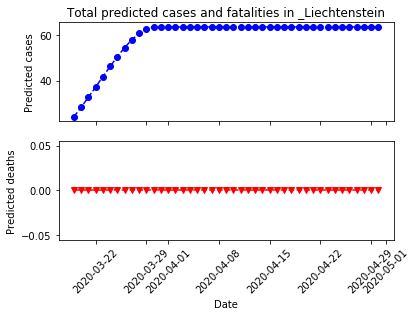

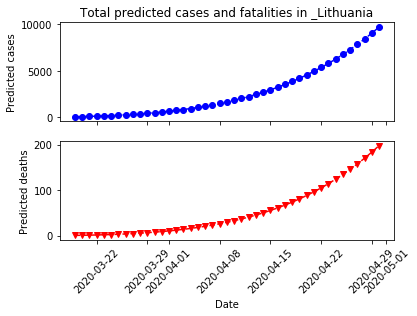

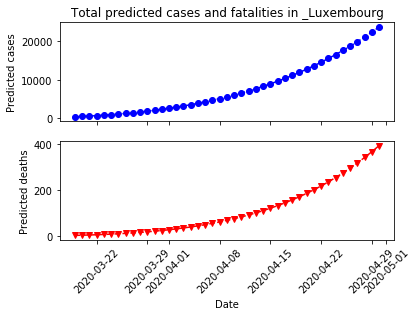

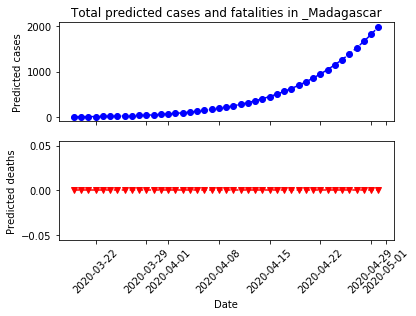

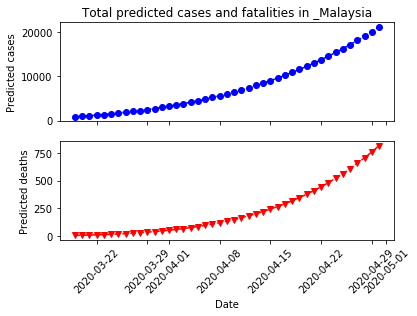

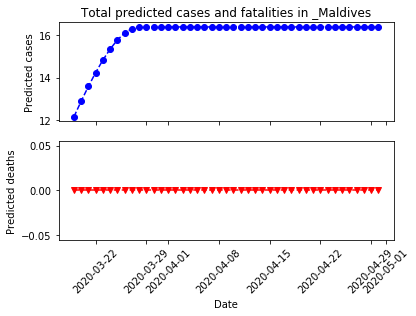

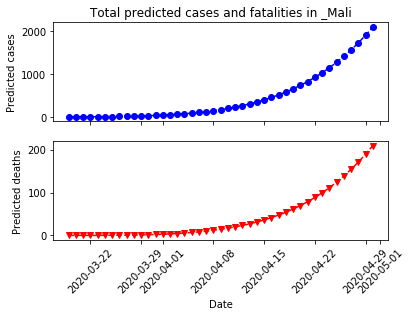

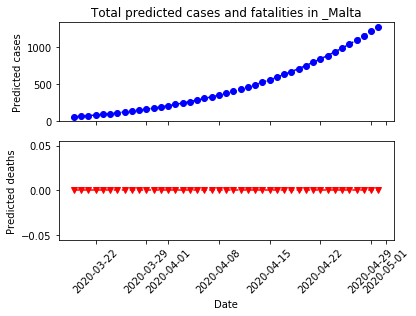

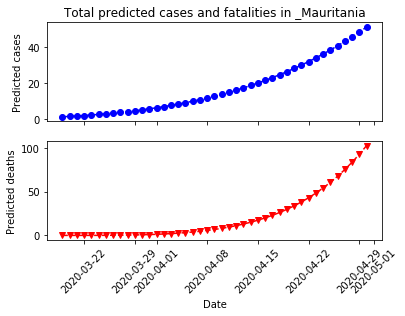

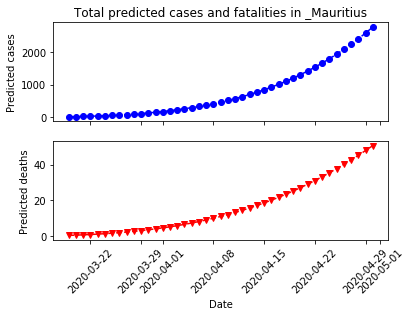

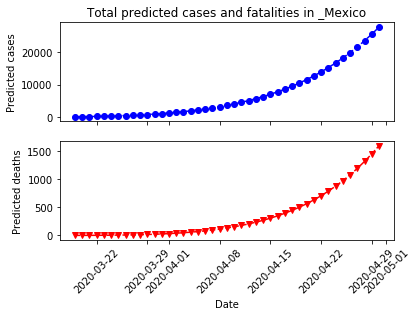

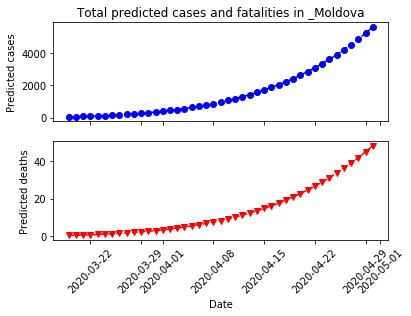

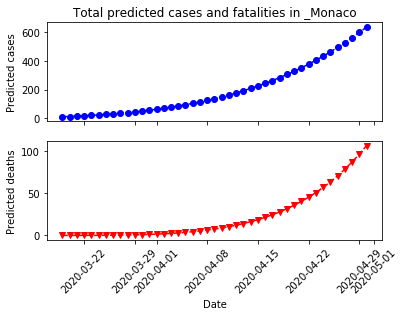

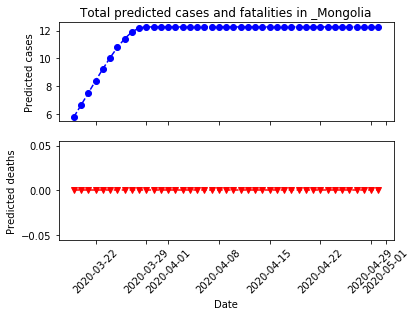

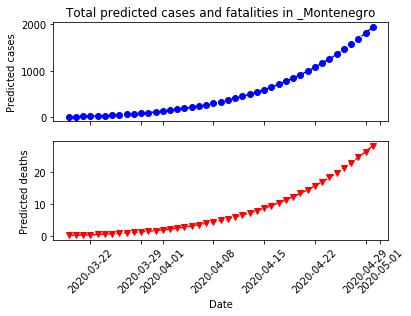

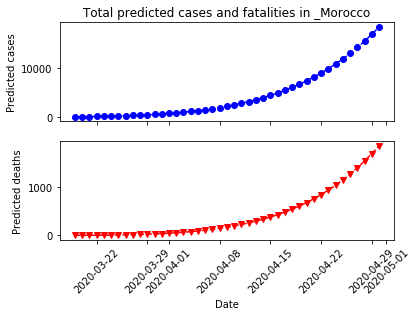

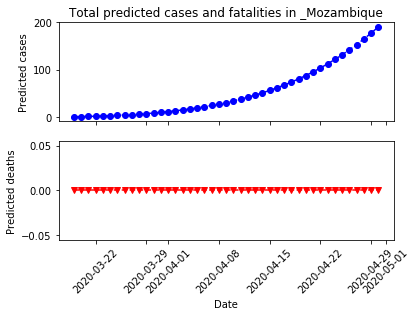

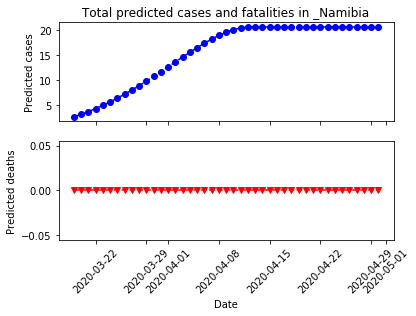

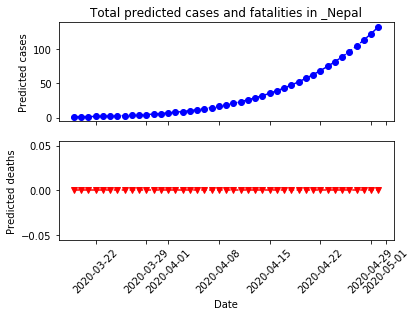

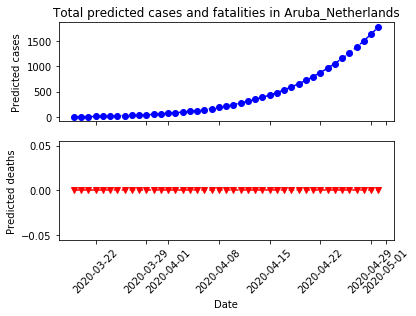

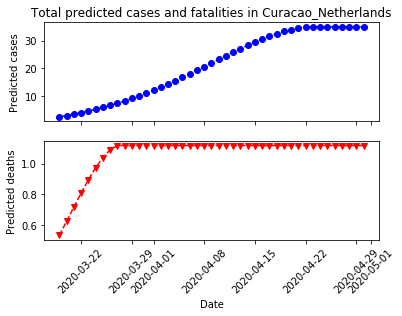

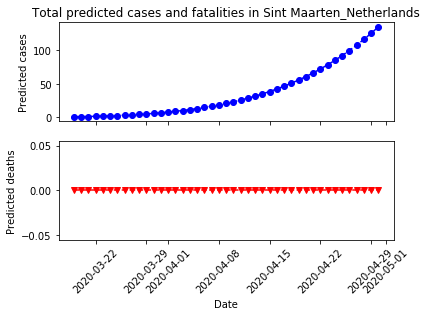

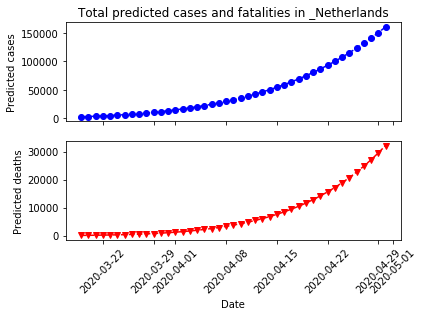

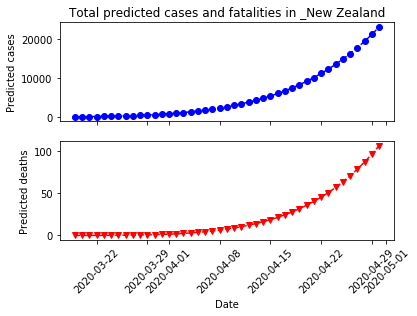

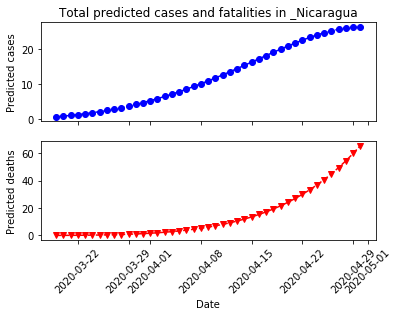

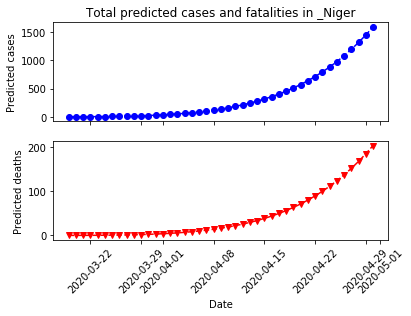

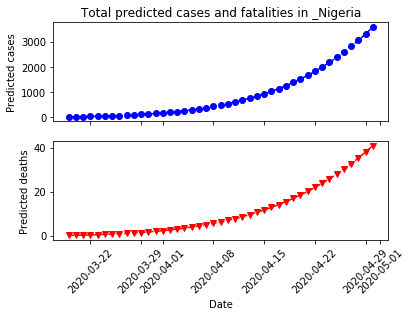

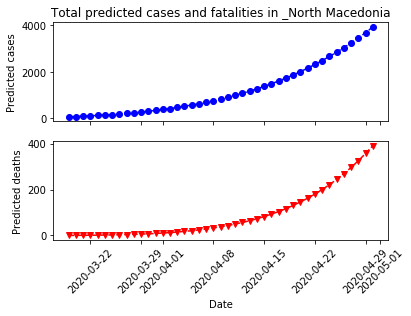

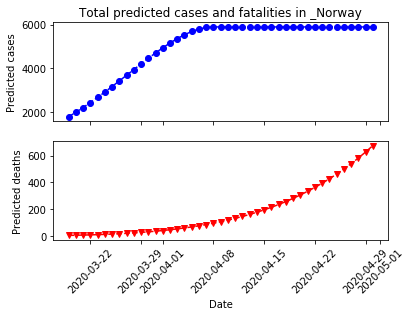

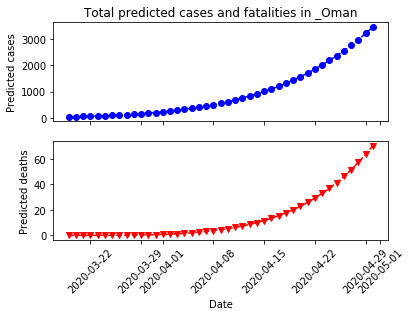

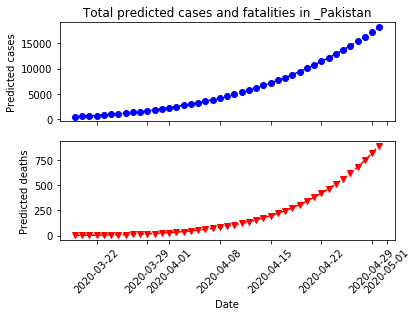

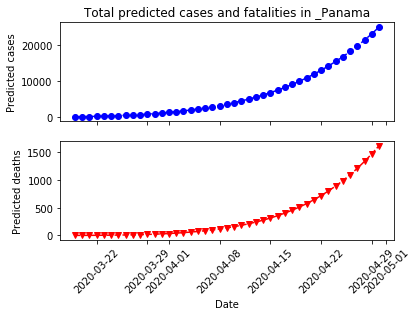

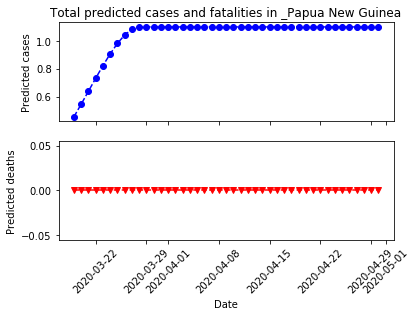

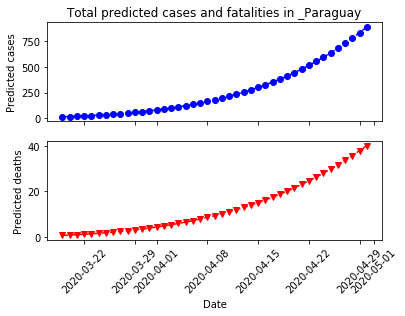

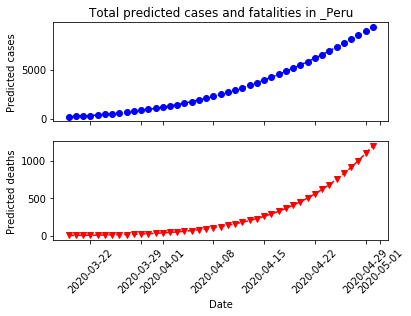

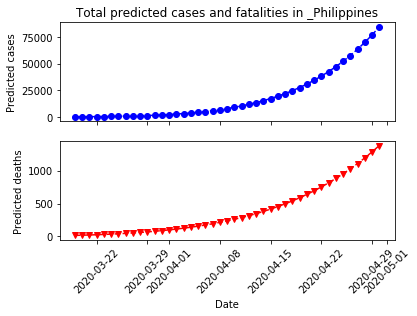

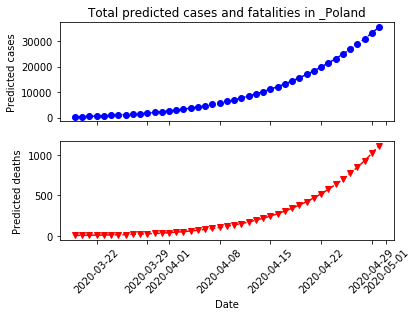

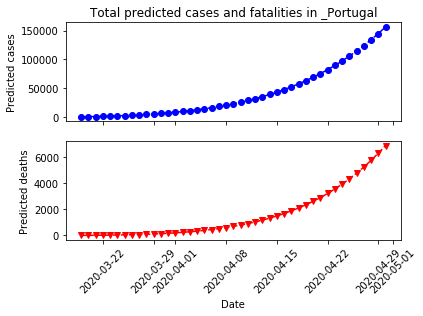

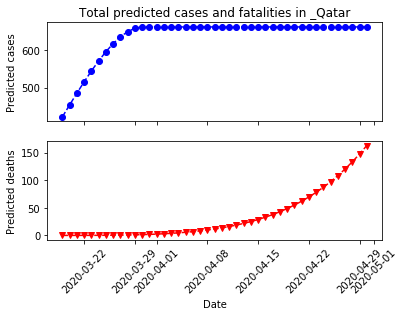

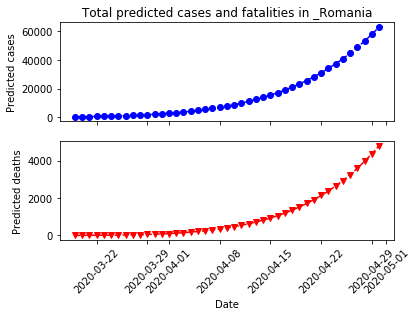

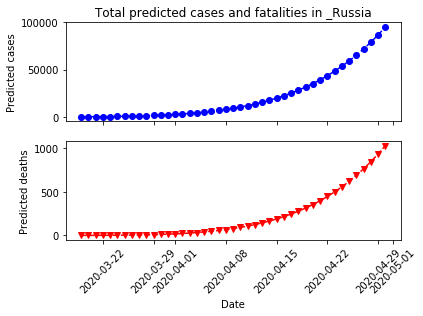

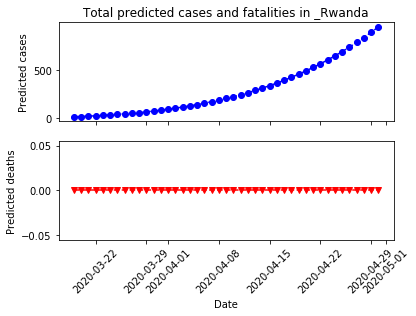

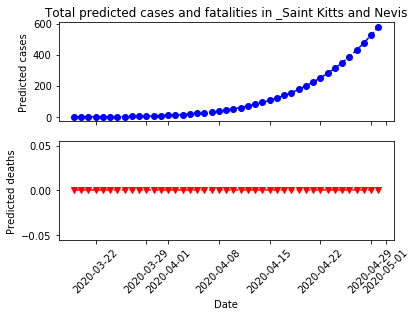

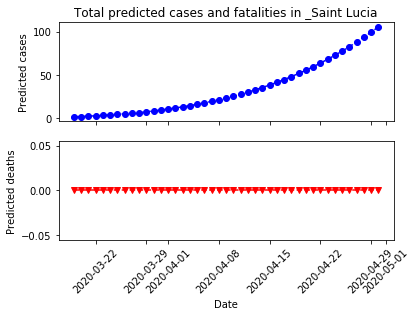

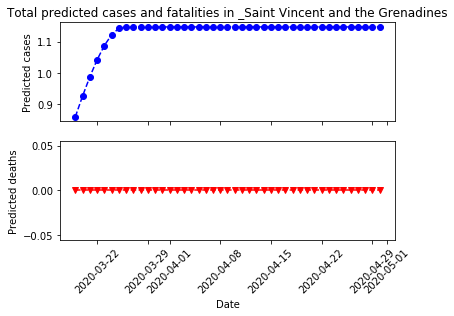

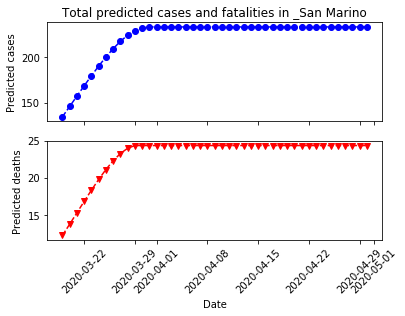

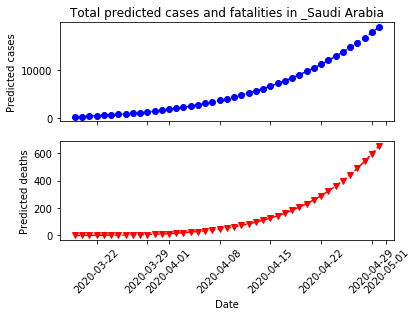

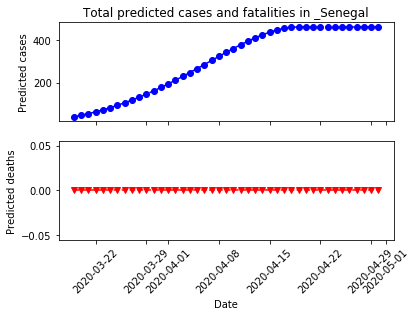

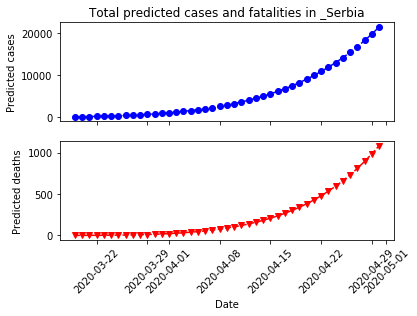

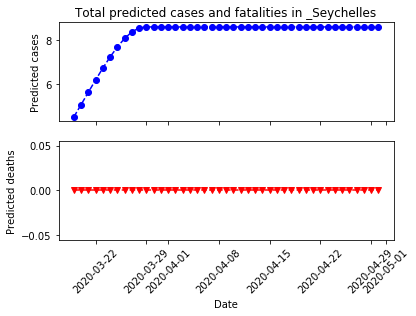

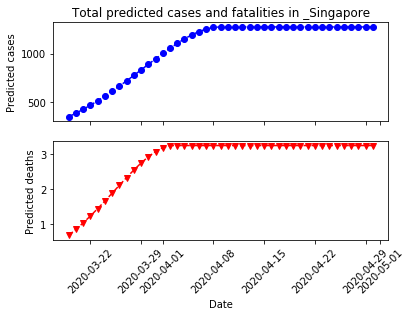

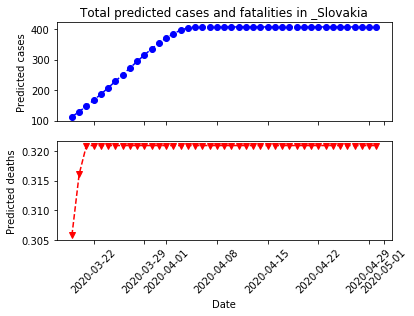

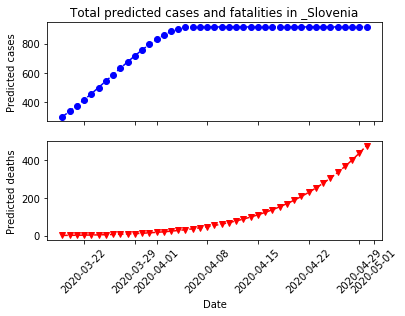

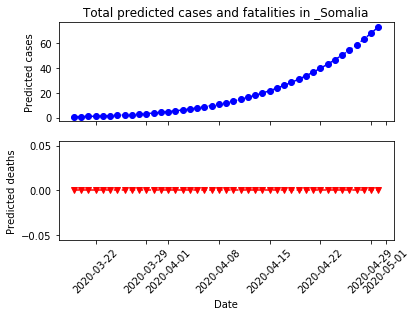

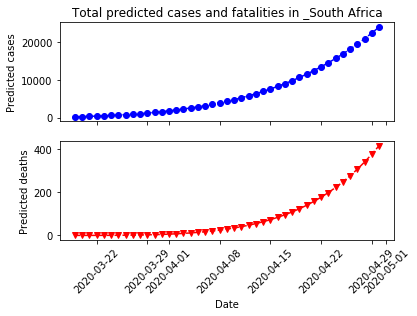

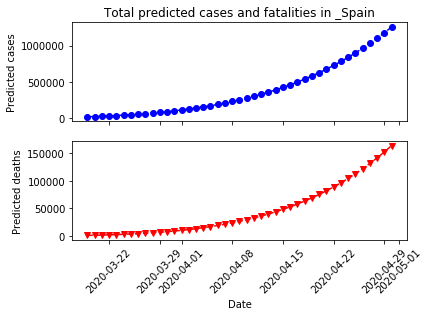

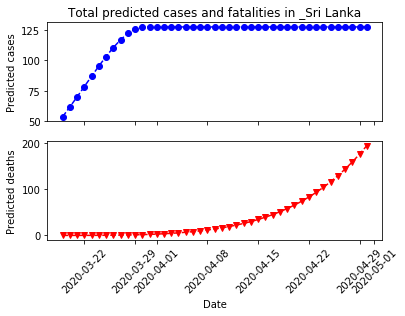

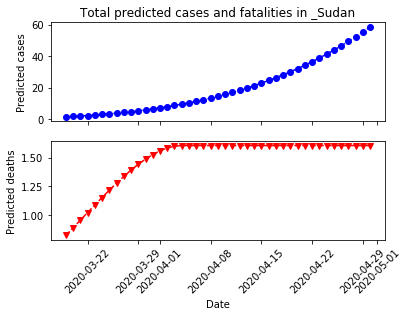

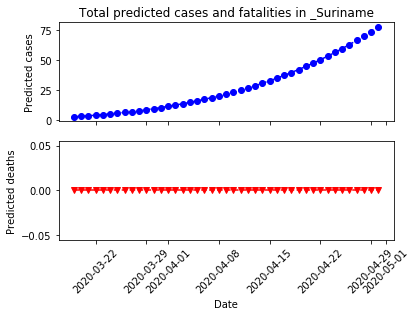

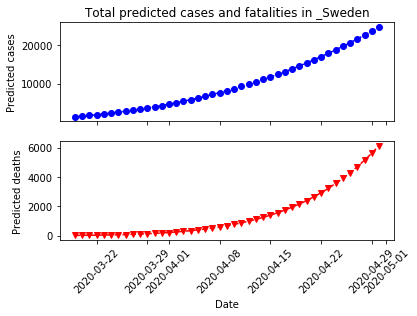

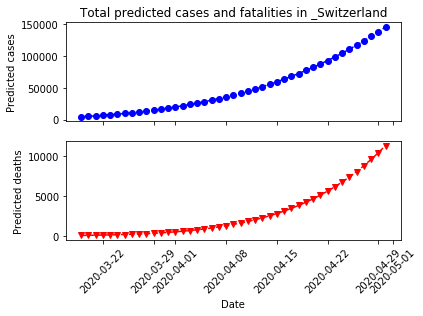

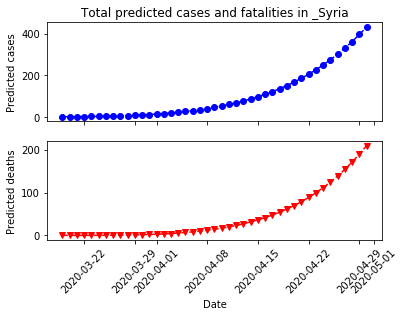

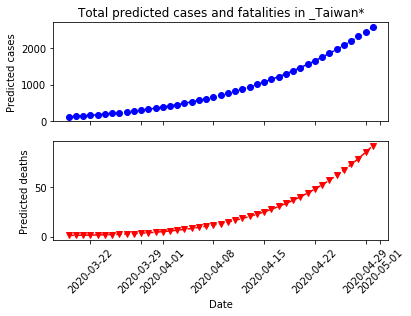

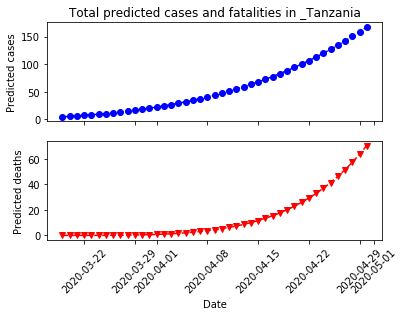

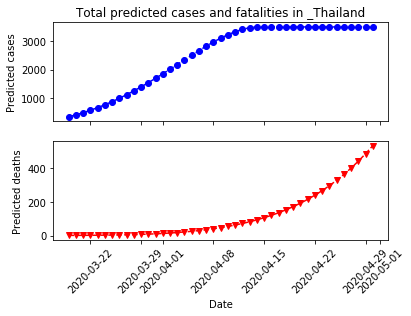

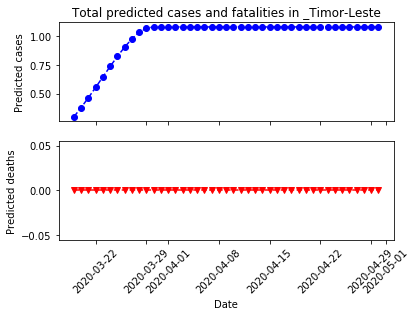

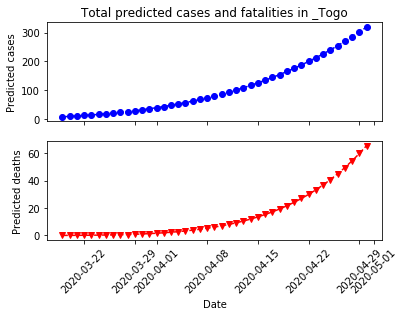

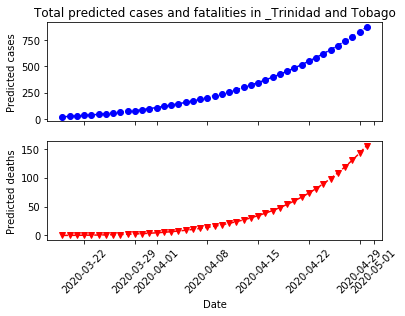

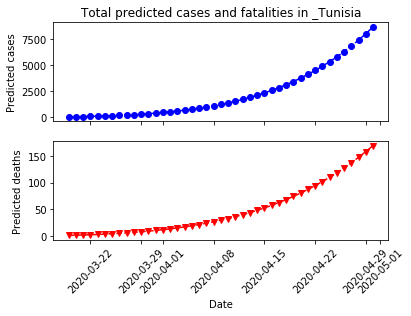

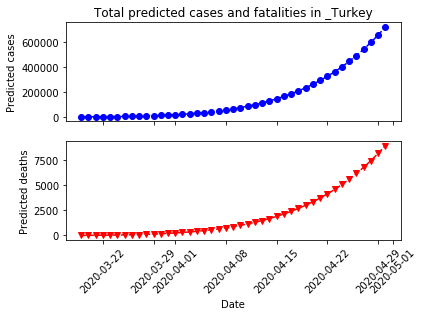

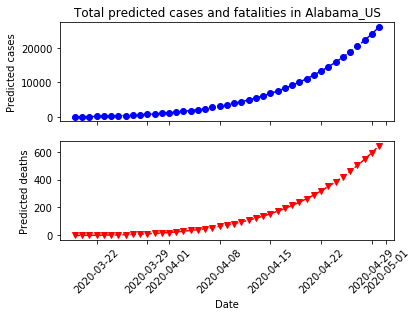

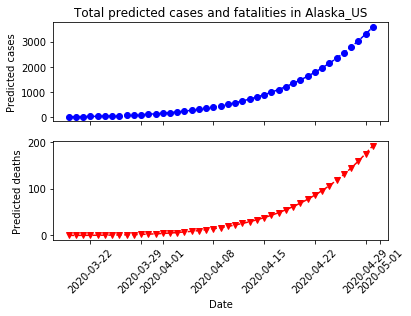

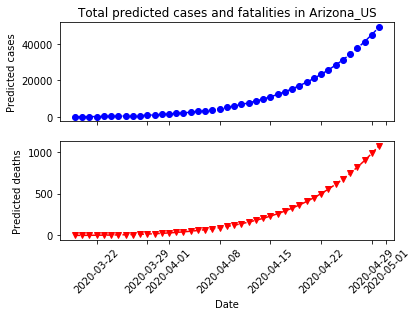

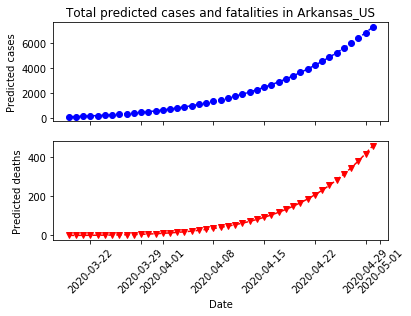

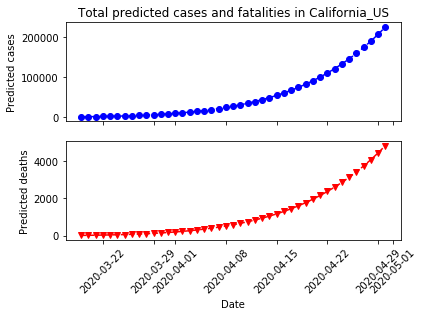

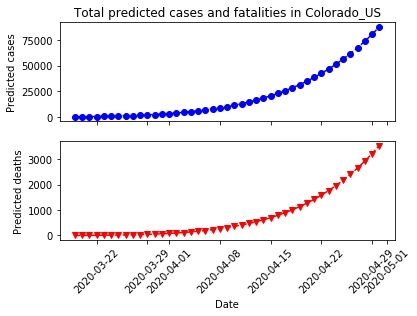

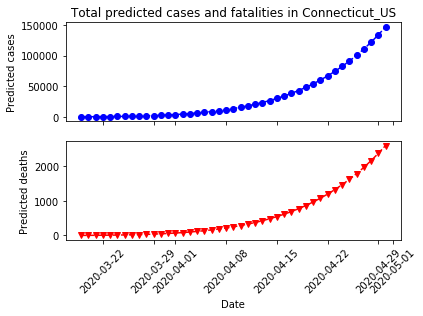

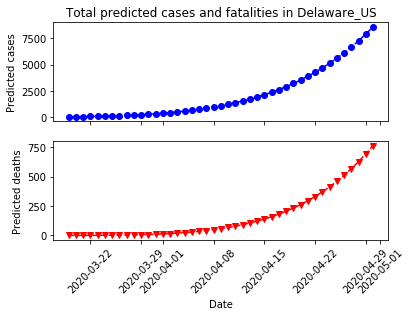

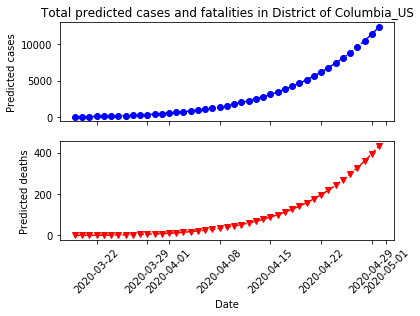

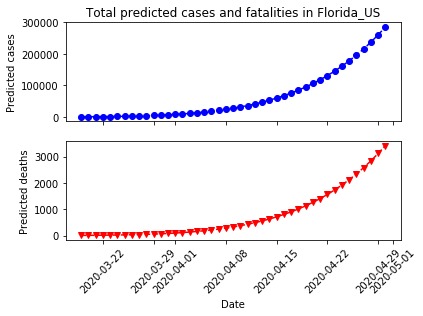

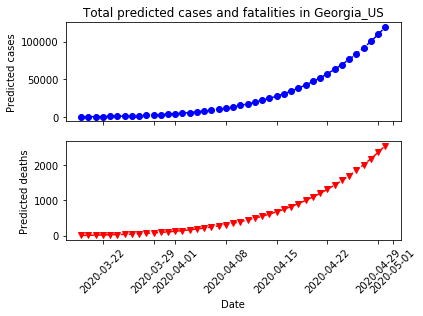

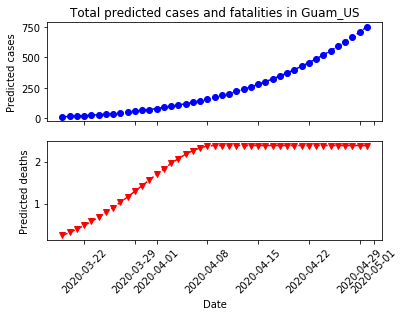

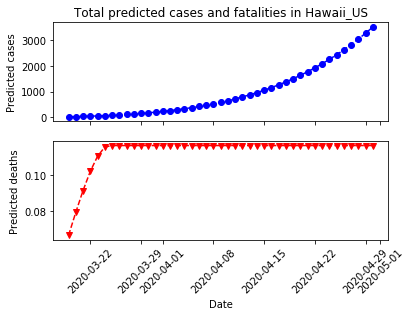

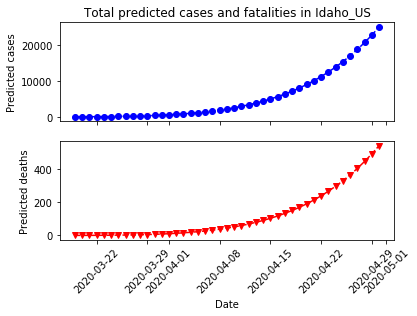

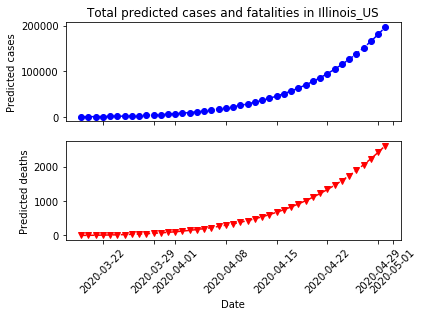

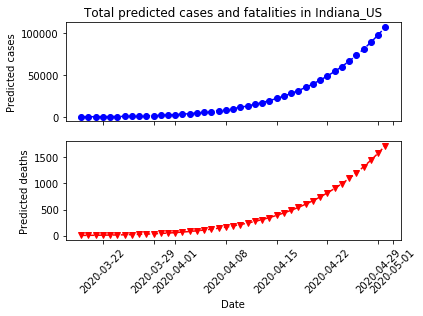

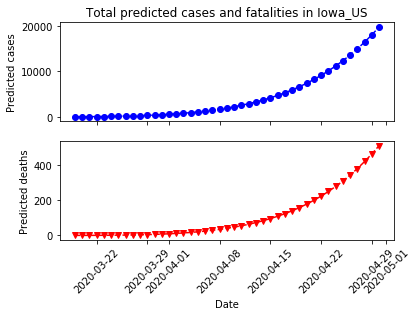

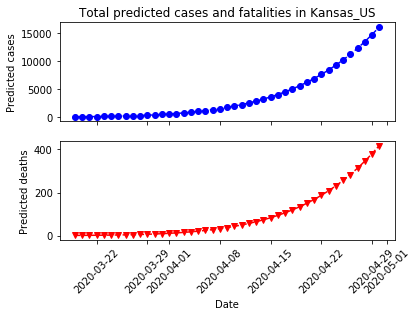

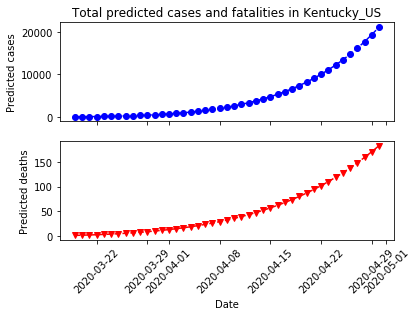

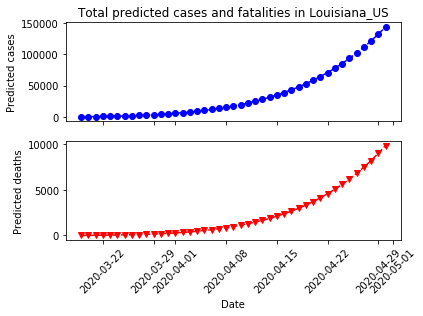

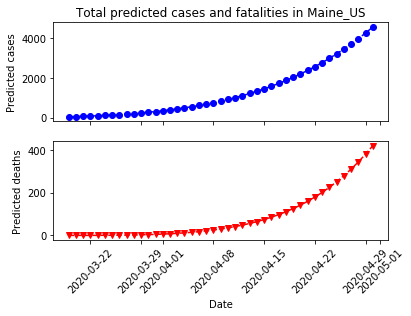

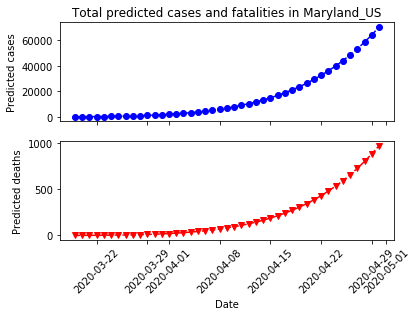

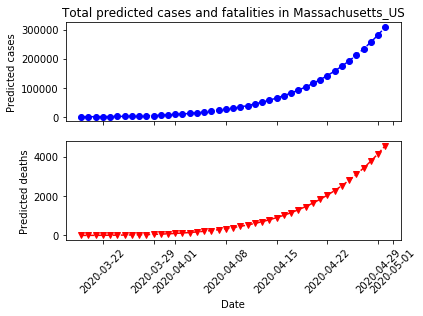

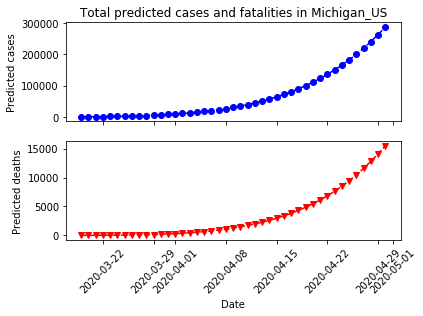

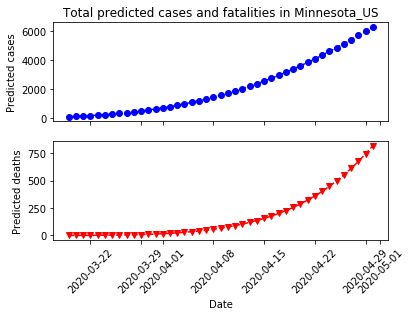

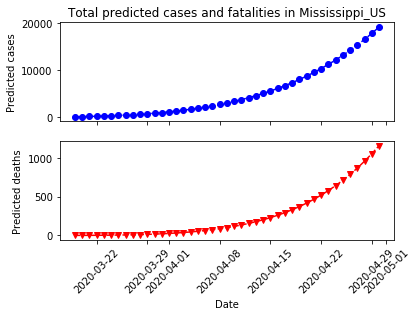

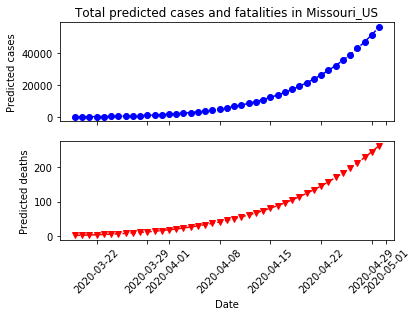

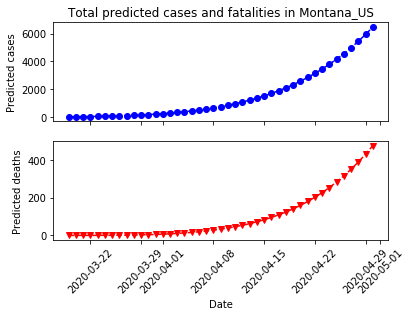

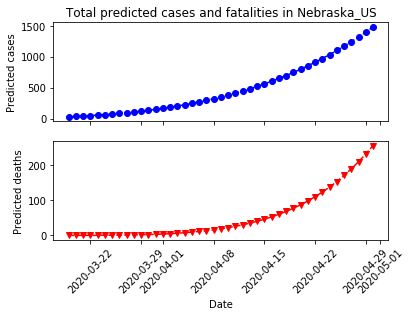

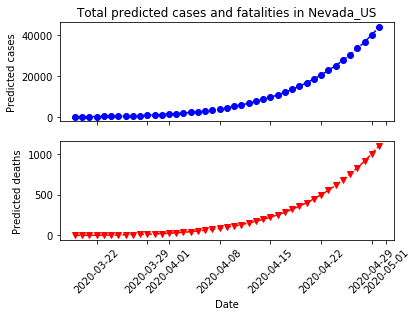

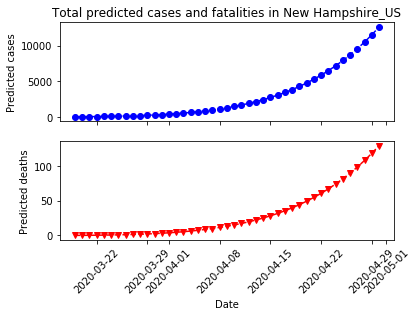

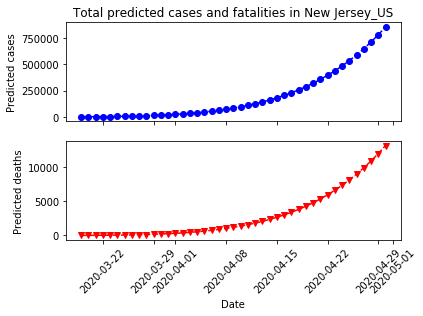

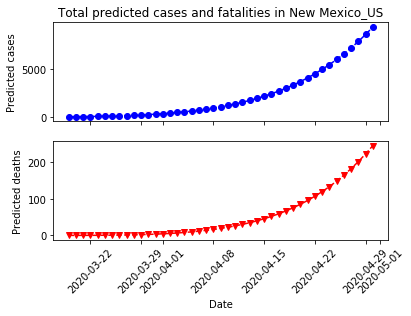

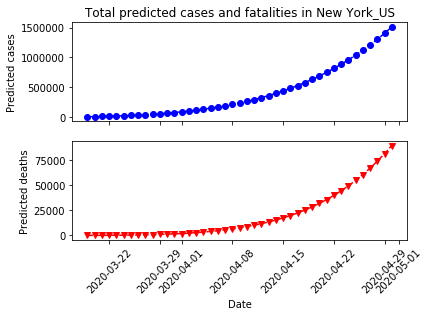

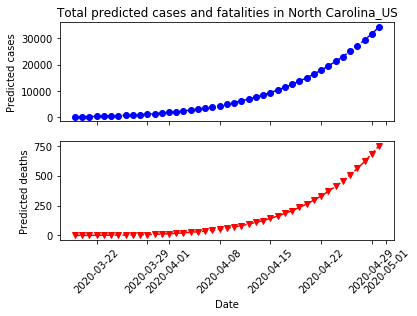

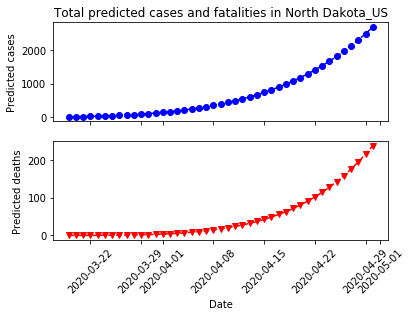

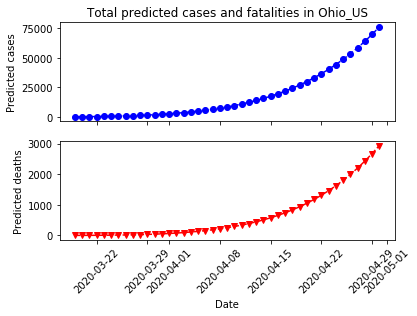

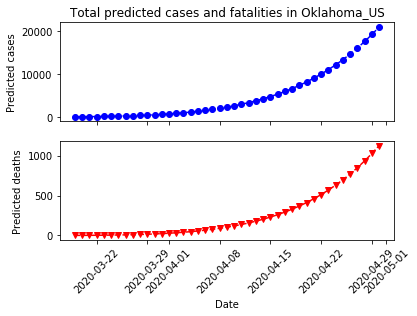

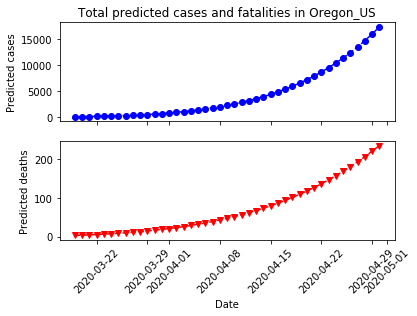

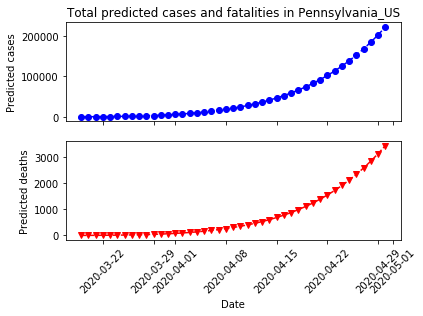

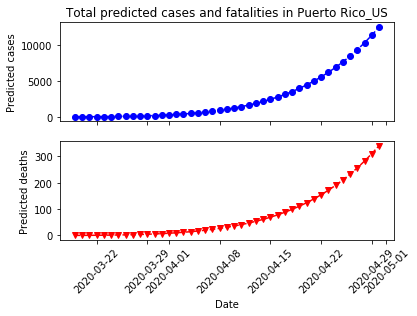

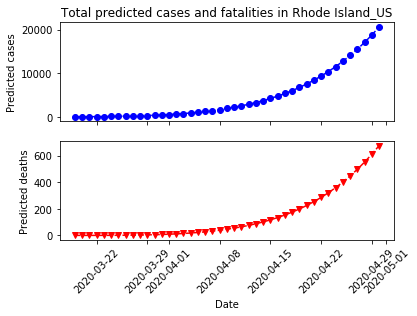

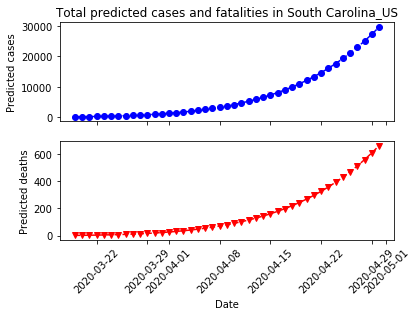

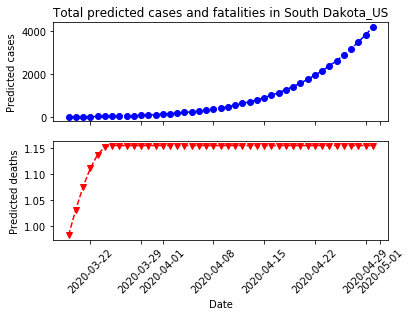

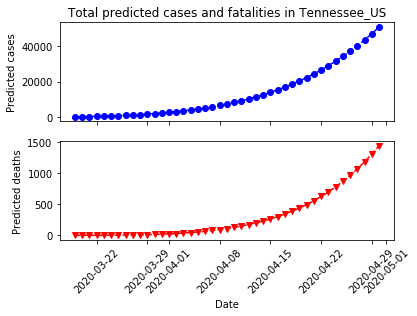

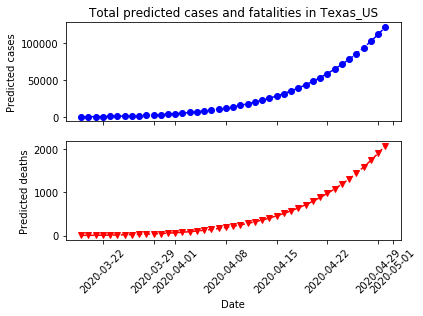

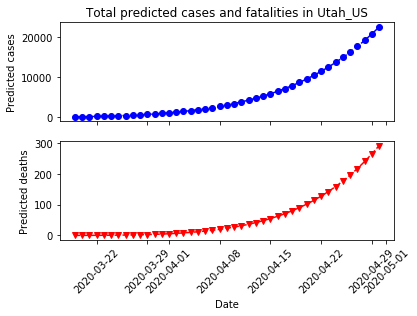

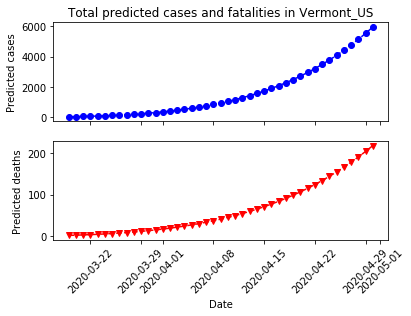

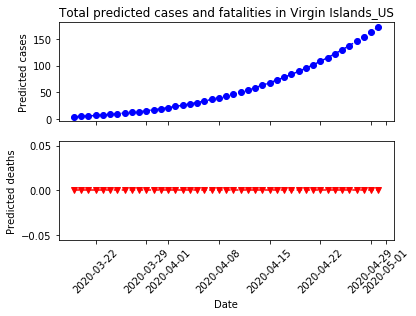

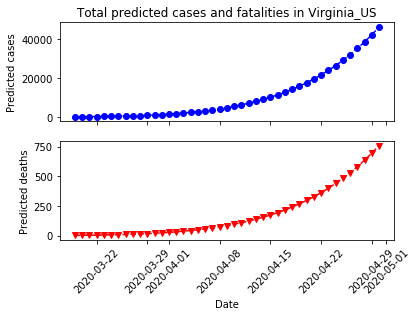

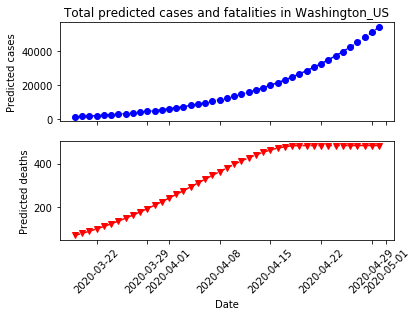

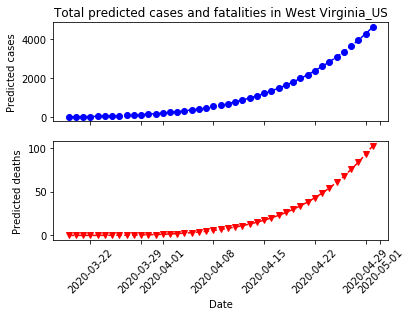

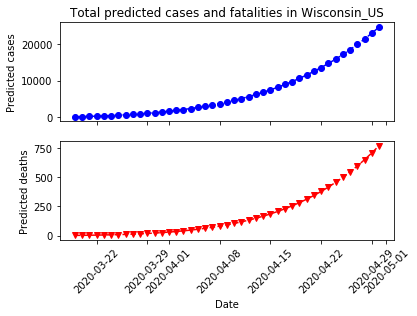

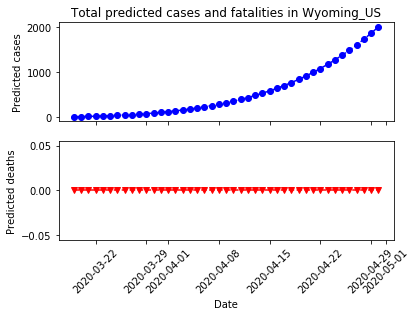

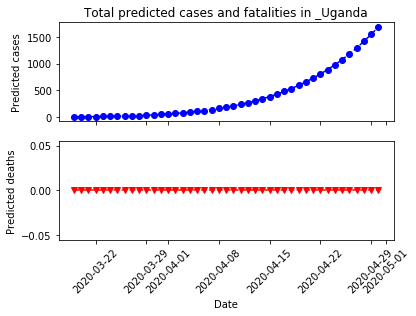

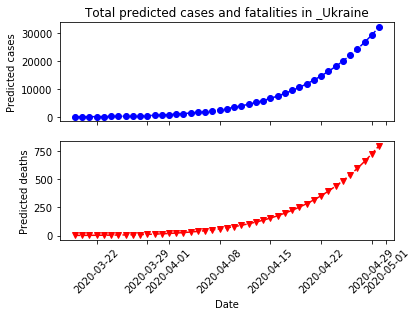

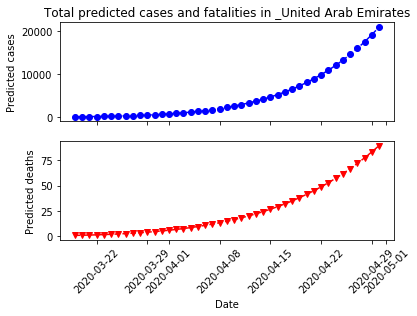

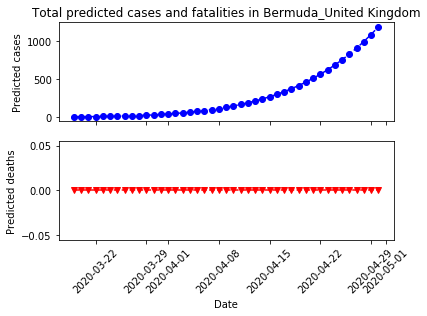

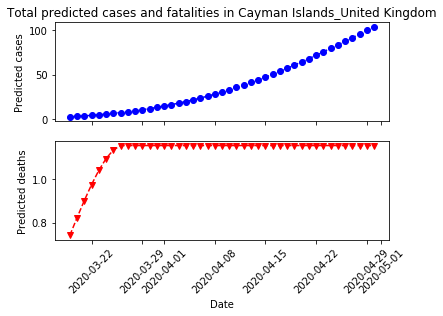

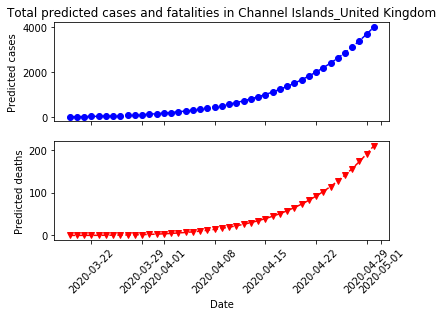

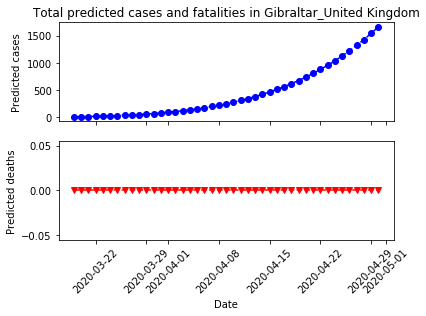

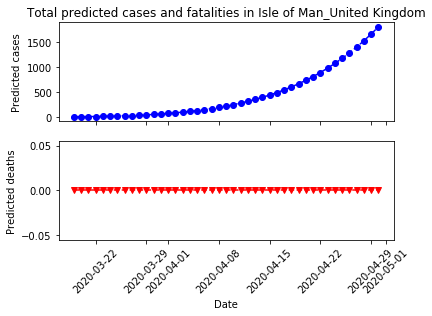

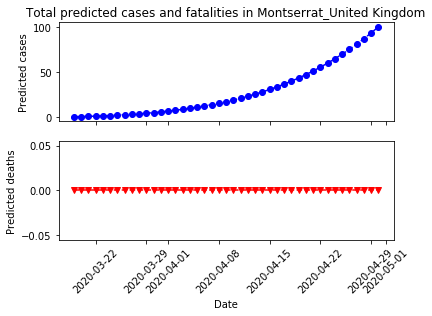

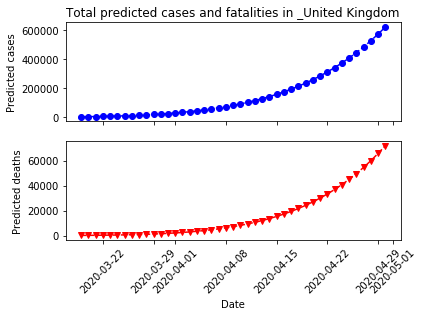

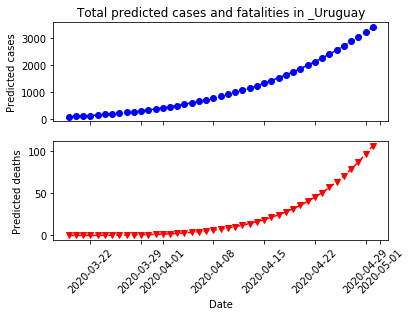

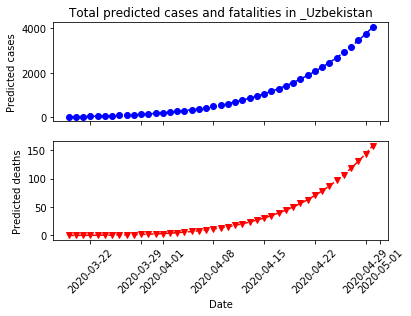

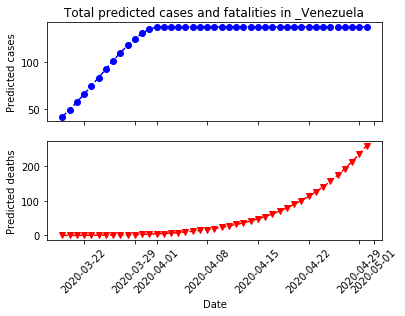

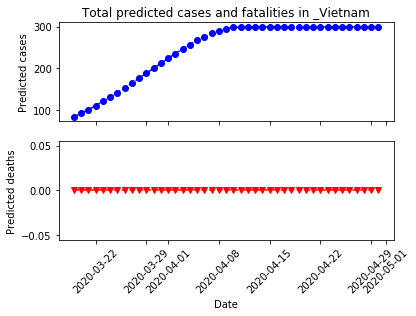

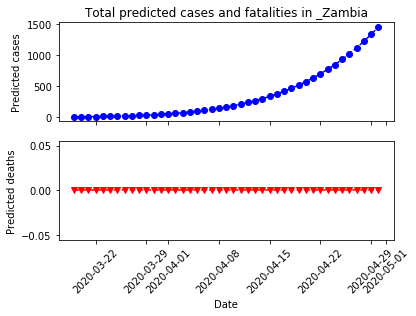

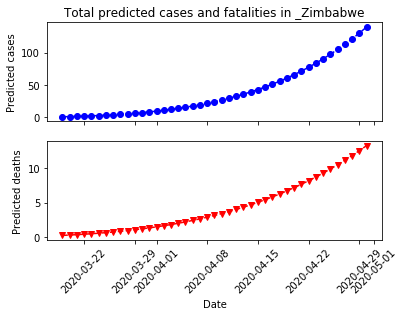

In [332]:
for place in df_compiled.place.unique():
    fig, ax = plt.subplots(2,1, sharex=True)
    ax[0].plot(df_compiled[df_compiled['place']==place].groupby('date')['ConfirmedCases'].sum(), 
               marker='o',color='b', linestyle='--')
    ax[1].plot(df_compiled[df_compiled['place']==place].groupby('date')['Fatalities'].sum(), 
               marker='v',color='r',linestyle='--')
    ax[0].set_ylabel('Predicted cases')
    ax[1].set_ylabel('Predicted deaths')
    ax[1].set_xlabel('Date')
    plt.xticks(rotation=45)

    ax[0].set_title('Total predicted cases and fatalities in {}'.format(place))
    plt.show()

#### SUBMISSION

In [333]:
submission= pd.read_csv(datapath+'submission.csv')

In [334]:
sub2 = submission[['ForecastId']].merge(df_compiled[['ForecastId','ConfirmedCases','Fatalities']],
                                      how='left',on='ForecastId') 

In [335]:
sub2['ConfirmedCases'] = sub2['ConfirmedCases'].round(1)
sub2['Fatalities'] = sub2['Fatalities'].round(1).abs()

In [336]:
sub2

ForecastId  ConfirmedCases  Fatalities
0               1            25.9         0.5
1               2            31.2         0.6
2               3            37.3         0.8
3               4            44.5         1.0
4               5            52.9         1.3
...           ...             ...         ...
12637       12638           105.1        10.5
12638       12639           113.1        11.2
12639       12640           121.5        11.9
12640       12641           130.4        12.6
12641       12642           139.8        13.3

[12642 rows x 3 columns]

In [337]:
sub2.to_csv('submission.csv', index=False)

#### Consider other methods

In [338]:
# # create a function to find best model for the non-stationary ConfirmedCases and Fatalities
# def pred_ets(fcastperiod,fcastperiod1,actual,ffcast,variable='ConfirmedCases',verbose=False):
    
#     actual=actual[actual[variable]>0]
#     index=pd.date_range(start=ffcast.index[0], end=ffcast.index[-1], freq='D')
#     data=ffcast[variable].values
#     ffcast1 = pd.Series(data, index)
#     index=pd.date_range(start=actual.index[0], end=actual.index[-1], freq='D')
#     data=actual[variable].values
#     daily_analysis_dat = pd.Series(data, index)
#     livestock2=daily_analysis_dat
#     fit=[]
#     fcast=[]
#     fname=[]
#     try:
#         fit1 = SimpleExpSmoothing(livestock2).fit()
#         fcast1 = fit1.forecast(fcastperiod1).rename("SES")
#         fit.append(fit1)
#         fcast.append(fcast1)
#         fname.append('SES')
#     except:
#         1==1
#     try:
#         fit2 = Holt(livestock2).fit()
#         fcast2 = fit2.forecast(fcastperiod1).rename("Holt")
#         fit.append(fit2)
#         fcast.append(fcast2)
#         fname.append('Holt')
#     except:
#         1==1
#     try:
#         fit3 = Holt(livestock2, exponential=True).fit()
#         fcast3 = fit3.forecast(fcastperiod1).rename("Exponential")
#         fit.append(fit3)
#         fcast.append(fcast3)
#         fname.append('Exponential')
#     except:
#         1==1
#     try:
#         fit4 = Holt(livestock2, damped=True).fit(damping_slope=0.98)
#         fcast4 = fit4.forecast(fcastperiod1).rename("AdditiveDamped")
#         fit.append(fit4)
#         fcast.append(fcast4)
#         fname.append('AdditiveDamped')
#     except:
#         1==1
#     try:
#         fit5 = Holt(livestock2, exponential=True, damped=True).fit()
#         fcast5 = fit5.forecast(fcastperiod1).rename("MultiplicativeDamped")
#         fit.append(fit5)
#         fcast.append(fcast5)
#         fname.append('MultiplicativeDamped')
#     except:
#         1==1
#     try:
#         fit6 = Holt(livestock2, damped=True).fit()
#         fcast6 = fit6.forecast(fcastperiod1).rename("AdditiveDampedC")
#         fit.append(fit6)
#         fcast.append(fcast6)
#         fname.append('AdditiveDampedC')
#     except:
#         1==1
    
#     pred_all_result=pd.concat([pd.DataFrame(k.fittedvalues) for k in fit],axis=1)
#     pred_all_result.columns=fname
#     all_result=pd.concat([pd.DataFrame(k) for k in fcast],axis=1)
#     col_chk=[]
#     vvvl=ffcast[variable].values.shape[0]
#     for k in all_result.columns:
#         if verbose: print("actual value for method %s  is = %s" % (k,
#                                                                    RMSLE(all_result[k].values,
#                                                                          ffcast[variable].values)))
#         if RMSLE(all_result[k].values[:vvvl],ffcast[variable].values) is not np.nan:
#             col_chk.append(k)
#     col_chk_f=[]
#     min_acc=-1
#     for k in col_chk:
#         acc=RMSLE(pred_all_result[k].values,actual[variable].values)
#         # if k =='AdditiveDamped' and acc>0.01:
#         # acc=acc-0.01
#         if verbose: print("pred value for method %s  is = %s" % (k,acc))
#         if acc is not np.nan:
#             col_chk_f.append(k)
#             if min_acc==-1:
#                 min_acc=acc
#                 model_select=k
#             elif acc<min_acc:
#                 min_acc=acc
#                 model_select=k
#     all_result=all_result.append(pred_all_result,sort=False)
#     all_result['best_model']=model_select
#     all_result['best_pred']=all_result[model_select]
#     return all_result

In [339]:
# warnings.filterwarnings("ignore")
# import sys
# orig_stdout = sys.stdout

# Fatalities_all_result_final=pd.DataFrame()
# ConfirmedCases_all_result_Final=pd.DataFrame()
# for keys in allplaces:
#     chk=train[train['place']==keys]
#     chk.index=chk.date
#     fcastperiod=0
#     fcastperiod1=35
#     actual=chk[:chk.shape[0]-fcastperiod]
#     ffcast=chk[chk.shape[0]-fcastperiod-1:]
#     ffcast
#     try:
#         Fatalities_all_result_1=pred_ets(fcastperiod,fcastperiod1,actual,
#                                          ffcast,'Fatalities').reset_index()
        
#     except:
#         Fatalities_all_result_1=pd.DataFrame(pd.date_range(start=chk.date.min(), 
#                                                            periods=60+fcastperiod1+1, 
#                                                            freq='D')[1:])
#         Fatalities_all_result_1.columns=['index']
#         Fatalities_all_result_1['best_model']='naive'
#         Fatalities_all_result_1['best_pred']=0
        
#     Fatalities_all_result_1['place']=keys
#     Fatalities_all_result_final=Fatalities_all_result_final.append(Fatalities_all_result_1,
#                                                                    sort=True)
#     try:
#         ConfirmedCases_all_result_1=pred_ets(fcastperiod,fcastperiod1,actual,
#                                              ffcast,'ConfirmedCases').reset_index()

#     except:
#         ConfirmedCases_all_result_1=pd.DataFrame(pd.date_range(start=train.date.min(), 
#                                                                periods=60+fcastperiod1+1, 
#                                                                freq='D')[1:])
#         ConfirmedCases_all_result_1.columns=['index']
#         ConfirmedCases_all_result_1['best_model']='naive'
#         ConfirmedCases_all_result_1['best_pred']=1
    
#     ConfirmedCases_all_result_1['place']=keys
#     ConfirmedCases_all_result_Final=ConfirmedCases_all_result_Final.append(ConfirmedCases_all_result_1,sort=True)
# print(' done')

# sys.stdout = orig_stdout

In [340]:
# # place with lack of data to forecast
# print(Fatalities_all_result_1['place'].unique())
# print(ConfirmedCases_all_result_1['place'].unique())

In [341]:
# ConfirmedCases_all_result_Final.groupby('best_model')['place'].nunique().sort_values(ascending=False)

In [342]:
# Fatalities_all_result_final.groupby('best_model')['place'].nunique().sort_values(ascending=False)

In [343]:
# ConfirmedCases_all_result_Final.isna().sum()

In [344]:
# ConfirmedCases_all_result_Final.isna().sum()

In [345]:
# ConfirmedCases_compiled_res = ConfirmedCases_all_result_Final[['best_pred','index','place']]
# Fatalities_compiled_res  = Fatalities_all_result_final[['best_pred','index','place']]

In [346]:
# ConfirmedCases_compiled_res.columns = ['ConfirmedCases','date','place']
# Fatalities_compiled_res.columns     = ['Fatalities','date','place']

In [347]:
# ConfirmedCases_compiled_res.columns

In [348]:
# Fatalities_compiled_res.columns

In [349]:
# a = ConfirmedCases_compiled_res.merge(test[['ForecastId','date','place']], 
#                                       how='right',on=['place','date'])
# a = a.sort_values(['ForecastId'])
# a

In [350]:
# b = Fatalities_compiled_res.merge(test[['ForecastId','date','place']], 
#                                       how='right',on=['place','date'])
# b = b.sort_values(['ForecastId'])
# b

In [351]:
# sub = a.merge(b[['ForecastId','Fatalities']], on=['ForecastId'],  how='left')
# sub

In [352]:
# sub[['ConfirmedCases','Fatalities']] = sub[['ConfirmedCases','Fatalities']].fillna(0)

In [353]:
# sub.isna().sum()